In [1]:
!pip install cma

  Obtaining dependency information for cma from https://files.pythonhosted.org/packages/77/70/da60edd6a12a8b4af07e583076c8f039f2a2792a0f0d9219d84522d23493/cma-3.3.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 3.8 MB/s eta 0:00:00a 0:00:01


In [2]:
#!/usr/bin/env python3

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import copy
import cma
import math
from sklearn.metrics import mean_squared_error


In [11]:
#removes first N-1 items of the list
def moving_average(time_series, N):
    return np.convolve(time_series, np.ones((N,))/N)[(N-1):]


#Differential equations of the model
def deriv(Price0, t, limit, alpha):
    Price = Price0
    dPricedt =(1 - Price/limit)*Price*alpha
    return dPricedt

def simulation(params):
    x0 =params[0]
    limit = params[1]
    alpha=params[2]
    t_max = params[3]
    t = range(0, t_max)
    ret = odeint(deriv, x0, t, args=(limit, alpha))
    return ret.T[0]

def readData(filename):
        file = open(filename, "r")
        data1 =  file.read().splitlines()
        data2 = [float(x) for x in data1]
        return data2
    
def converse(n, v0):
    return v0 + n*10


def deconverse(num, v0):
    return (num-v0)/10

#removes first N-1 items of the list
def moving_average(time_series, N):
    return np.convolve(time_series, np.ones((N,))/N)[(N-1):]



In [23]:
class DESimulator:
    def __init__(self, realdata):
        self.realdata = realdata
        self.es = cma.CMAEvolutionStrategy(4*[0], 0.5)

    def run(self, sigma, sigma0):
        #print("Recebi {} valores em sigma".format(len(sigma)))
        best = cma.fmin(self.objective_function, sigma, sigma0)[0]
        return best

    def objective_function(self, *args):
        y0, alpha, beta, limit = args[0]
        y0 = math.fabs(converse(y0, 65))
        limit = math.fabs(converse(limit, 210))
        t = range(0, len(self.realdata))
        #print(f"----> Recebi params para avaliar: {y0},{alpha},{beta},{limit}")
        ret = odeint(self.deriv_limits_to_grow, y0, t, args=(math.fabs(alpha), math.fabs(beta), limit))
        result = ret.T[0]
        rmse = math.sqrt(mean_squared_error(result, self.realdata))
        return rmse

    def deriv_limits_to_grow(self, y, t, alpha, beta, limit):
        Price = y
        dPricedt = alpha*Price - beta*Price*Price/limit
        return dPricedt	

    def simulate(self, params, t):
        #print(f"Recebi Params: {params}")
        y0 = params[0]
        alpha = params[1]
        beta = params[2]
        limit = params[3]
        t = range(0, t)
        ret = odeint(self.deriv_limits_to_grow, y0, t, args=(math.fabs(alpha), math.fabs(beta), limit))
        result = ret.T[0]
        return result
    
    def run_mc(self, params_initial):
        #print("Recebi {} valores params_mc".format(params_initial))
        params_initial[0] = math.fabs(deconverse(params_initial[0], 65))
        params_initial[3] = math.fabs(deconverse(params_initial[3], 210))
        likelihood = float(1/self.objective_function(params_initial))
        new_likelihood = likelihood
        best_params = params_initial
        params = params_initial
        counter = 0
        max_total_cycles = 10000
        total_cycles = 0
        best_likelihood = 0
        while counter < 10 and total_cycles < max_total_cycles:
            if (likelihood >= best_likelihood):
                best_likelihood = likelihood
            if(new_likelihood >= likelihood):
                #print(f"New likelihood: {new_likelihood} > likelihood {likelihood}")
                likelihood = new_likelihood
                params = self.findNeighbour(params)
                new_likelihood =  float(1/self.objective_function(params))
                counter = 0
                if(new_likelihood >= best_likelihood):
                    best_params = params
            else:
                prob = np.random.random(1)
                acceptance_ratio = new_likelihood/likelihood
                if(prob<= acceptance_ratio):
                    likelihood = new_likelihood
                    params =self.findNeighbour(params)
                    new_likelihood = float(1/self.objective_function(params))
            counter += 1
            total_cycles += 1
            #print(f"Counter: {counter}")
        return best_params
              
              
              
    def findNeighbour(self, params):
        new_params = []
      #  params[0] = math.fabs(deconverse(params[0], 65))
      #  params[3] = math.fabs(deconverse(params[3], 210))
    
        for p in params:
            while True:
            #Mudar aqui para int, senao muda muito pouco de uma rodada para a outra
                new_p = np.random.normal(loc=p, scale=p/10.00, size=None)
                if new_p != p:
                    new_params.append(new_p)
                    break
        #print(f"Old Params {params}, new params: {new_params}")
       # new_params[0] = math.fabs(converse(new_params[0], 65))
        #new_params[3] = math.fabs(converse(new_params[3], 210))
        return new_params


In [35]:
class Buyer:
    def __init__(self, savings, price, inflation):
        self.savings = savings
        self.lastPrice = price
        self.inflation = inflation
        self.askedPrice = self.lastPrice


    def counterpropose(self):
        self.offeredPrice = self.lastPrice * (1 + self.inflation)
        return min(self.savings, self.offeredPrice)


class Seller:
    def __init__(self, expectation, price, lower_expectation, noSell):
        self.price = price
        self.expectation = expectation
        self.lower_expectation = lower_expectation
        self.lower_price = 0
        self.max_noSell = math.fabs(1 + np.random.randint(math.ceil(noSell)))
        self.noSell = 0
        
    def calculatesPrice(self):
        self.lower_price = self.price * (1 + self.lower_expectation * self.expectation)
        self.price = self.price * (1 + self.expectation)

       
    def recalculatePrice(self):
        if(self.noSell >= self.max_noSell):
            self.price = self.lower_price
            self.lower_price = self.price * (1 - self.lower_expectation * self.expectation)
            self.noSell = 0
        else:
            self.noSell += 1

In [131]:
class ABSimulator:
    def __init__(self, realdata):
        self.realdata = realdata
        self.es = cma.CMAEvolutionStrategy(6*[0], 0.5)
        self.best_sim = []
        self.best_rmse = 0


    def calibrate(self, sigma, sigma0):
        #print("Recebi {} valores em sigma".format(len(sigma)))
        best = cma.fmin(self.objective_function, sigma, sigma0)[0]
        return best

    def findNeighbour(self, params):
        new_params = []
      #  params[0] = math.fabs(deconverse(params[0], 65))
      #  params[3] = math.fabs(deconverse(params[3], 210))
    
        for p in params:
            while True:
            #Mudar aqui para int, senao muda muito pouco de uma rodada para a outra
                new_p = np.random.normal(loc=p, scale=p/10.00, size=None)
                if new_p != p and new_p!=0:
                    new_params.append(new_p)
                    break
        #print(f"Old Params {params}, new params: {new_params}")
       # new_params[0] = math.fabs(converse(new_params[0], 65))
        #new_params[3] = math.fabs(converse(new_params[3], 210))
        return new_params


    def monteCarlo(self, params_initial):
        #likelihood =  float(1/math.sqrt(mean_squared_error(self.realdata, self.simulate(params_initial))))
        likelihood = float(1/self.objective_function(params_initial))
        #print(f"Likelihood: {likelihood}")
        new_likelihood = likelihood
        best_params = params_initial
        params = params_initial
        counter = 0
        max_total_cycles = 10000
        total_cycles = 0
        best_likelihood = 0
        while counter < 10 and total_cycles < max_total_cycles:
            if (likelihood >= best_likelihood):
                best_likelihood = likelihood
            if(new_likelihood >= likelihood):
                #print(f"New likelihood: {new_likelihood} >= likelihood {likelihood}")
                likelihood = new_likelihood
                params = self.findNeighbour(params)
                new_likelihood =  float(1/self.objective_function(params))
                counter = 0
                if(new_likelihood >= best_likelihood):
                    best_params = params
            else:
                prob = np.random.random(1)
                acceptance_ratio = new_likelihood/likelihood
                if(prob<= acceptance_ratio):
                    likelihood = new_likelihood
                    params =self.findNeighbour(params)
                    new_likelihood = float(1/self.objective_function(params))
            counter += 1
            total_cycles += 1
        return best_params

    def createPopulation(self, n, params):
        buyers = []
        sellers = []
        limit = math.fabs(params[0])
        alpha = math.fabs(params[1])
        beta = math.fabs(params[2])
        price0 = math.fabs(params[3])
        lower_b = math.fabs(params[4])
        #noSell = math.fabs(1 + np.random.randint(params[5]))
        noSell = params[5]
        for i in range(n):
            #l = np.random.normal(loc=limit, scale=limit/10.00, size=None)
            l = limit + np.random.standard_t(3)
            #a = np.random.normal(loc=alpha, scale=alpha/10.00, size=None)
            #Generates a fat-tailed distribution (on both tails) for the limit
            #!!!!!!!a = alpha + np.random.normal(loc=alpha, scale=alpha/10.00, size=None)
            #a = limit + np.random.standard_t(3)
            a = np.random.normal(loc=alpha, scale=alpha/10.00, size=None)
            b = np.random.normal(loc=beta, scale=beta/10.00, size=None)
            #b = np.random.normal(loc=beta, scale=beta/10.00, size=None)
            #!!! Add randomness on lower_b
            #lower_b = np.random.normal(loc=lower_b, scale=lower_b/10.00, size=None)
            lower_b = 0.1 + np.exp(min(10, np.random.normal(loc=lower_b, scale=lower_b/10.00, size=None)))/10
            #Now we have a log normal
            seller = Seller(b, price0, lower_b, noSell)
            seller.calculatesPrice()
            sellers.append(seller)
            buyer = Buyer(l, price0, a)
            buyers.append(buyer)
            #print(f'Params: l:{l}, a:{a}, b:{b}, lower_b:{lower_b}, noSell:{noSell}, price0:{price0}')
        return sellers, buyers



    def simulate(self, params):
        price0 = math.fabs(converse(params[0], 65))
        alpha = math.fabs(params[1])
        beta = math.fabs(params[2])
        limit = math.fabs(converse(params[3], 210))
        lower_b = math.fabs(params[4])
        noSell = math.fabs(params[5])
        #print("----> Params MABS: {},{},{}, {}, {}, {}".format(price0, alpha, beta, limit, lower_b, noSell))

        average_price = 0
        sold = 0
        sum_price = 0
        sold_price = 0

        buyers = []
        sellers = []

        price_time_series = [price0]

        params = [limit, alpha, beta, price0, lower_b, noSell]

        population_size = 50
        sellers, buyers = self.createPopulation(population_size, params)

        sellers = sorted(sellers, key=lambda seller: seller.expectation)
        buyers = sorted(buyers, key=lambda buyer: buyer.savings)

        average_price_time_series = [price0]
        average_price = 0
        sold =0

        sellers_id = [x for x in range(len(sellers)) ]
        active_sellers = copy.copy(sellers)


        #print("========================================= ABS Sim ====================================")

        for t in range(125):
            active_sellers = copy.copy(sellers_id)
            for buyer in buyers:
                for id in active_sellers:
                    seller = sellers[id]
                    charged_price = seller.price
                    buyer.askedPrice = charged_price
                    if(charged_price <= 2* buyer.savings):
                        proposed_price = buyer.counterpropose()
                        if (proposed_price >= seller.lower_price): 
                            sold_price = min(proposed_price, seller.price)
                            buyer.lastPrice = sold_price
                            seller.price = sold_price
                            seller.calculatesPrice()
                            sold+= 1
                            sum_price = sum_price + sold_price
                            active_sellers.remove(id)
                            break
                        else:
                            seller.noSell+= 1
            for seller in sellers:
                seller.recalculatePrice()
            if(sold!=0):
                average_price = float(sum_price/sold)
            else:
                average_price = 0
            average_price_time_series.append(average_price)
            sold = 0
            sum_price = 0

        simdata= moving_average(average_price_time_series, 3)
        return simdata[:len(simdata)-3]


    def objective_function(self, *args):
        y0, alpha, beta, limit, lower_b, noSell = args[0]
        y0 = math.fabs(deconverse(y0, 65))
        limit = math.fabs(deconverse(limit, 210))
        t = range(0, len(self.realdata))
        result =  self.simulate([y0, alpha, beta, limit, lower_b, noSell])
        rmse = math.sqrt(mean_squared_error(result, self.realdata))
        if(self.best_rmse == 0 or rmse <= self.best_rmse):
            self.best_rmse = rmse
            self.best_sim = result
            #print("YYYYYYYYYYYYY Best sim:" + self.best_sim)
        return rmse


In [180]:
def main():

    average_price = 0
    sold = 0
    sum_price = 0
    sold_price = 0


    buyers = []
    sellers = []
    best_mrse = 0
    best_sim = []
    realdata = readData("sp")
    t = len(realdata)
    
    #Initializing the parameters with most plausible values
    price0= min(realdata)
    limit = max(realdata)
    alpha = 0.05
    beta = 0.03
    price_time_series = [price0]
    
#normalizing values as price0 and limit are orders of magnitude greater than alpha and beta parameters
    price0_norm = math.fabs(deconverse(price0, 65))
    limit_norm = math.fabs(deconverse(limit, 210))
    sigma=[price0_norm, alpha, beta, limit_norm]
    
#Find best parameters for surrogate using Monte Carlo
    params=[price0, alpha, beta, limit]
    surrogate_mc_simulator = DESimulator(realdata)
    surrogate_mc_data = surrogate_mc_simulator.run_mc(params)
    #print(f"Best DiffEq params with MC: {surrogate_mc_data}")
    surrogate_mc_data[0] = math.fabs(converse(surrogate_mc_data[0], 65))
    surrogate_mc_data[3] = math.fabs(converse(surrogate_mc_data[3], 210))
    #print(f"Best DiffEq params denormalized with MC: {surrogate_mc_data}")
    best_mc_surrogate_sim = surrogate_mc_simulator.simulate(surrogate_mc_data, t)   
    
    #Find best parameters for ABM after surrogate with Monte Carlo
    mas_mc_simulator = ABSimulator(realdata)
    surrogate_mc_data.append(surrogate_mc_data[2]*10)
    surrogate_mc_data.append(surrogate_mc_data[2]*100)
    print(surrogate_mc_data)
    #surrogate_mc_data.append(0.2)
    #surrogate_mc_data.append(3)
    mas_mc_data = mas_mc_simulator.monteCarlo(surrogate_mc_data)
    #print(f"ABM MC {converse(mas_mc_data[0], 65), mas_mc_data[1], mas_mc_data[2], converse(mas_mc_data[3], 210)}")
    
    #find best parameteres for raw agent-based model with Monte Carlo
    raw_mc_simulator = ABSimulator(realdata)
    params = [price0, np.random.randint(1, 11)/100, np.random.randint(1, 11)/100, limit]
    #params=[price0, alpha*noise[0], beta*noise[1], limit]
    params.append(np.random.randint(1, 10)/10)
    params.append(np.random.randint(1, 10))
    #params.append(0.2)
    #params.append(3)
    print(params)
    raw_mc_data = raw_mc_simulator.monteCarlo(params)
    #print(f"Raw MC {converse(raw_mc_data[0], 65), raw_mc_data[1], raw_mc_data[2], converse(raw_mc_data[3], 210)}")
    
    #rmse_cma_surrogate = math.sqrt(mean_squared_error(mas_surrogate_cma_simulator.best_sim, realdata))
    rmse_mc_surrogate = math.sqrt(mean_squared_error(best_mc_surrogate_sim, realdata))
    rmse_mc_raw = math.sqrt(mean_squared_error(raw_mc_simulator.best_sim, realdata))
    rmse_mc_mas = math.sqrt(mean_squared_error(mas_mc_simulator.best_sim, realdata))
    #rmse_cma_raw = math.sqrt(mean_squared_error(raw_cma_simulator.best_sim, realdata))
    
    #print("***********************************")
    #print(f'Raw: {rmse_cma_raw} | MAS: {rmse_cma_surrogate}')
    
    print(f'Raw: {rmse_mc_raw} | MAS: {rmse_mc_mas}')
    
    #Print results 
    plt.figure(figsize=(12,8))
    t = range(0,123)
    plt.style.use('seaborn-darkgrid')
    plt.xlabel('Time')
    plt.ylabel('Index-price')
    plt.plot(t, realdata, "r", label='real-data')
    #plt.plot(t, best_cma_surrogate_sim,"y", label='surrogate_cma')
    #plt.plot(t, mas_surrogate_cma_simulator.best_sim, "g", label='abm_cma')
    #plt.plot(t,raw_cma_simulator.best_sim, "b", label='raw_cma')
    #plt.plot(t,raw_mc_simulator.best_sim, "y-", label='raw_mc' )
    plt.plot(t,best_mc_surrogate_sim, "y-", label='surrogate_mc' )
    plt.plot(t,mas_mc_simulator.best_sim, "g", label='abm_mc')
    plt.plot(t,raw_mc_simulator.best_sim, "b", label='raw_mc')
    plt.legend()
    #plt.show()
    #plt.savefig('mc_results/teste.png')
    
    with open('24_mc_surrogate_new', 'a') as f:
        f.write(str(realdata) + "; " + str(mas_mc_simulator.best_sim)+ ";"+  str(raw_mc_simulator.best_sim) + ";"+ str(rmse_mc_mas) + ";" + str(rmse_mc_raw) +"\n")


In [ ]:
#Print results 
    plt.figure(figsize=(12,8))
    t = range(0,123)
    plt.style.use('seaborn-darkgrid')
    plt.xlabel('Time')
    plt.ylabel('Index-price')
    plt.plot(t, realdata, "r", label='real-data')
    #plt.plot(t, best_cma_surrogate_sim,"y", label='surrogate_cma')
    #plt.plot(t, mas_surrogate_cma_simulator.best_sim, "g", label='abm_cma')
    #plt.plot(t,raw_cma_simulator.best_sim, "b", label='raw_cma')
    #plt.plot(t,raw_mc_simulator.best_sim, "y-", label='raw_mc' )
    plt.plot(t,best_mc_surrogate_sim, "y-", label='surrogate_mc' )
    plt.plot(t,mas_mc_simulator.best_sim, "g", label='abm_mc')
    plt.plot(t,raw_mc_simulator.best_sim, "b", label='raw_mc')
    plt.legend()
    plt.show()
    
    #with open('mc_surrogate', 'a') as f:
        #f.write(str(realdata) + "; " + str(mas_mc_simulator.best_sim)+ ";"+  str(raw_mc_simulator.best_sim) + ";"+ str(rmse_mc_mas) + ";" + str(rmse_mc_raw) +"\n")

    
    

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=632938, Fri Apr 19 13:26:34 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=627362, Fri Apr 19 13:26:35 2024)
[65.38654608993654, 0.027952888121192933, 0.02568612060356759, 225.35241932089124, 0.2568612060356759, 2.568612060356759]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=587183, Fri Apr 19 13:26:37 2024)
[61.59, 0.02, 0.01, 204.67, 0.6, 7]
Raw: 22.3691461389869 | MAS: 15.962940735725383


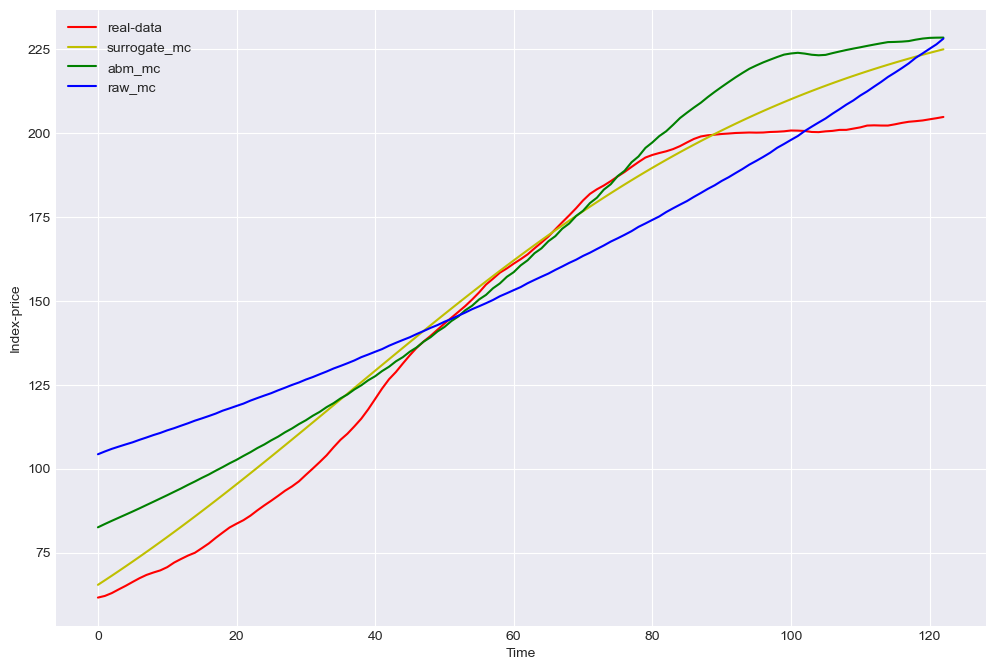

In [181]:
realdata = readData("sp")
#plt.figure(figsize=(12,8))
#t = range(0,123)
#plt.style.use('seaborn-darkgrid')
#plt.xlabel('Time')
#plt.ylabel('Index-price')
#plt.plot(t, realdata, "r", label='real-data')    
#plt.legend()
#plt.show()

if __name__ == "__main__":
    main()

In [86]:
 a = np.exp(np.random.normal(loc=0.2, scale=0.2/10.00, size=None))/10
print(a)

0.12275614770386334


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=740369, Fri Apr 19 19:15:36 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=592074, Fri Apr 19 19:15:37 2024)
[67.04127135818104, 0.05310343316397769, 0.06046010586974351, 214.8883145757101, 0.6046010586974351, 6.046010586974352]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=710374, Fri Apr 19 19:16:38 2024)
[61.59, 0.04, 0.09, 204.67, 0.1, 7]
Raw: 22.617301749616406 | MAS: 18.789778991232662
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=642653, Fri Apr 19 19:16:57 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=609695, Fri Apr 19 19:16:57 2024)
[68.44068161717247, 0.03595925336162593, 0.037872296620307284, 216.16078862290414, 0.37872296620307283, 3.7872296620307284]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=713806, Fri Apr 19 19:19:28 2024)
[61.59, 0.09, 0.06, 204.67, 0.4, 2]
Raw: 31.614199382269284 | MAS: 17.243580168534926
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimens

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=628079, Fri Apr 19 23:29:16 2024)
[66.12425484720967, 0.011255789352563222, 0.001223828918837226, 211.43103396512225, 0.012238289188372262, 0.1223828918837226]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=610835, Fri Apr 19 23:29:30 2024)
[61.59, 0.06, 0.02, 204.67, 0.6, 6]
Raw: 12.648209879197976 | MAS: 47.34411055969475
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=689361, Fri Apr 19 23:29:32 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=653085, Fri Apr 19 23:29:32 2024)
[67.4099991077501, 0.02291564179691257, 0.01860959753390981, 216.37658826348715, 0.1860959753390981, 1.860959753390981]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=750377, Fri Apr 19 23:29:39 2024)
[61.59, 0.09, 0.06, 204.67, 0.9, 1]
Raw: 33.21850172317918 | MAS: 9.803329101171759
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=657032, Fri Apr 19 23:29:45 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimensi

/var/folders/dp/49vqv64x0pj6v797ql09fj7h0000gn/T/ipykernel_45556/2183323648.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,8))


(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=714442, Fri Apr 19 23:37:10 2024)
[61.59, 0.02, 0.09, 204.67, 0.3, 9]
Raw: 14.050710290540867 | MAS: 6.971274822885275
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=736477, Fri Apr 19 23:37:11 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=709223, Fri Apr 19 23:37:11 2024)
[68.41, 0.05, 0.03, 215.33, 0.3, 3.0]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=640425, Fri Apr 19 23:37:13 2024)
[61.59, 0.09, 0.01, 204.67, 0.1, 1]
Raw: 19.473561613007902 | MAS: 13.040304275668639
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=738241, Fri Apr 19 23:37:14 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=613852, Fri Apr 19 23:37:16 2024)
[65.03008923941516, 0.011288465996041396, 4.489096220598914e-07, 210.06023137050332, 4.489096220598914e-06, 4.489096220598914e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=721255, Fri Apr 19 23:37:21 2024)
[61.59, 0.07, 0.07, 204.67, 0.

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=745023, Sat Apr 20 00:07:44 2024)
[69.64139197949505, 0.0409793569809616, 0.05779346127668171, 220.27230239425197, 0.5779346127668171, 5.779346127668171]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=721027, Sat Apr 20 00:07:53 2024)
[61.59, 0.03, 0.1, 204.67, 0.4, 4]
Raw: 14.049186667246573 | MAS: 19.410762308519292
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=709444, Sat Apr 20 00:09:08 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=664591, Sat Apr 20 00:09:09 2024)
[67.1890888406242, 0.06140010923758971, 0.07259321499401862, 219.54535663948735, 0.7259321499401862, 7.259321499401862]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=697691, Sat Apr 20 00:09:09 2024)
[61.59, 0.09, 0.03, 204.67, 0.2, 6]
Raw: 33.08868736409926 | MAS: 64.350925164569
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=727003, Sat Apr 20 00:09:30 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (se

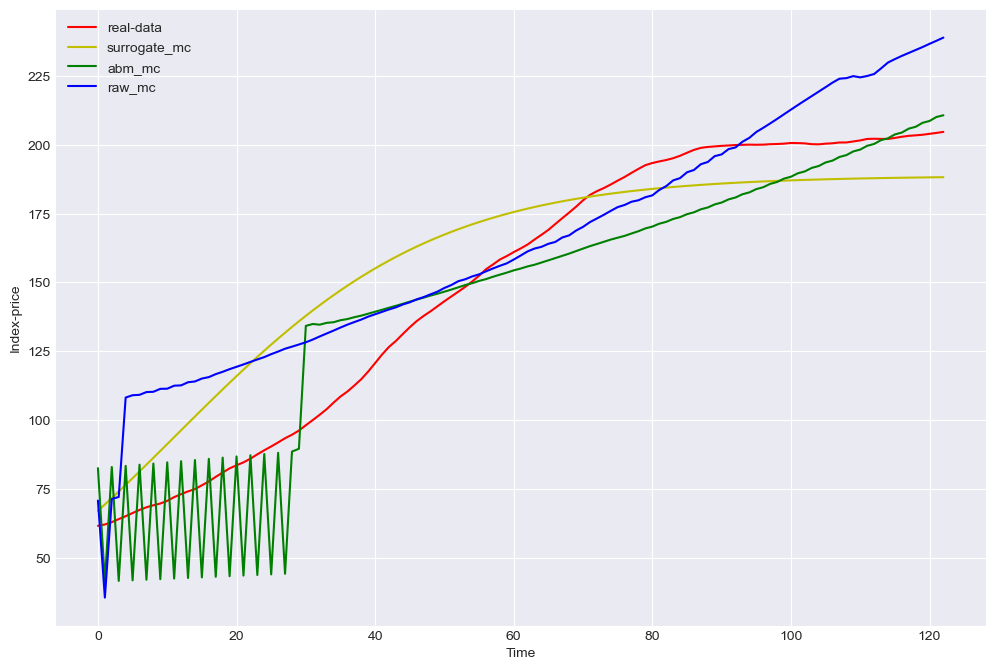

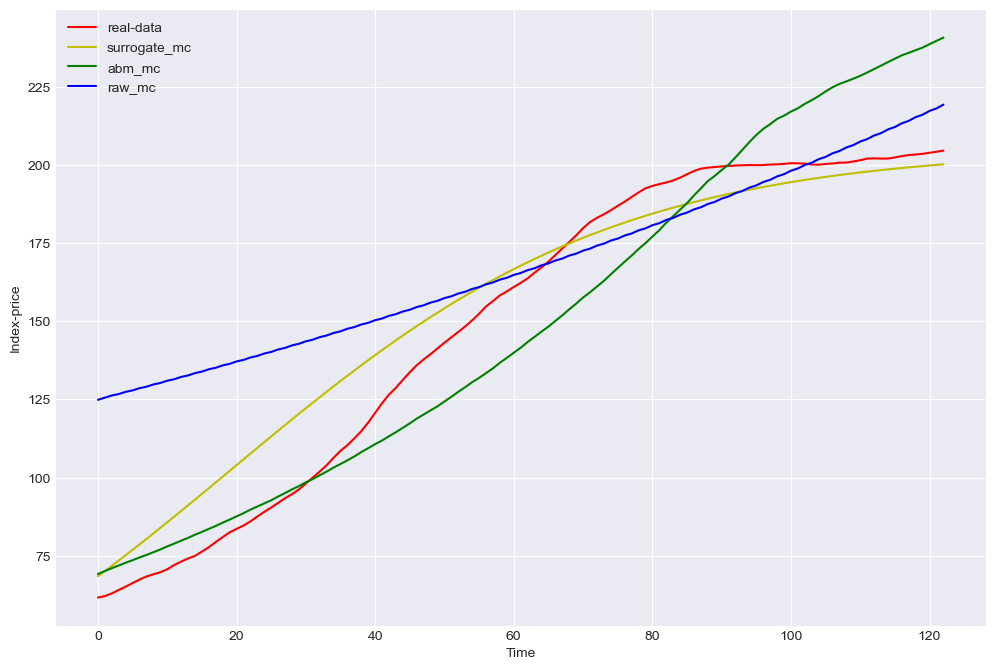

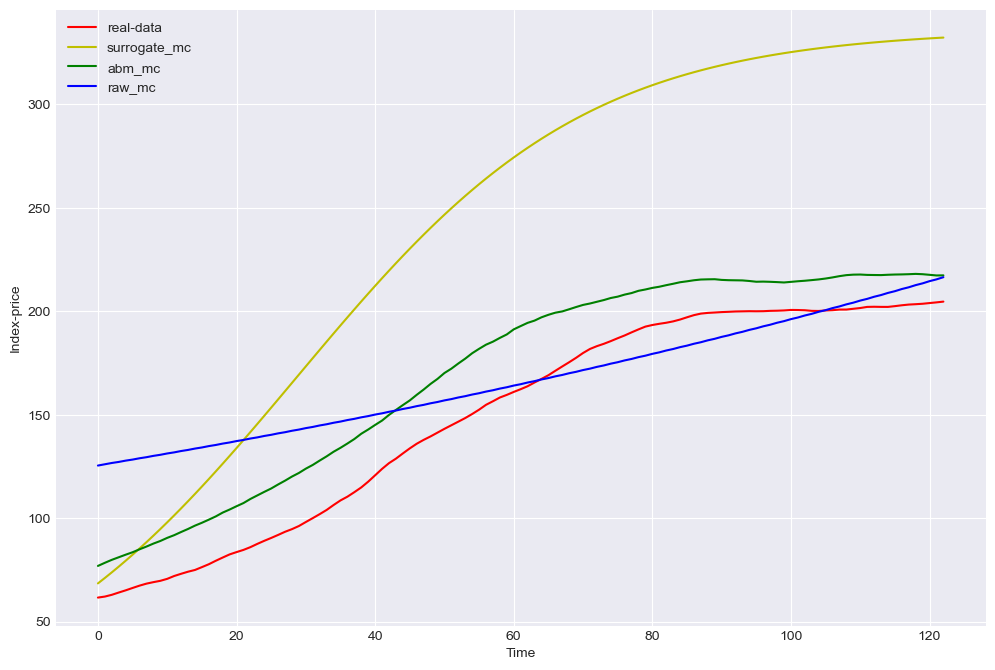

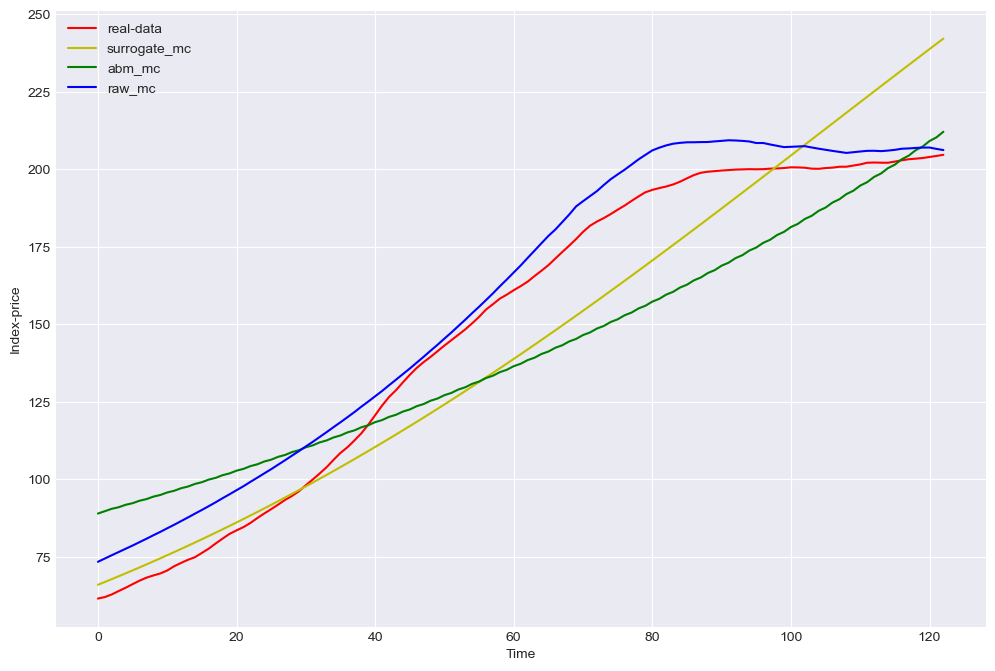

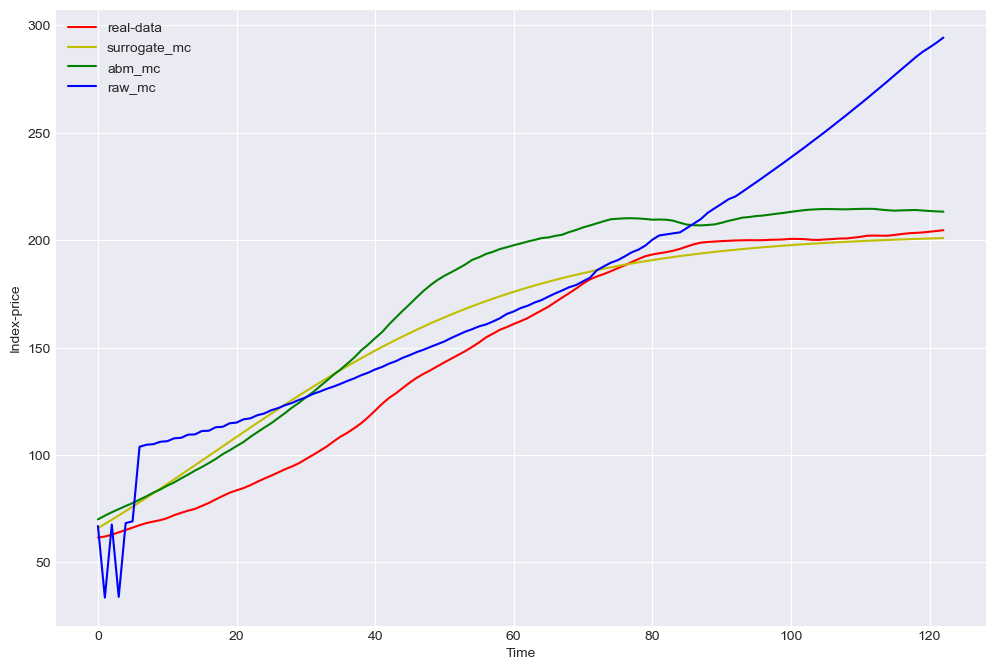

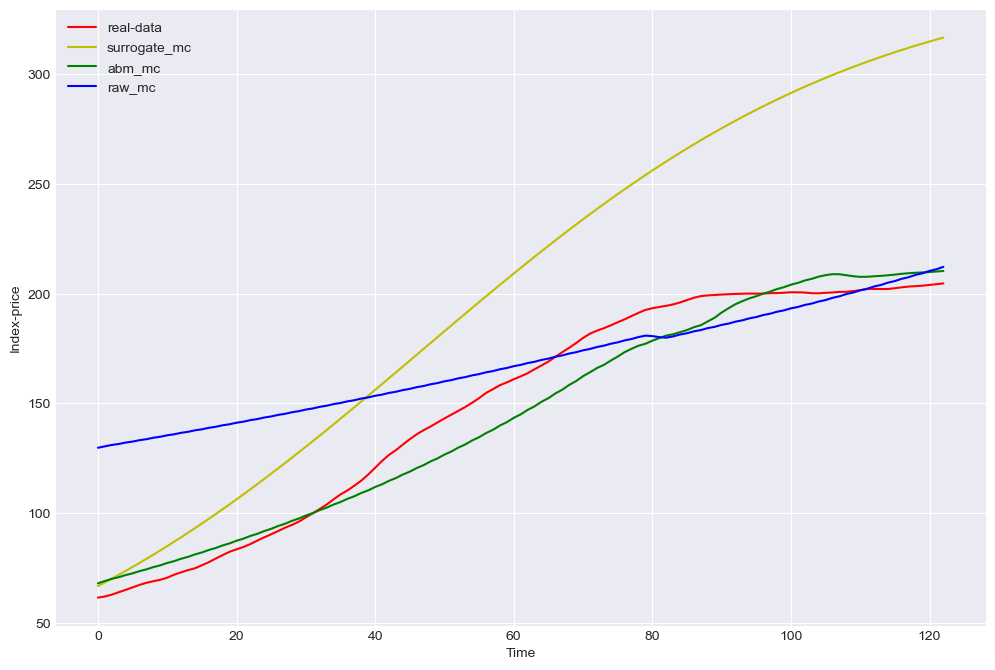

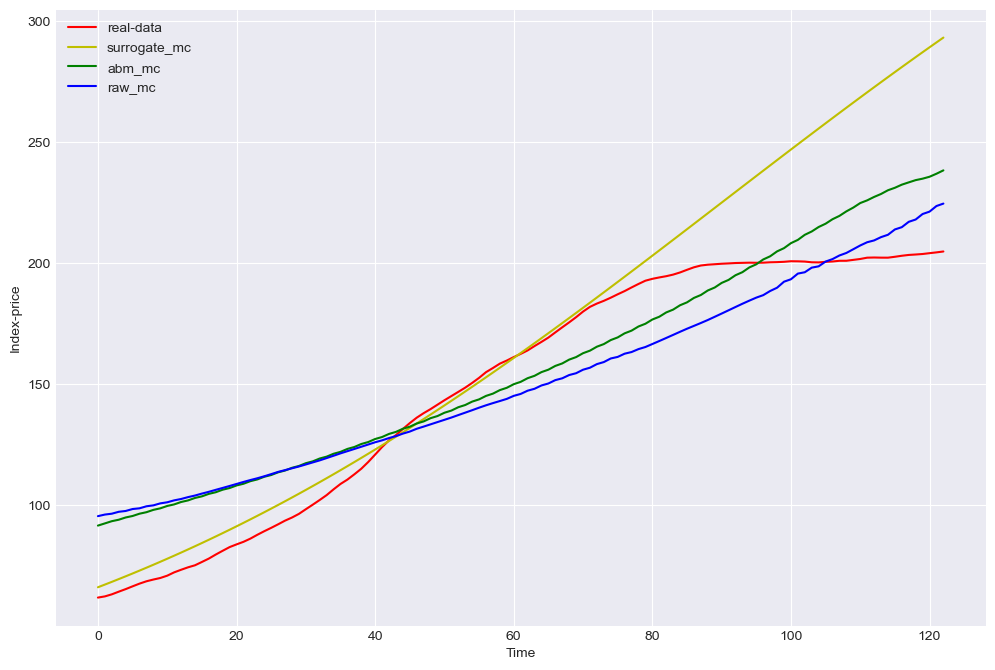

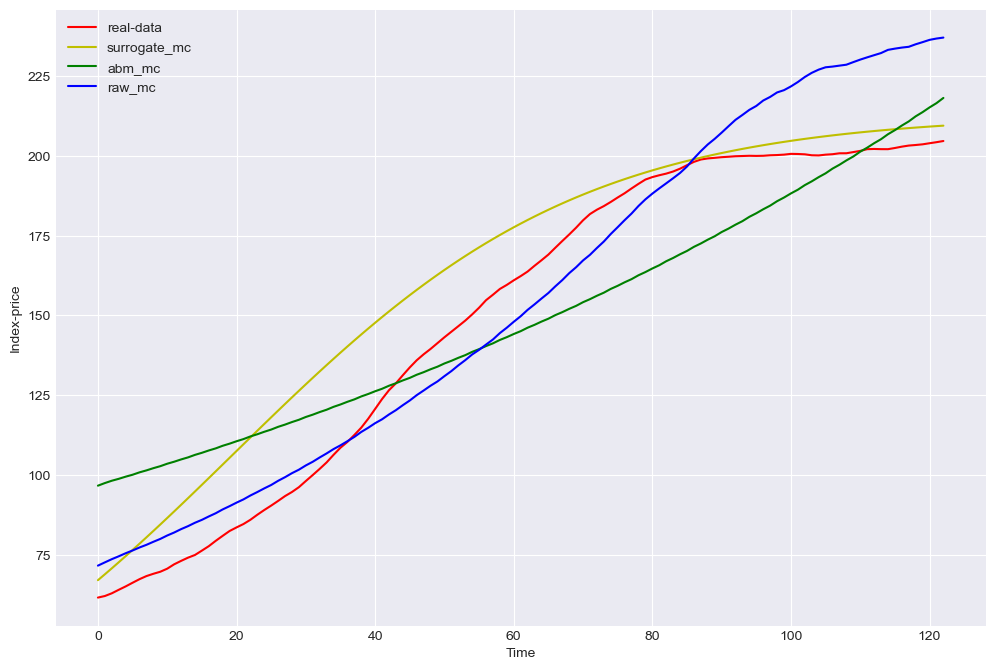

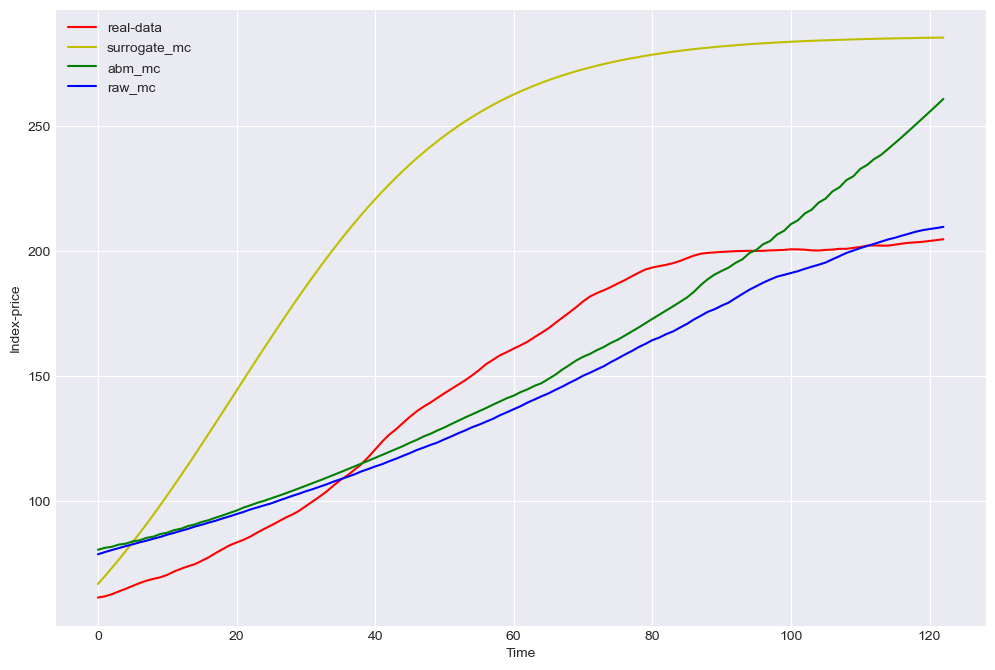

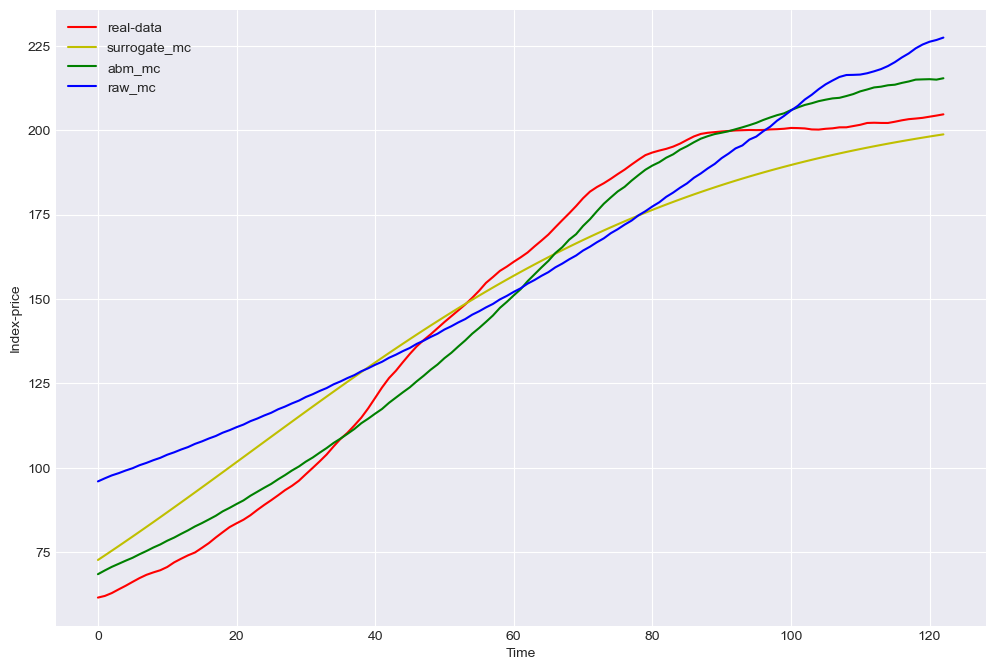

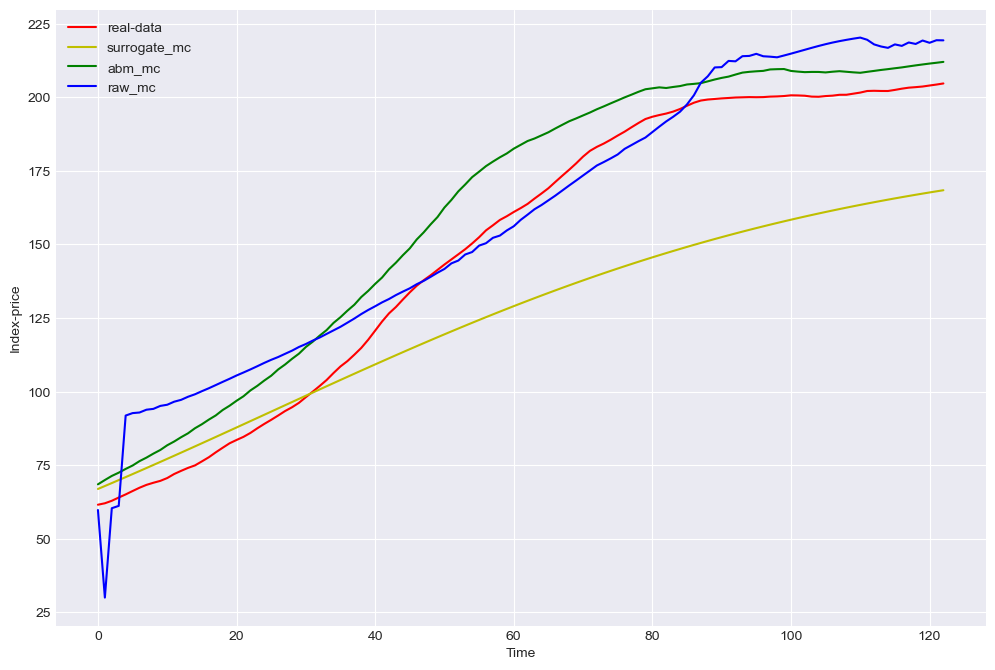

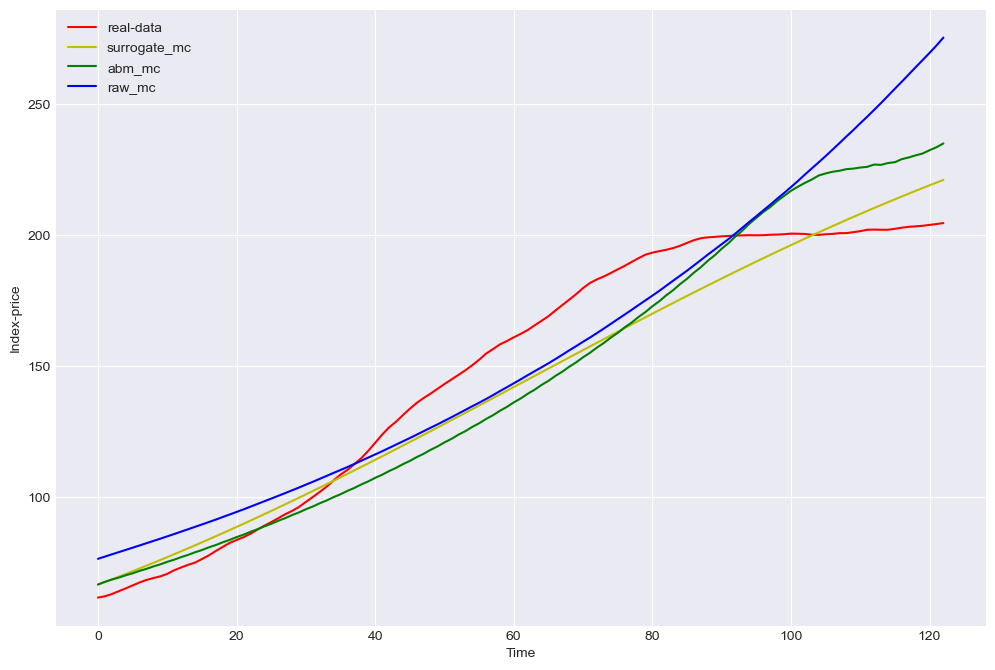

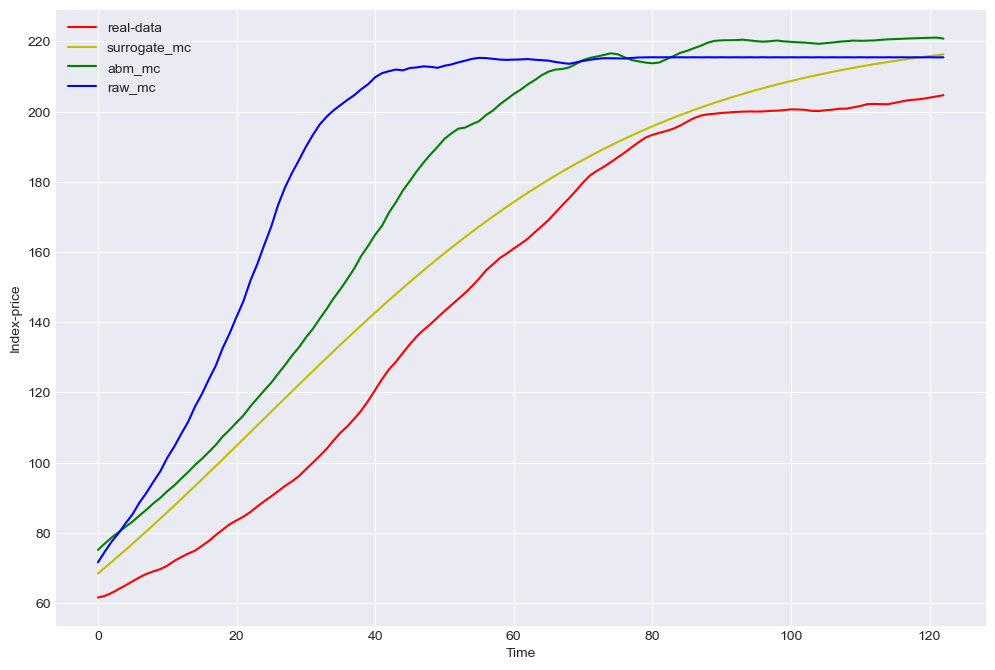

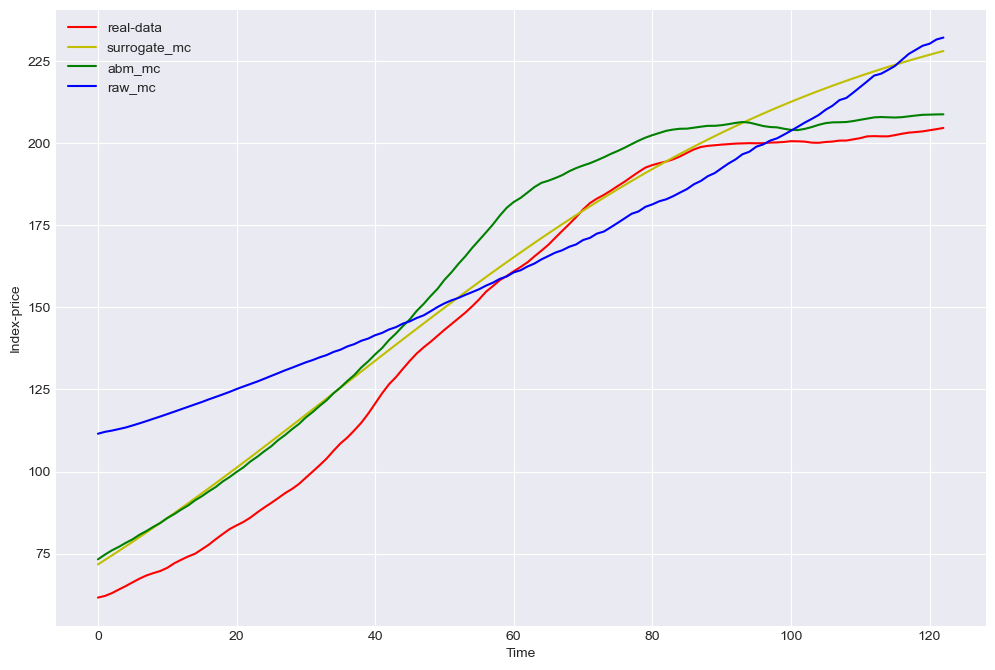

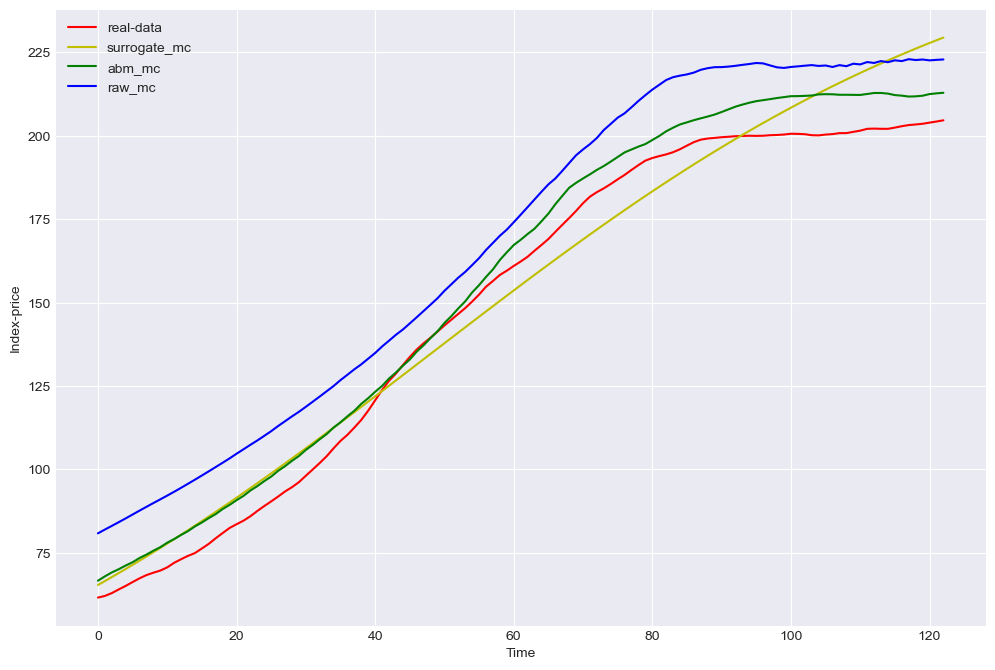

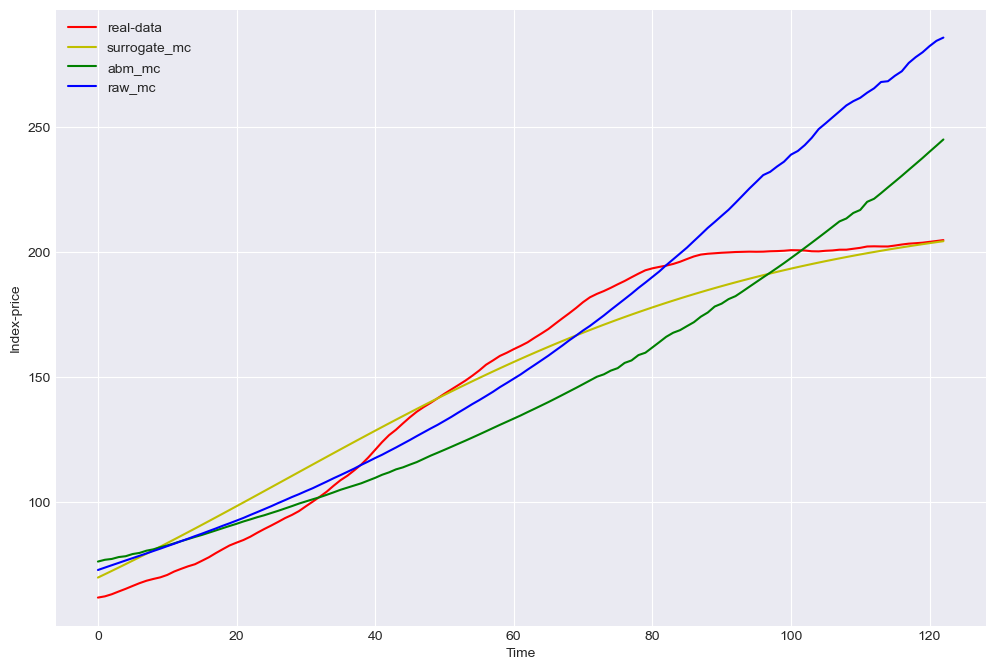

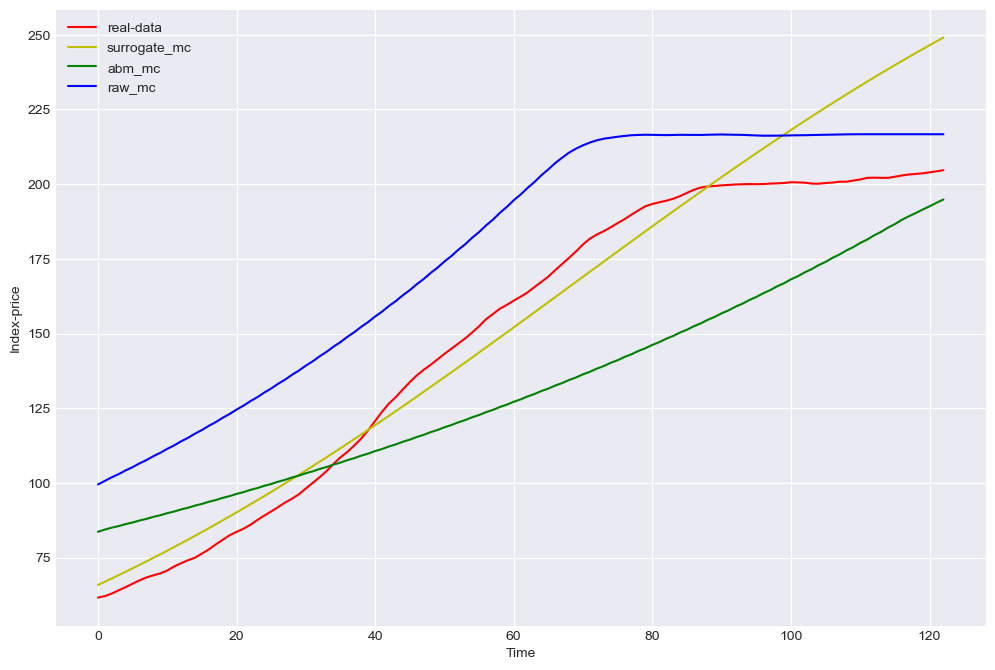

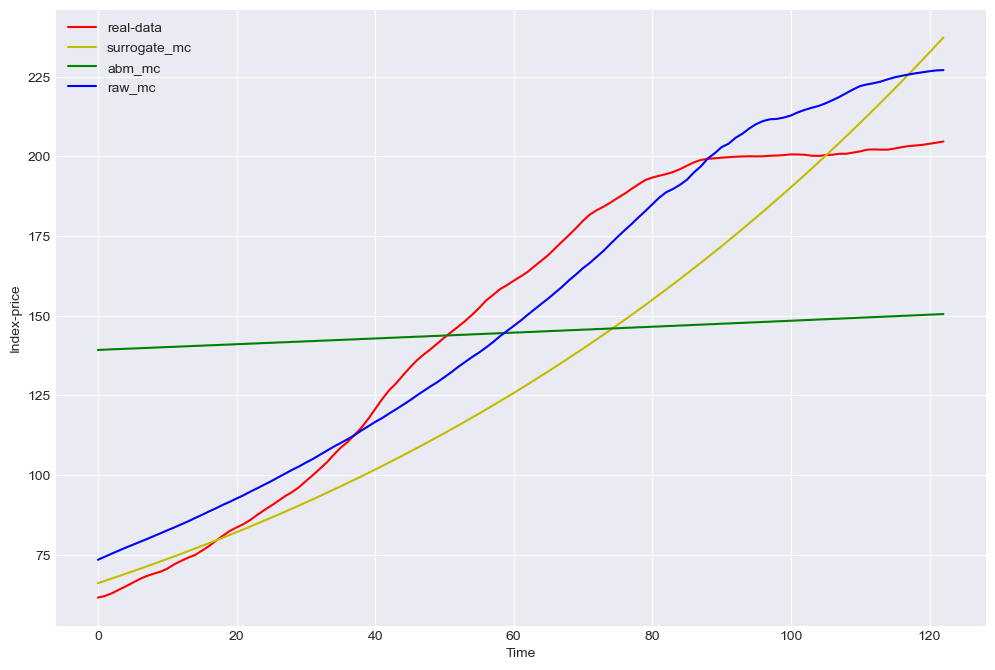

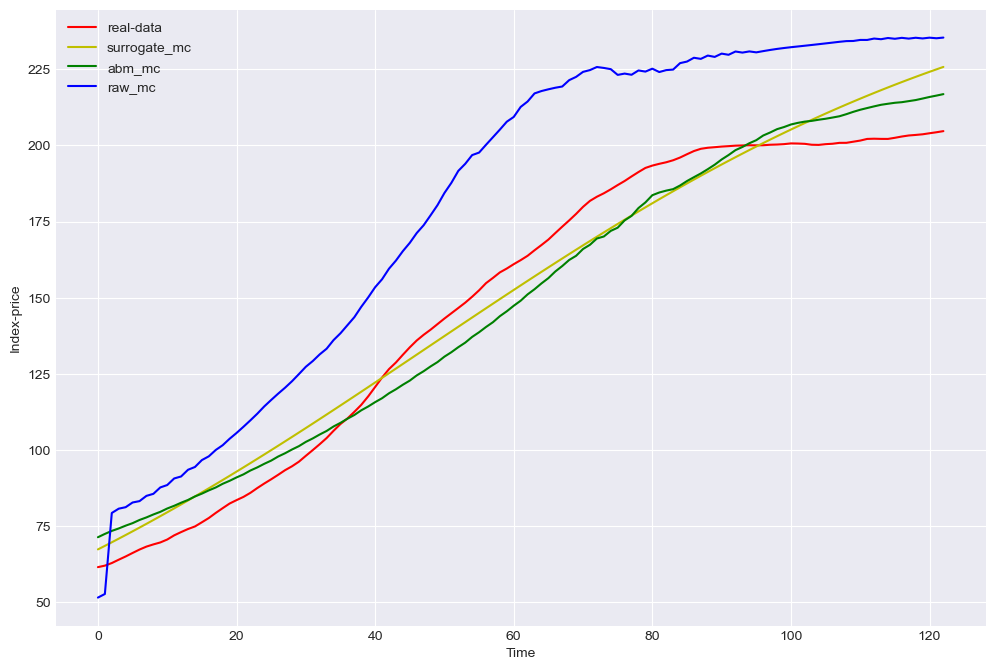

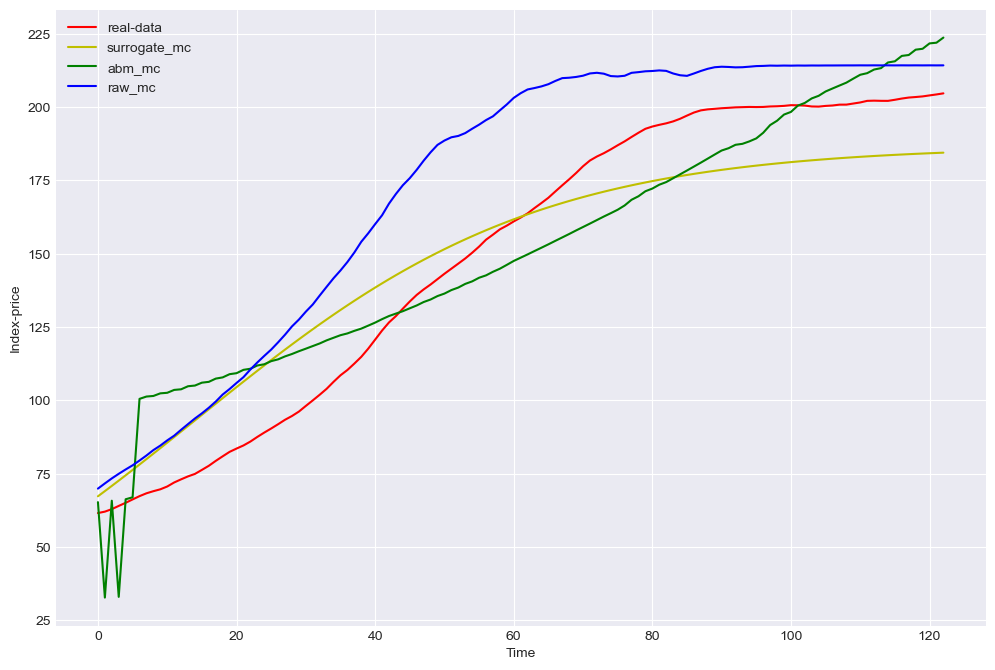

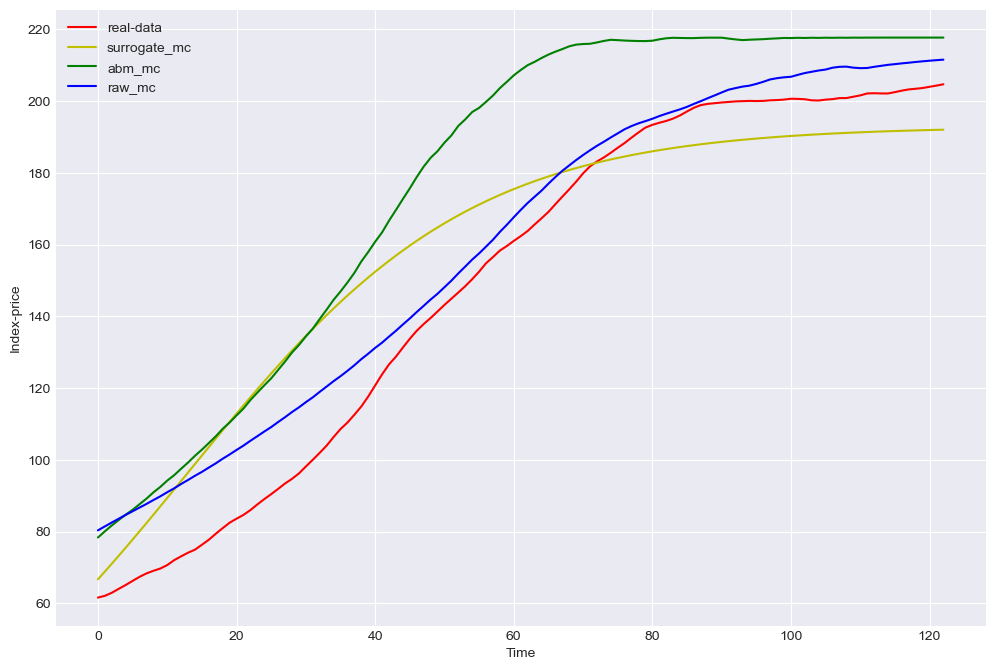

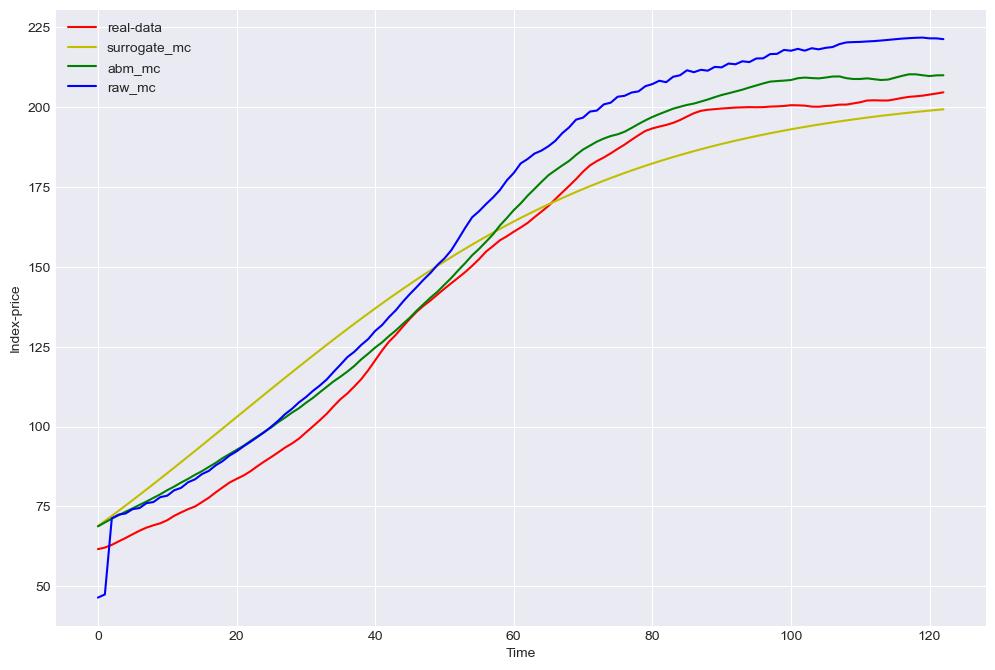

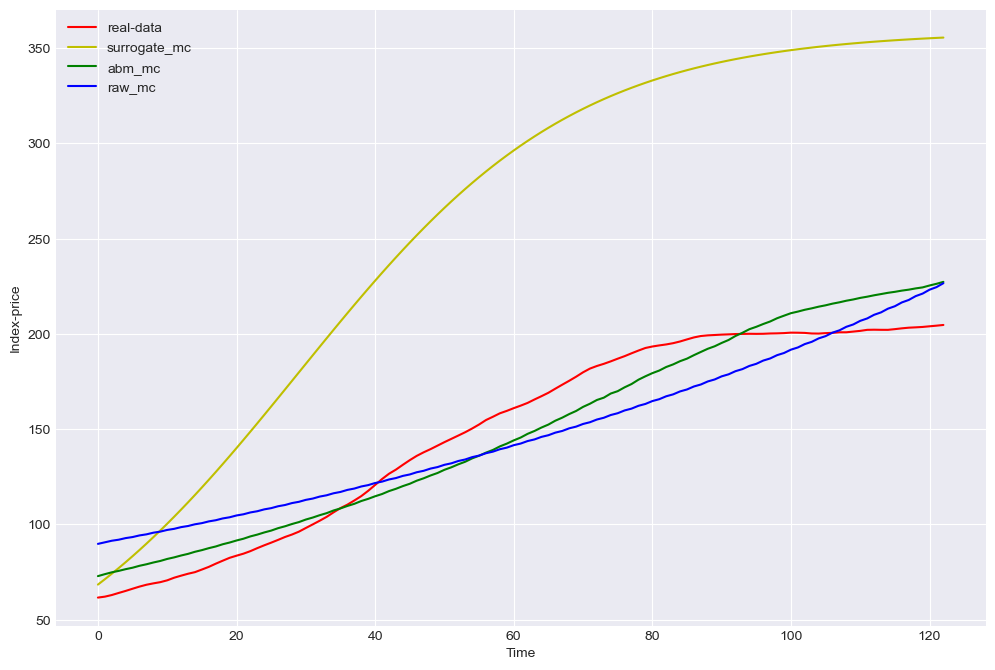

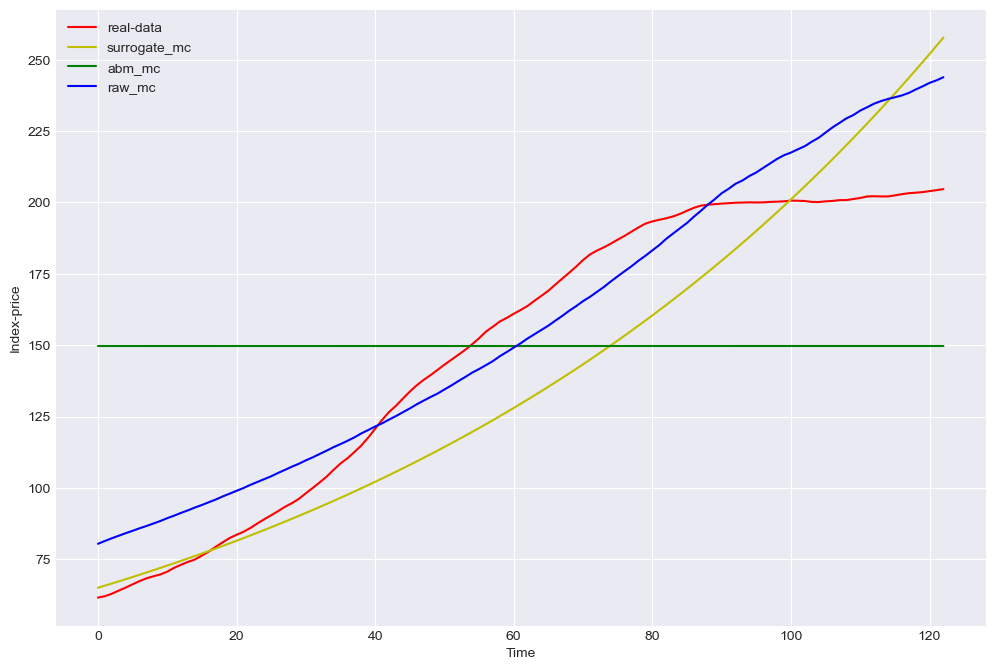

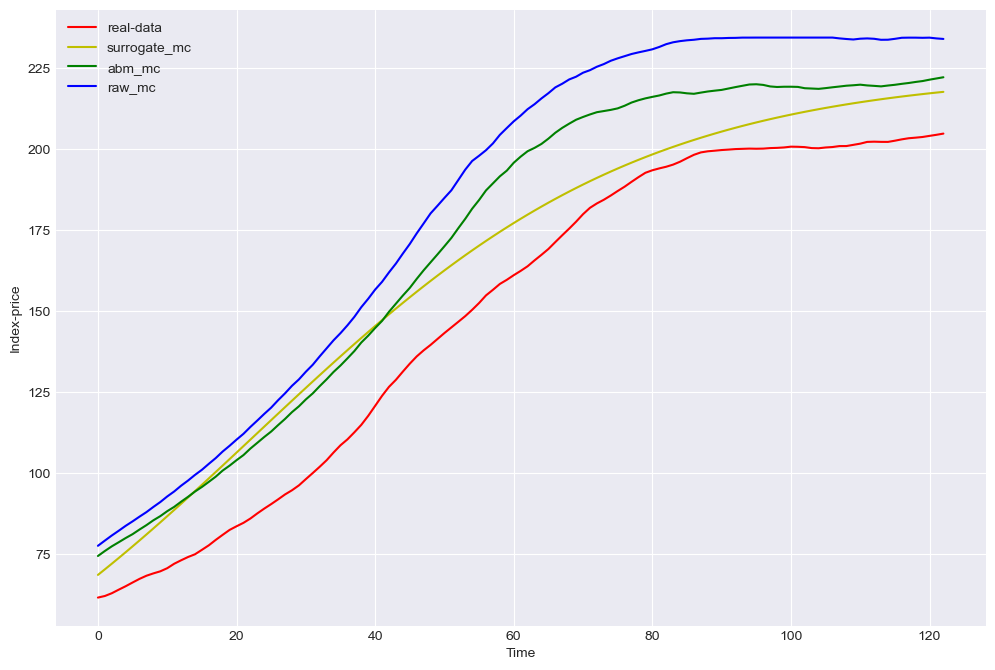

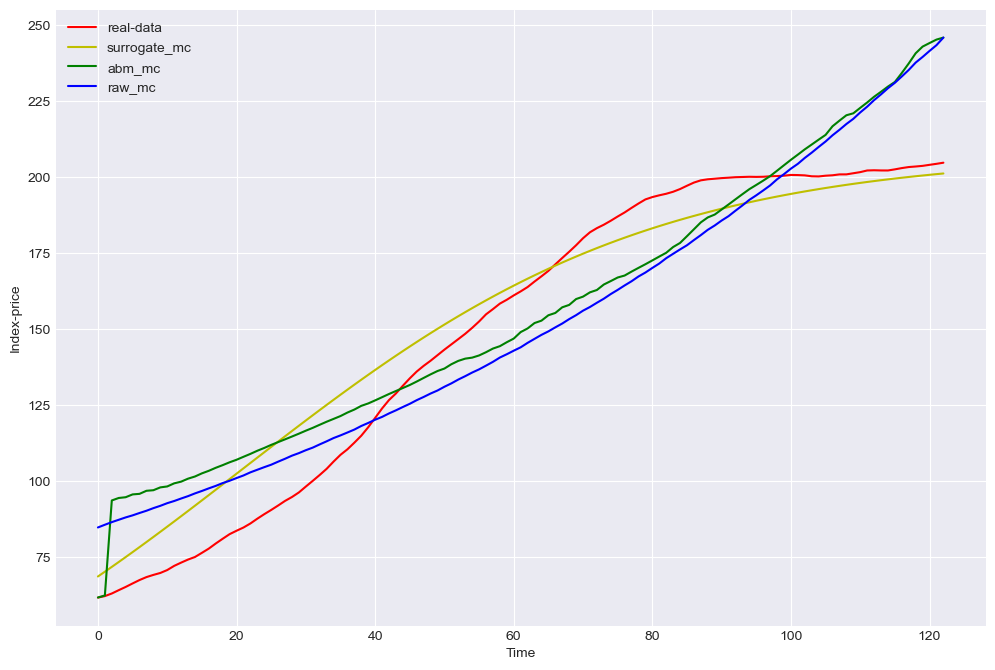

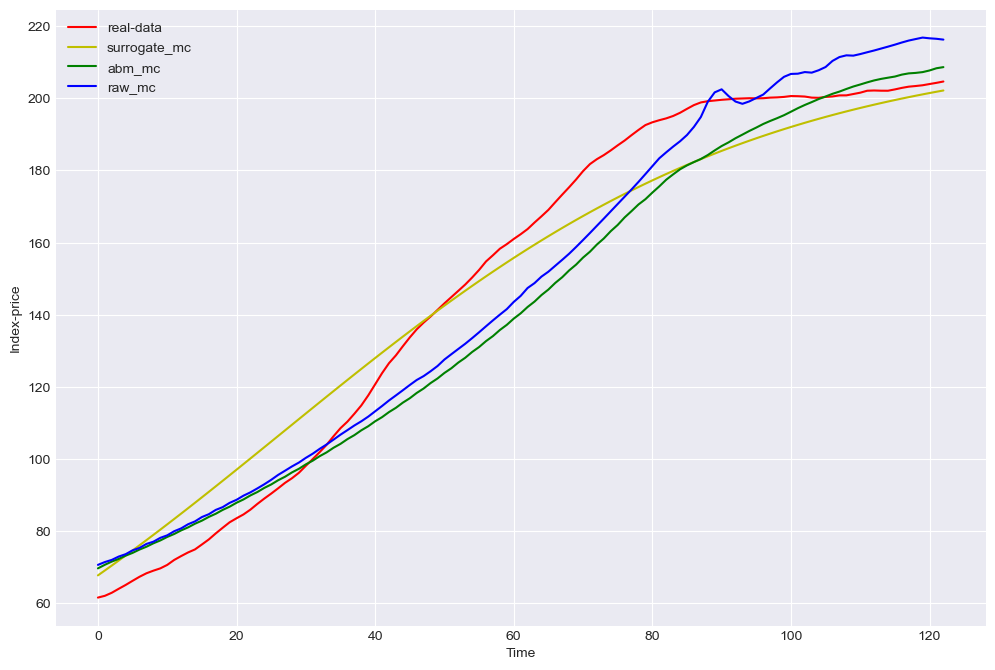

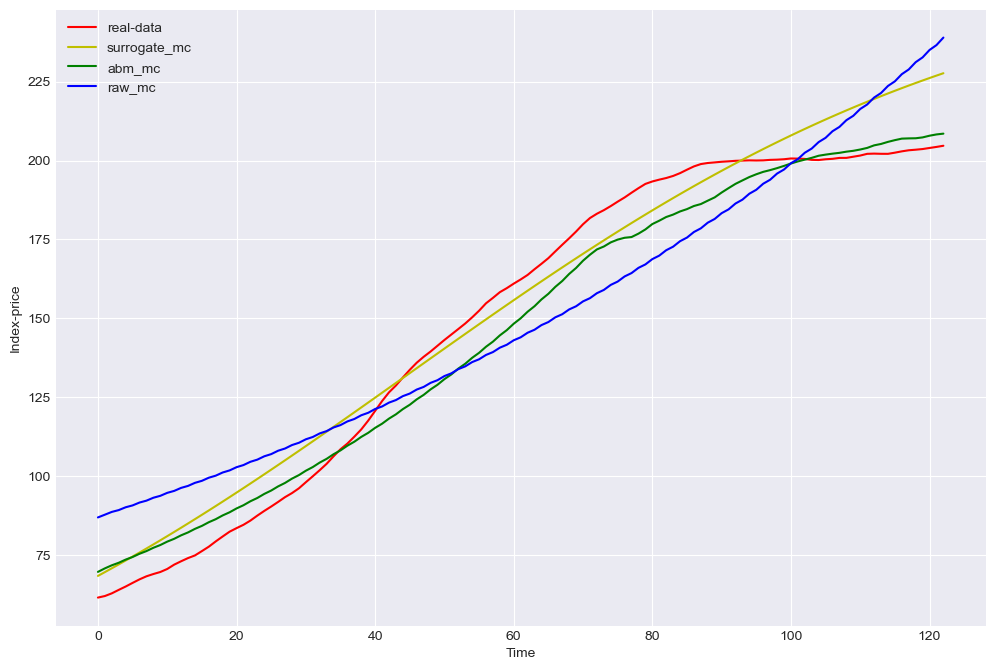

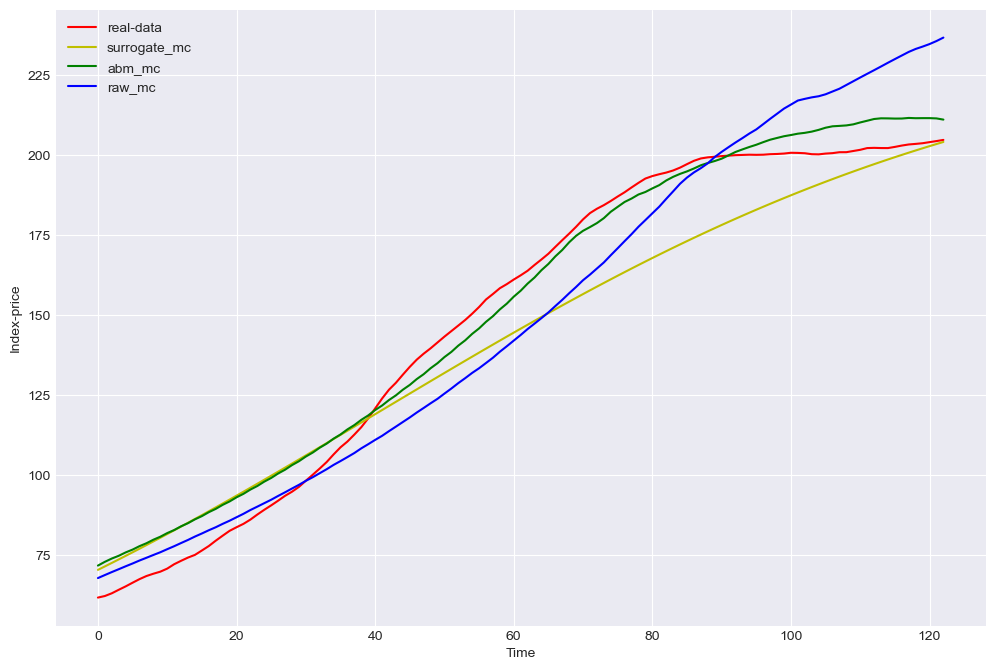

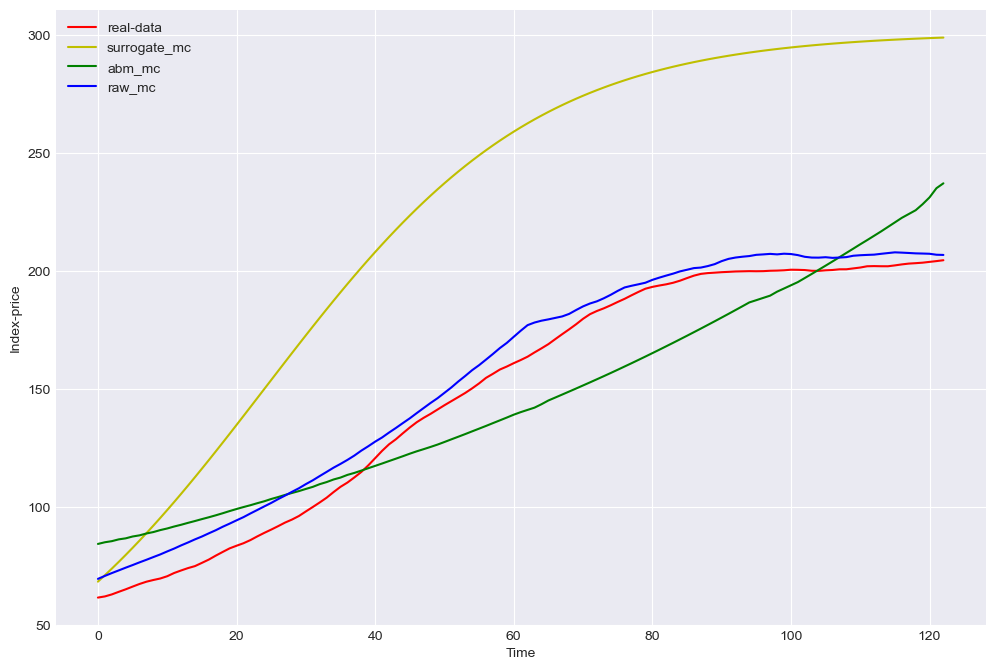

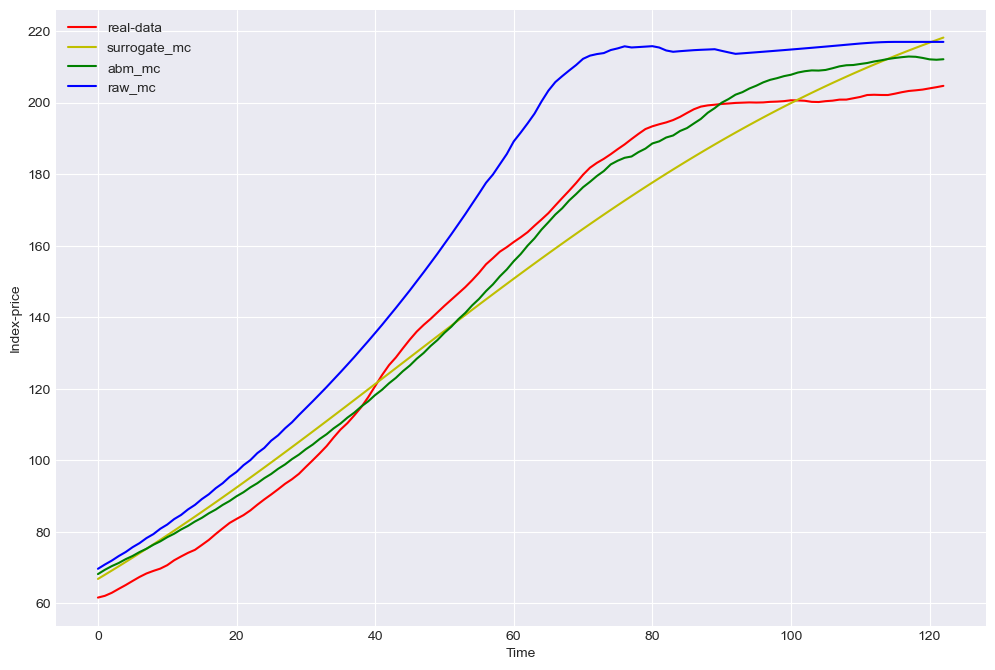

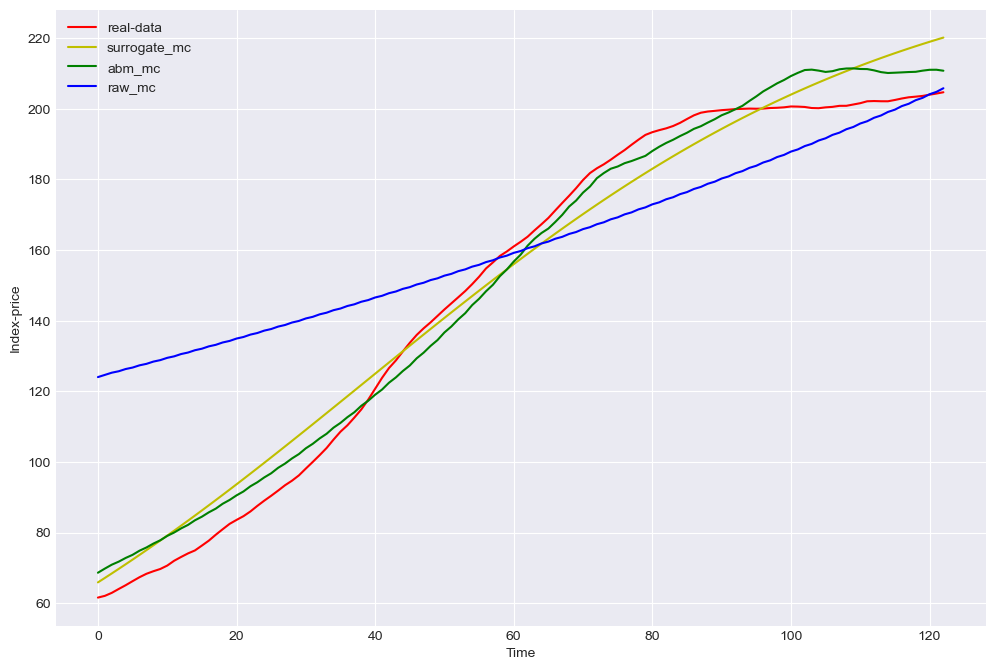

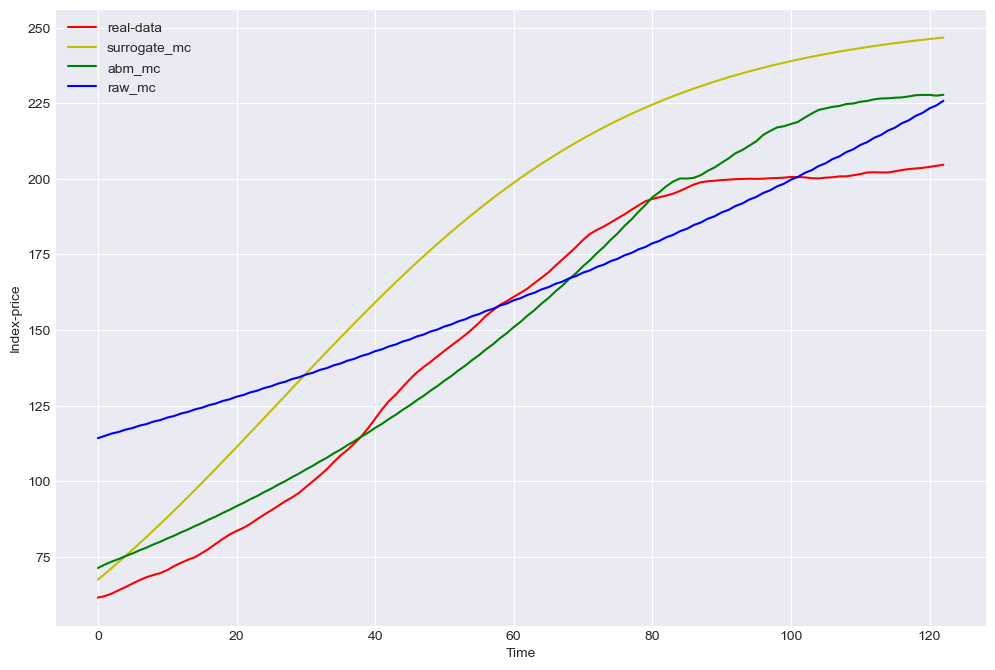

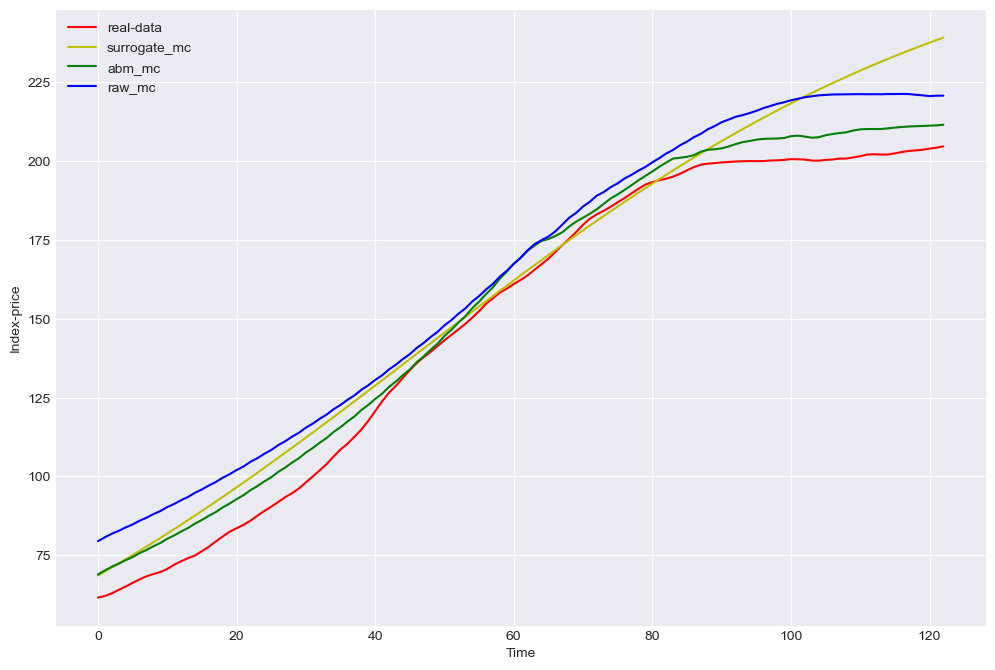

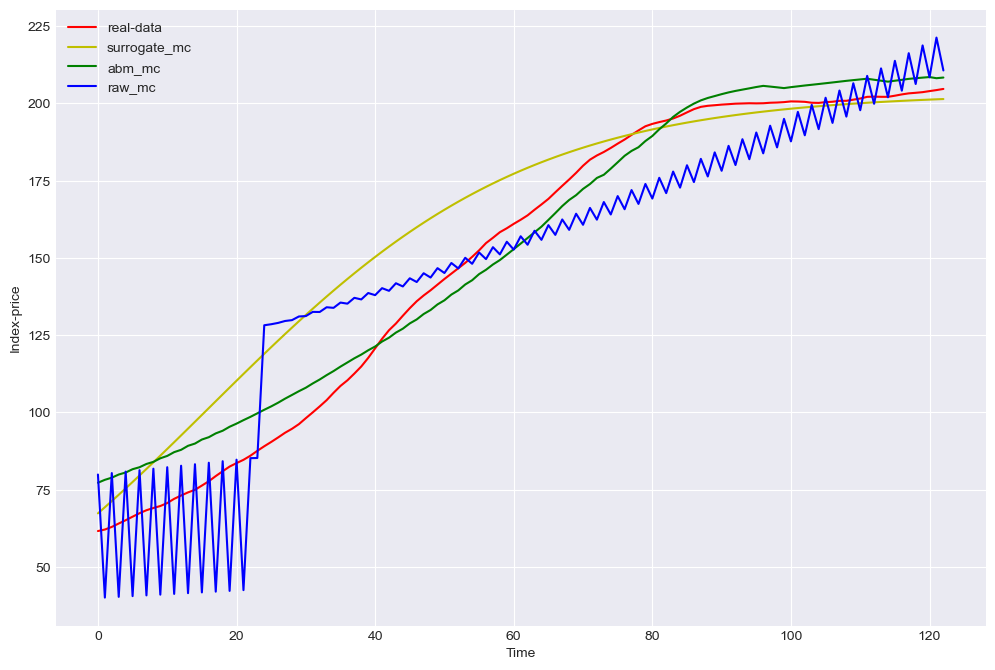

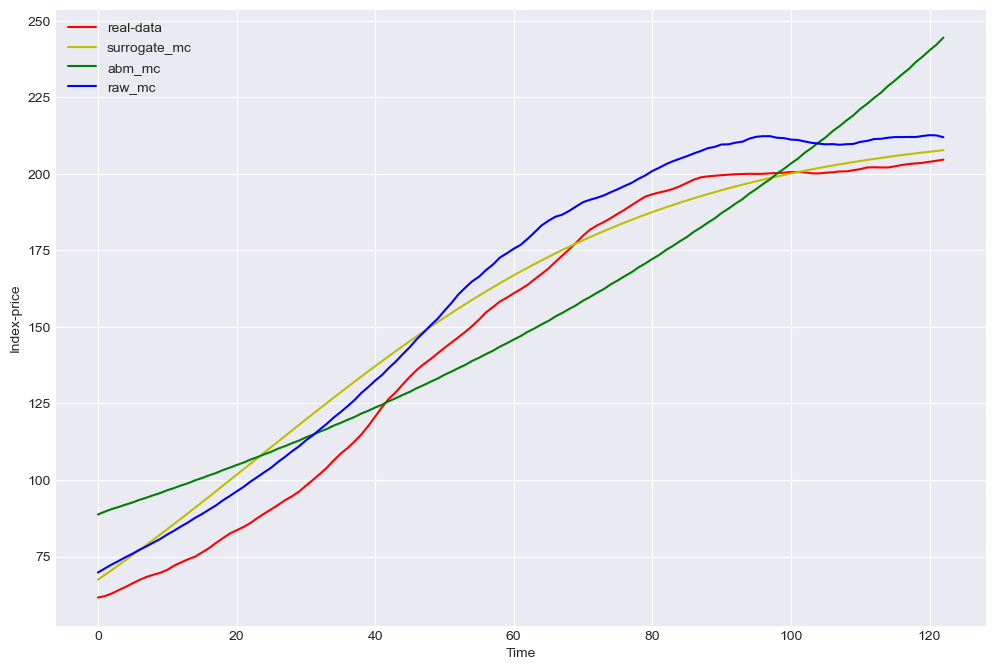

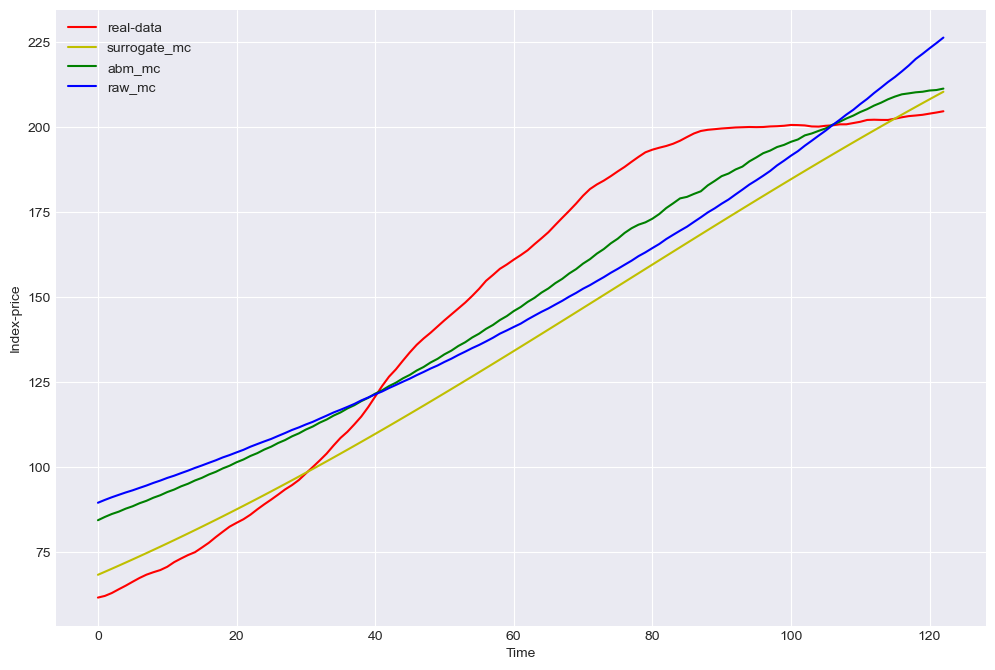

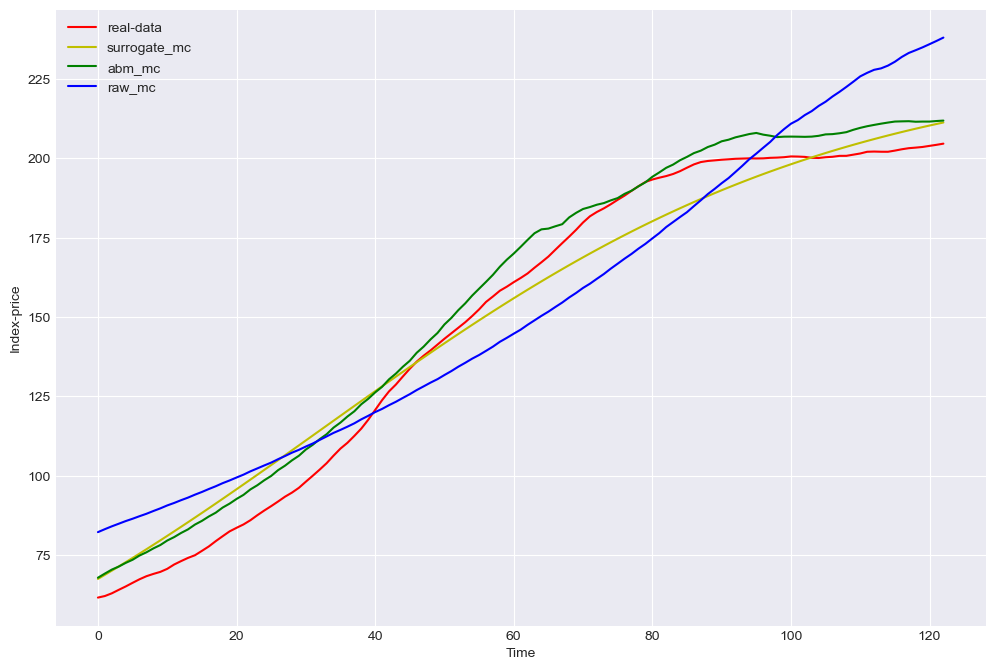

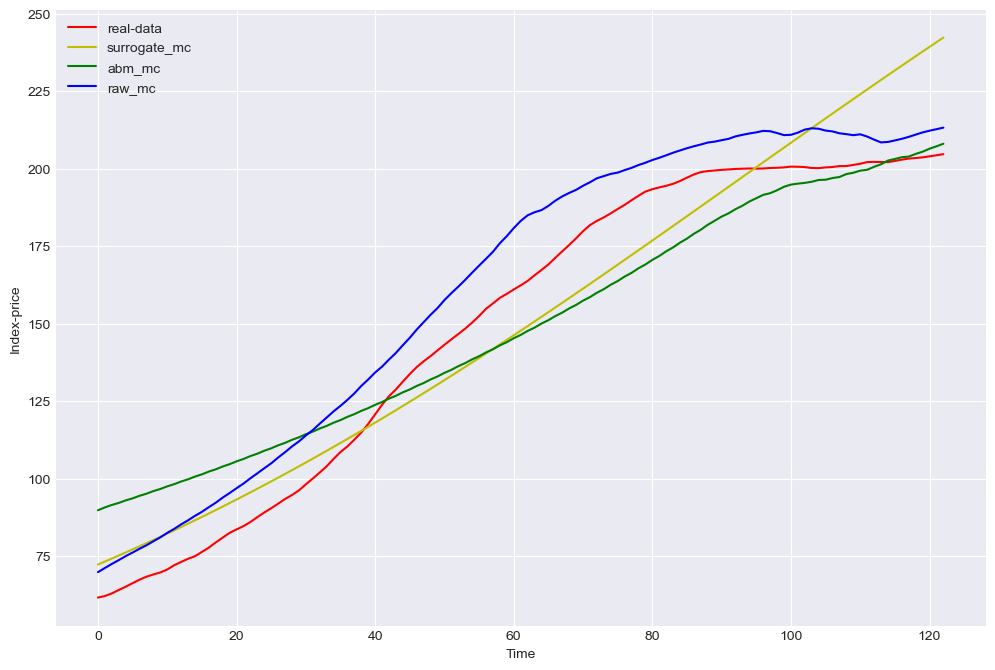

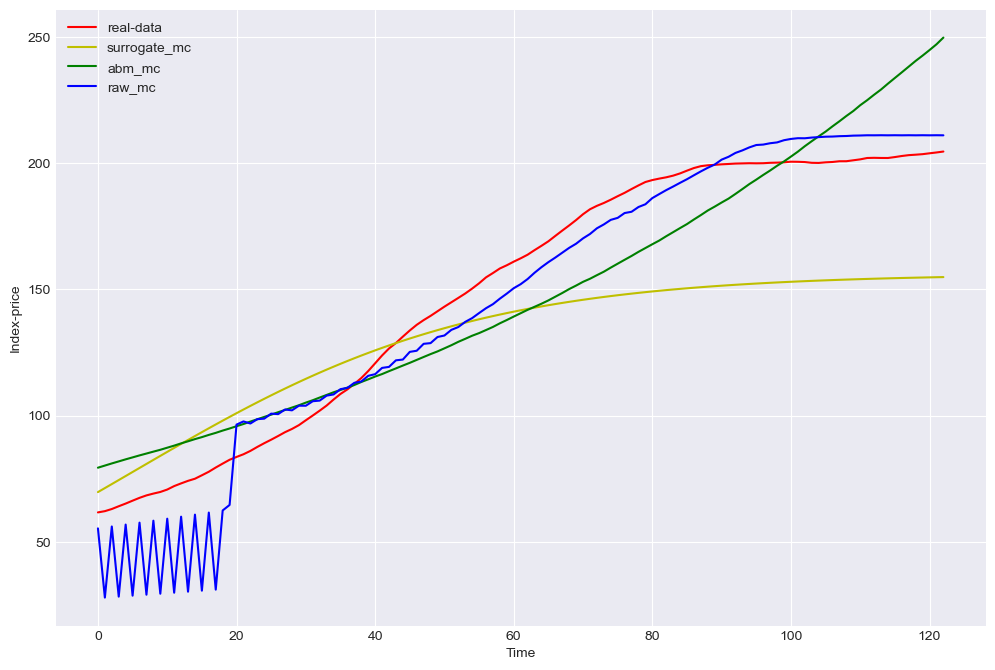

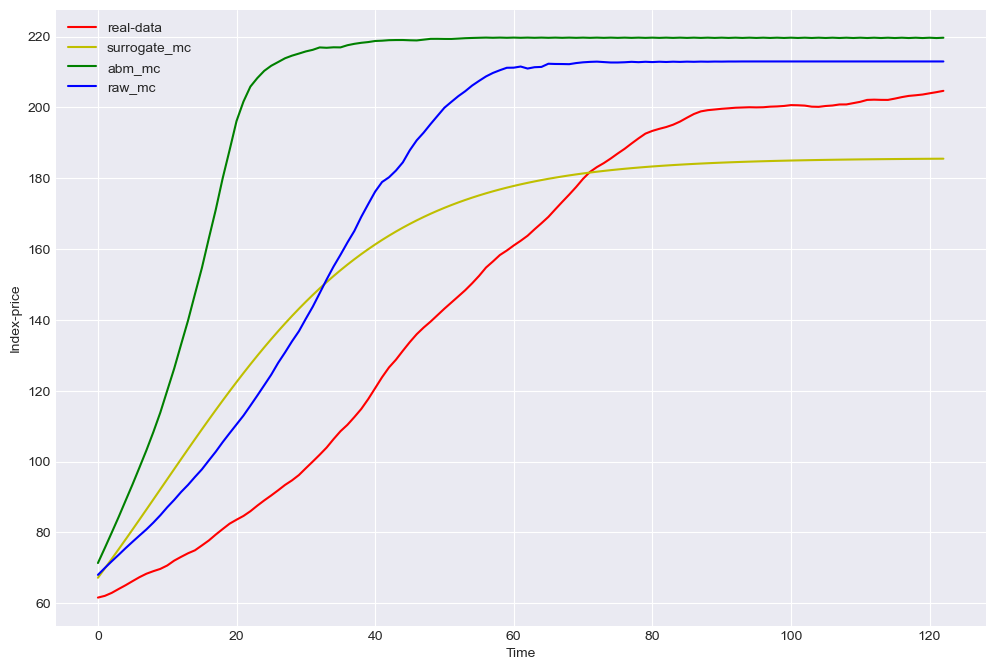

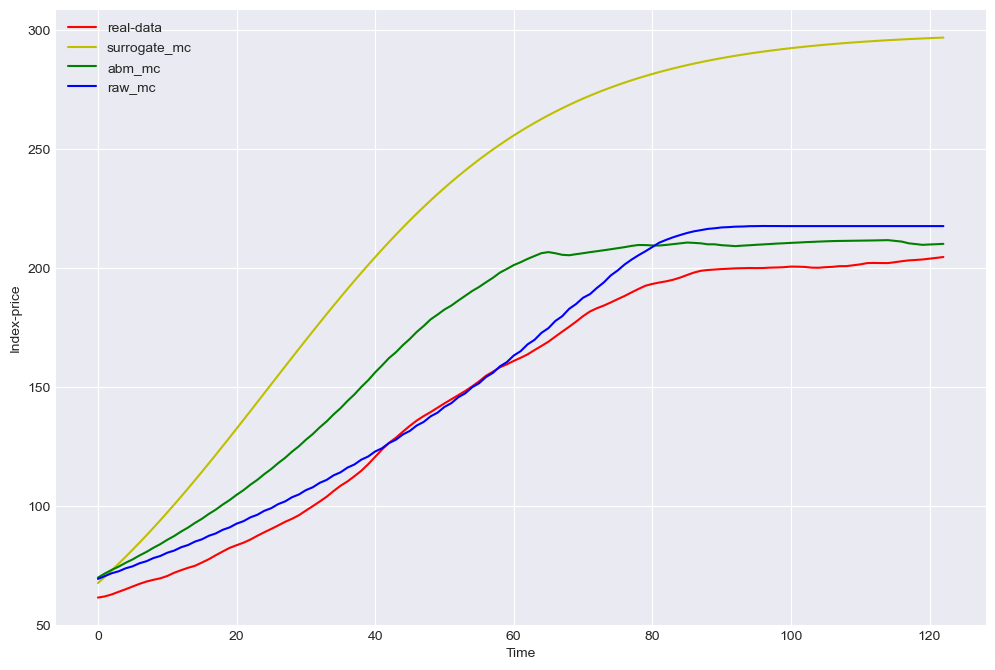

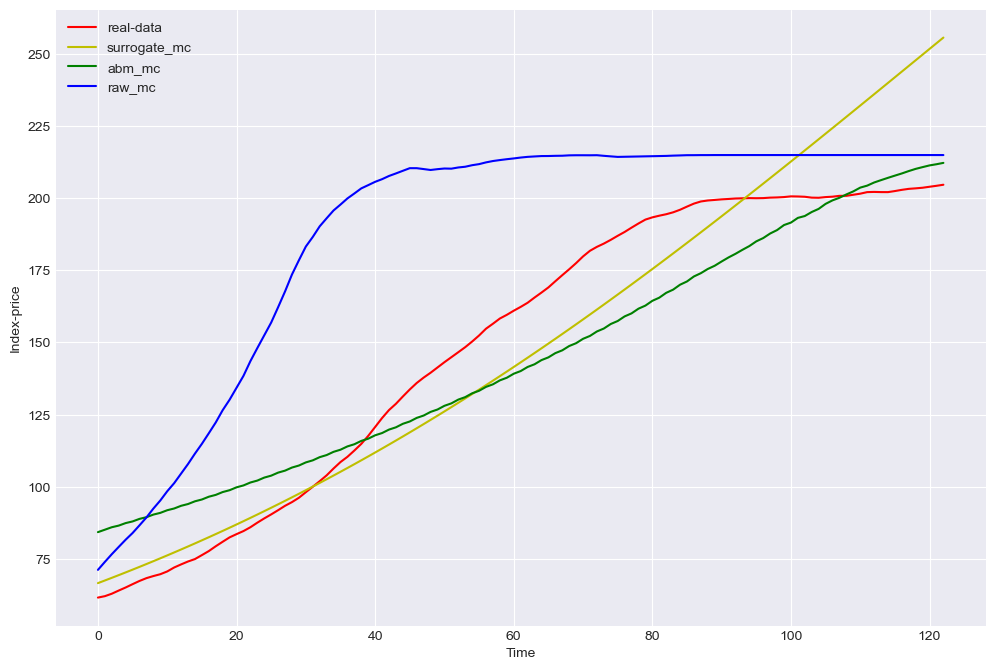

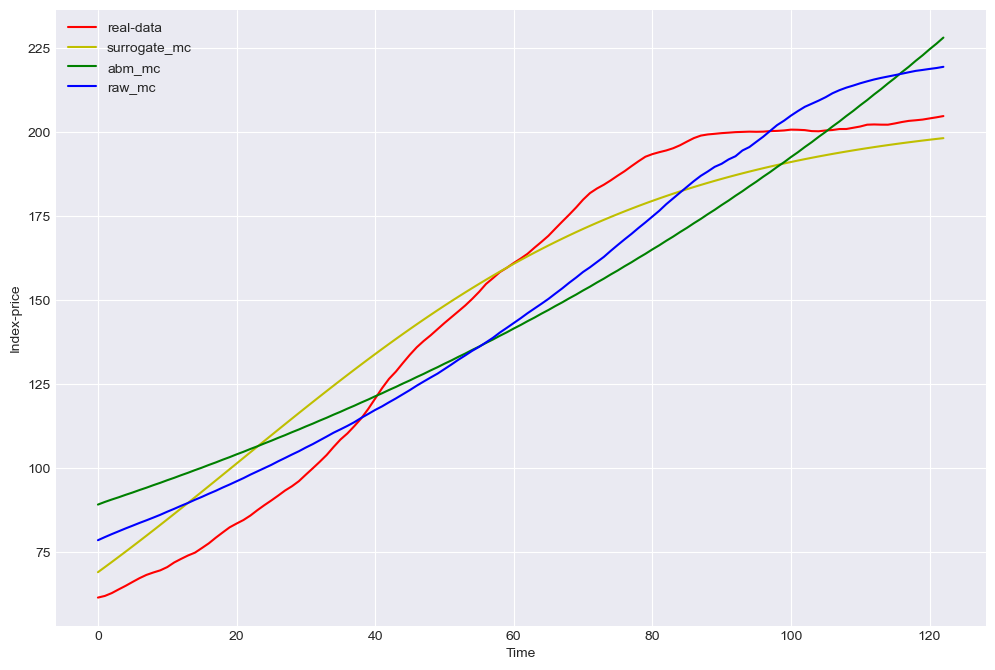

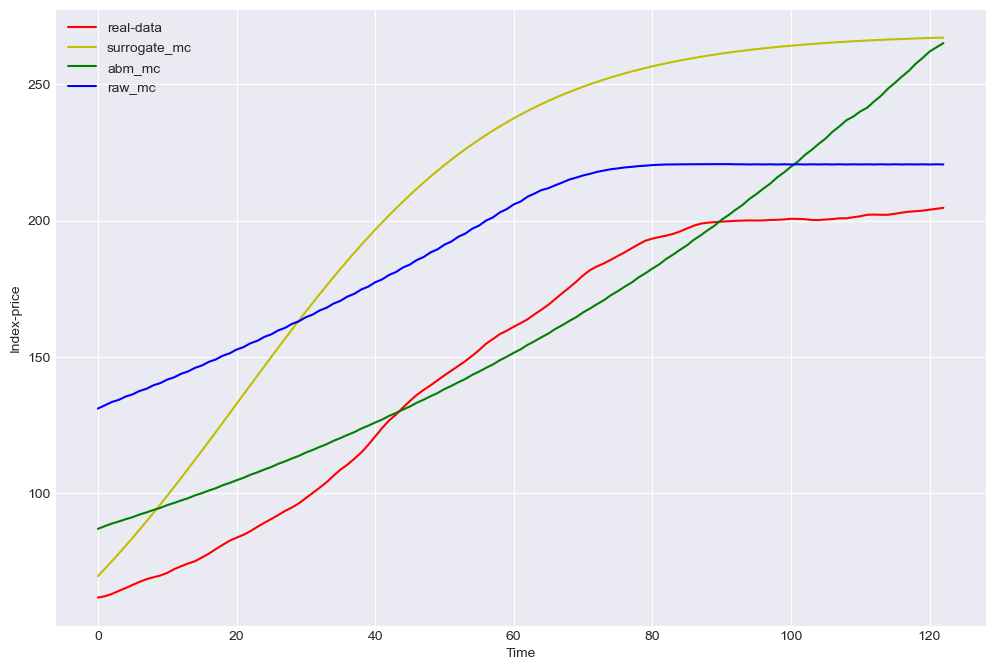

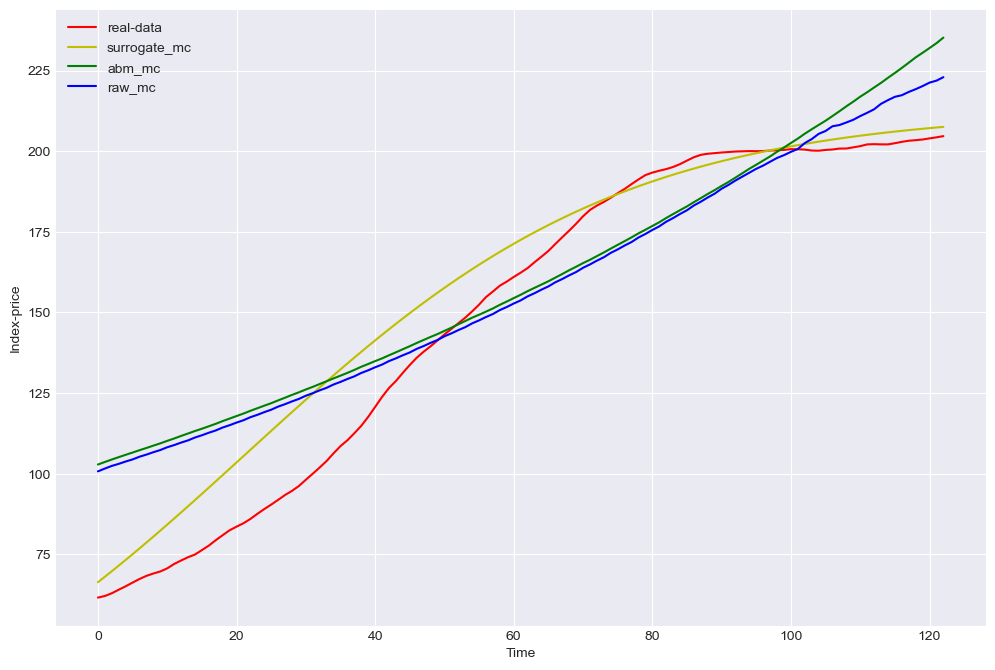

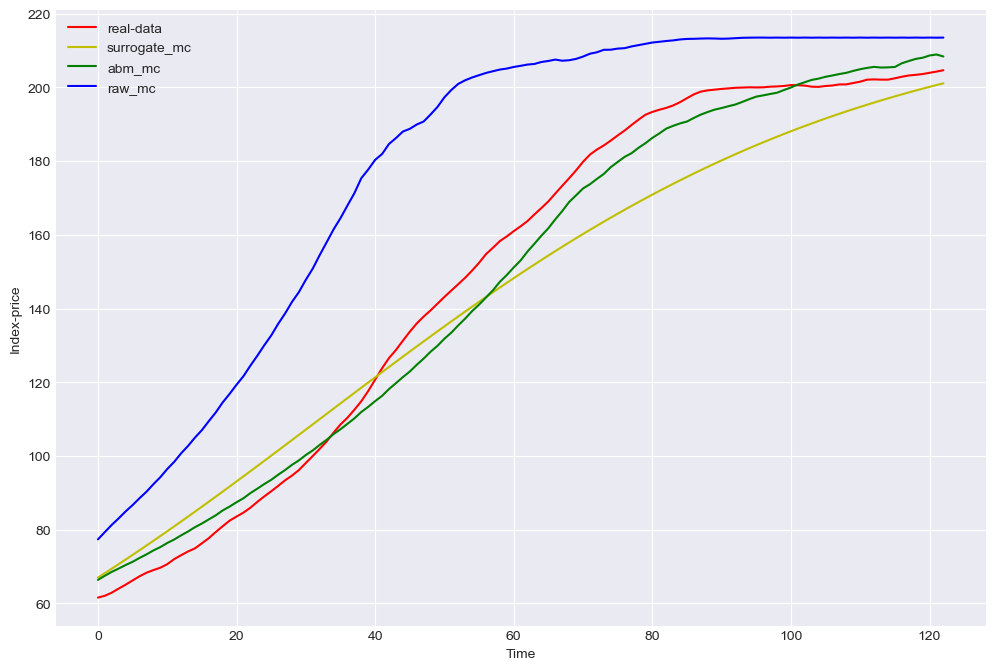

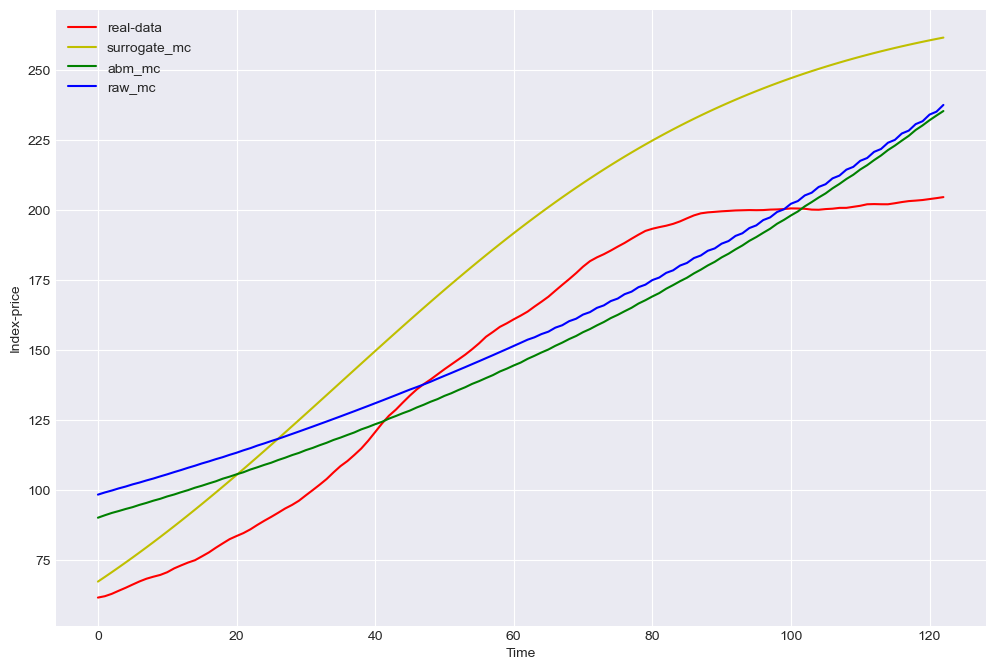

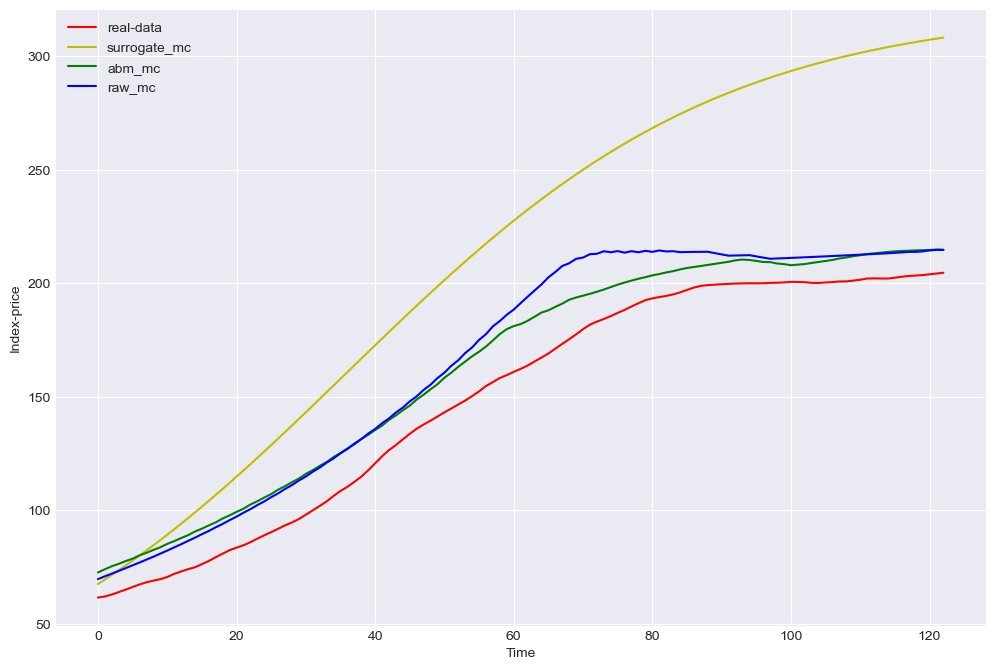

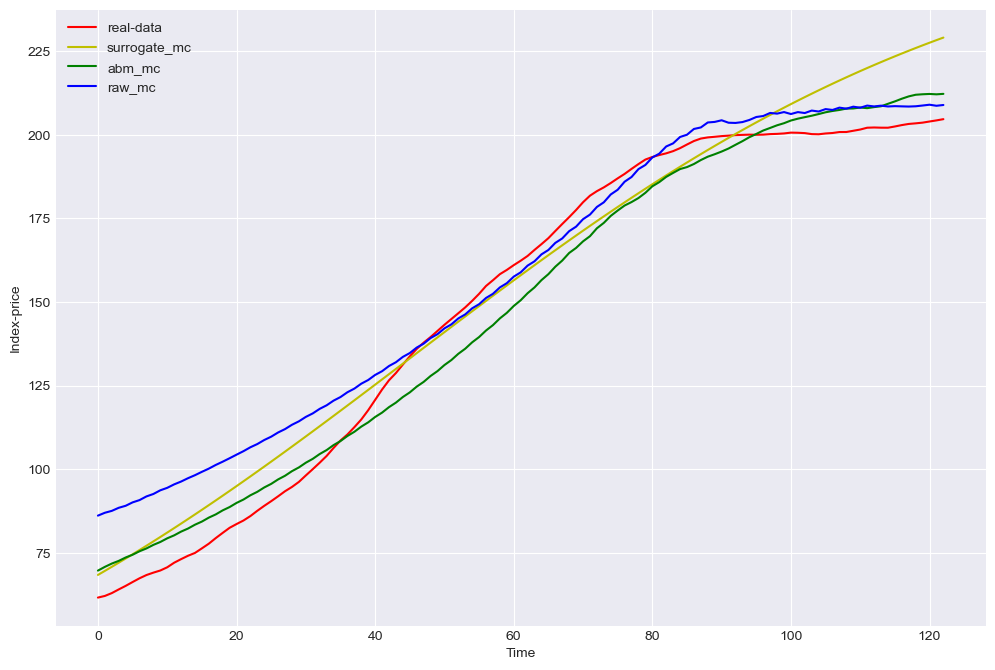

In [183]:
for i in range(50):
    main()

In [184]:
def main():

    average_price = 0
    sold = 0
    sum_price = 0
    sold_price = 0


    buyers = []
    sellers = []
    best_mrse = 0
    best_sim = []
    realdata = readData("sp")
    t = len(realdata)
    
    #Initializing the parameters with most plausible values
    price0= min(realdata)
    limit = max(realdata)
    alpha = 0.05
    beta = 0.03
    price_time_series = [price0]
    
    #normalizing values as price0 and limit are orders of magnitude greater than alpha and beta parameters
    price0_norm = math.fabs(deconverse(price0, 65))
    limit_norm = math.fabs(deconverse(limit, 210))
    sigma=[price0_norm, alpha, beta, limit_norm]

    #Find best parameters for the ODE based on real data - CMA-ES strategy
    surrogate_simulator = DESimulator(realdata)
    cma_surrogate_data = surrogate_simulator.run(sigma=[price0_norm, alpha, beta, limit_norm], sigma0=0.02)
    cma_surrogate_data = [converse(cma_surrogate_data[0], 65), cma_surrogate_data[1], cma_surrogate_data[2], converse(cma_surrogate_data[3], 210)]
    #print(f"Params: {cma_surrogate_data}")
    best_cma_surrogate_sim = surrogate_simulator.simulate(cma_surrogate_data, t)
    #print(f"Best Sim: {best_cma_surrogate_sim}")
    rmse_cma_surrogate = math.sqrt(mean_squared_error(best_cma_surrogate_sim, realdata))
    #print(f"Best RMSE MCMA_Surrogate: {rmse_cma_surrogate}")
    
    #Find best parameters for agent-based model after calibrating surrogate with CMA-ES strategy
    mas_surrogate_cma_simulator = ABSimulator(realdata)
    #cma_surrogate_data.append(0.2)
    #cma_surrogate_data.append(3)
    cma_surrogate_data.append(cma_surrogate_data[2]*10)
    cma_surrogate_data.append(cma_surrogate_data[2]*100)
    mas_surrogate_cma_data = mas_surrogate_cma_simulator.calibrate(sigma = cma_surrogate_data, sigma0=0.02)
    #print(f"Params cam_mas: {mas_surrogate_cma_data}")
    #print("Best sim: {}".format(mas_surrogate_cma_simulator.best_sim))
    
    #Find best parameters for the raw agent-based model with CMA-ES - without using the surrogate
    raw_cma_simulator = ABSimulator(realdata)
    lower_b = np.random.randint(1, 10)/10
    noSell = np.random.randint(1, 10)
    #lower_b = 0.2
    #noSell = 3
    raw_cma_data = raw_cma_simulator.calibrate(sigma=[price0_norm, np.random.randint(1, 11)/100, np.random.randint(1, 11)/100, limit_norm, lower_b, noSell], sigma0=0.02)
    #print(f"Params raw_mas: {converse(raw_cma_data[0], 65), raw_cma_data[1], raw_cma_data[2], converse(raw_cma_data[3], 210)}")
    
    
    
    rmse_cma_surrogate = math.sqrt(mean_squared_error(mas_surrogate_cma_simulator.best_sim, realdata))
    rmse_cma_raw = math.sqrt(mean_squared_error(raw_cma_simulator.best_sim, realdata))
    rmse_cma_mas = math.sqrt(mean_squared_error(mas_surrogate_cma_simulator.best_sim, realdata))
    
    #print("***********************************")
    print(f'Raw: {rmse_cma_raw} | MAS: {rmse_cma_surrogate}')
    
    #Print results 
    plt.figure(figsize=(12,8))
    t = range(0,123)
    plt.style.use('seaborn-darkgrid')
    plt.xlabel('Time')
    plt.ylabel('Index-price')
    plt.plot(t, realdata, "r", label='real-data')
    plt.plot(t, best_cma_surrogate_sim,"y", label='surrogate_cma')
    #plt.plot(t, mas_surrogate_cma_simulator.best_sim, "g", label='abm_cma')
    plt.plot(t,raw_cma_simulator.best_sim, "b", label='raw_cma')
    #plt.plot(t,raw_mc_simulator.best_sim, "y-", label='raw_mc' )
    #plt.plot(t,best_mc_surrogate_sim, "y-", label='surrogate_mc' )
    #plt.plot(t,mas_surrogate_cma_simulator.best_sim, "g", label='abm_mc')
    plt.plot(t, mas_surrogate_cma_simulator.best_sim, "g", label='abm_cma')
    #plt.plot(t,raw_mc_simulator.best_sim, "b", label='raw_mc')
    plt.legend()
    plt.show()
    
    with open('24_cma_surrogate_random', 'a') as f:
        f.write(str(realdata) + "; " + str(mas_surrogate_cma_simulator.best_sim)+ ";"+  str(raw_cma_simulator.best_sim) + ";"+ str(rmse_cma_surrogate) + ";" + str(rmse_cma_raw) +"\n")

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=205942, Mon Apr 15 14:54:01 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=281196, Mon Apr 15 14:54:01 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.874939681088040e+01 1.0e+00 1.85e-02  2e-02  2e-02 0:00.0
    2     16 1.745217430447408e+01 1.3e+00 1.71e-02  2e-02  2e-02 0:00.0
    3     24 3.800835651414486e+01 1.2e+00 1.85e-02  1e-02  2e-02 0:00.0
  100    800 4.668655151579642e+00 1.9e+03 7.18e-03  1e-04  1e-02 0:00.8
  200   1600 4.668268327544571e+00 5.7e+04 2.54e-06  6e-10  2e-06 0:01.6
  300   2400 4.668268327523152e+00 9.1e+04 4.42e-07  2e-11  7e-08 0:02.4
  400   3200 4.668268327555272e+00 7.0e+05 1.21e-07  2e-12  7e-09 0:03.1


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=408)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327544586e+00 1.5e+01 2.77e-07  5e-08  3e-07 0:03.9
  550   4400 4.668268327555262e+00 5.5e+01 7.14e-07  7e-08  8e-07 0:04.3
termination on tolstagnation=198 (Mon Apr 15 14:54:06 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4401/2858 evaluations
incumbent solution: [-1.432971239578046, 0.03748920543067799, 0.03996533658832796, 2.1066041937185815]
std deviation: [6.857582973984504e-08, 7.563500688705849e-07, 7.458014793894419e-07, 5.492966969133534e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=228698, Mon Apr 15 14:54:06 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=303620, Mon Apr 15 14:54:06 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.193432200939942e+01 1.0e+00 1.83e-02  2e-02  2e-02 0:00.3
    2     18 1.339538917404516e+01 1.2e+00 1.74e-02  2e-02  2e-02 0:00.6
    3     27 1.592537100811678e+01 1.3e+00 1.55e-02  1e-02  2e-02 0:00.8
   16    144 1.677797315444319e+0

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=717)
  warnings.warn(msg + ' (' +


  774   6966 1.617274081022148e+01 7.6e+00 5.26e-01  4e-01  9e-01 3:18.1
  800   7200 1.721207600646734e+01 1.0e+01 1.49e-01  6e-02  2e-01 3:25.7
  825   7425 1.712239610331652e+01 9.8e+00 1.06e-01  3e-02  1e-01 3:33.3
termination on tolstagnation=256 (Mon Apr 15 14:59:31 2024)
final/bestever f-value = 1.739644e+01 1.598316e+01 after 7426/3911 evaluations
incumbent solution: [47.13081310572694, 53.58690487085338, -0.01353554699716473, 38.04098339847216, 3.371866384583469, -0.9345762916319007]
std deviation: [0.05032063978364113, 0.031213217858898558, 0.03332652491889434, 0.080545812070442, 0.030618738789085803, 0.10830583152976515]
Raw: 15.983158828273313 | MAS: 10.40442431605898


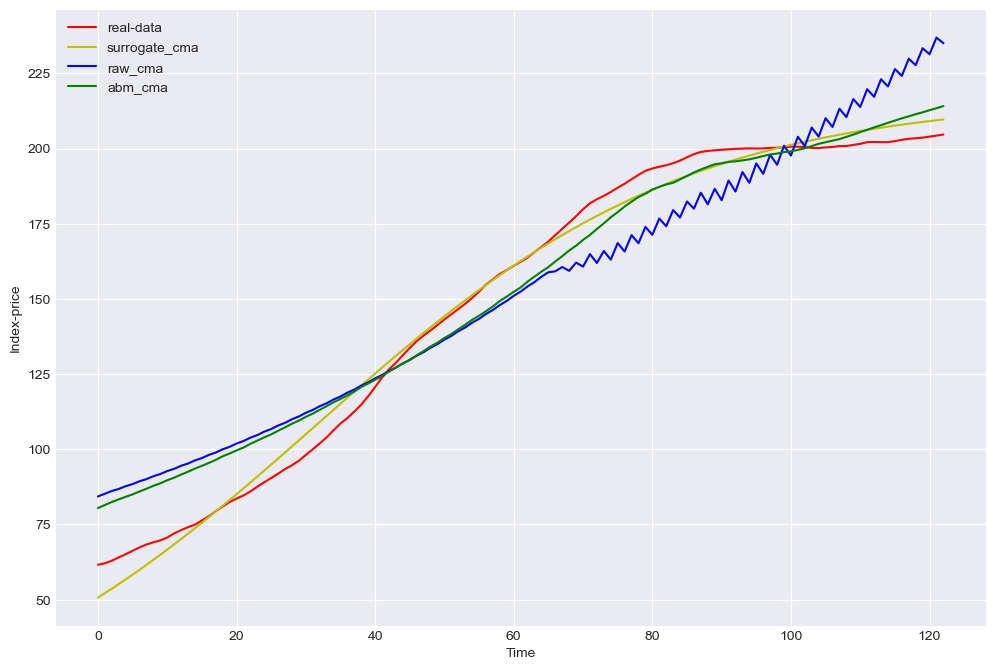

In [173]:
if __name__ == "__main__":
    main()

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=435032, Tue Apr 16 23:17:42 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=321985, Tue Apr 16 23:17:42 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.257023792607531e+01 1.0e+00 1.97e-02  2e-02  2e-02 0:00.0
    2     16 2.038677361029695e+01 1.2e+00 2.00e-02  2e-02  2e-02 0:00.0
    3     24 2.306066508303654e+01 1.2e+00 2.18e-02  2e-02  2e-02 0:00.0
  100    800 4.668293119456186e+00 2.6e+03 2.18e-03  3e-05  4e-03 0:00.8
  200   1600 4.668268327534273e+00 5.2e+04 6.94e-06  2e-09  4e-06 0:01.6
  300   2400 4.668268327544716e+00 2.2e+04 4.84e-06  4e-10  3e-07 0:02.4
  400   3200 4.668268327533863e+00 2.5e+04 2.09e-06  2e-11  3e-08 0:03.1
  500   4000 4.668268327523188e+00 2.7e+04 3.14e-06  7e-12  1e-08 0:04.0
  530   4240 4.668268327544573e+00 6.1e+04 2.56e-06  4e-12  7e-09 0:04.4
termination on tolstagnation=198 (Tue Apr 16 23:17:47 2024)
final/bestever f-value = 4.6682

  500   4500 1.822884106606251e+01 1.1e+04 6.72e-02  1e-05  2e-02 93:02.4
  515   4635 1.811034566601822e+01 1.8e+04 1.00e-01  2e-05  4e-02 98:01.0
  542   4878 1.822809455892574e+01 2.5e+04 8.35e-02  2e-05  3e-02 103:17.9
  555   4995 1.815220302887959e+01 3.3e+04 1.61e-01  4e-05  6e-02 103:26.6
termination on tolstagnation=256 (Wed Apr 17 01:41:22 2024)
final/bestever f-value = 1.832634e+01 1.746380e+01 after 4996/3425 evaluations
incumbent solution: [1.7440801105466384, 0.005540511167777243, 0.22042361953285547, 3.171944595293682, 2.8997327933590116, 3.614353532680979]
std deviation: [0.0586461446915877, 3.6062938448289416e-05, 0.0032991785623648247, 0.05937484123529074, 0.05304922997062857, 0.04459544475712083]
Raw: 17.463798075551583 | MAS: 9.795973623281707


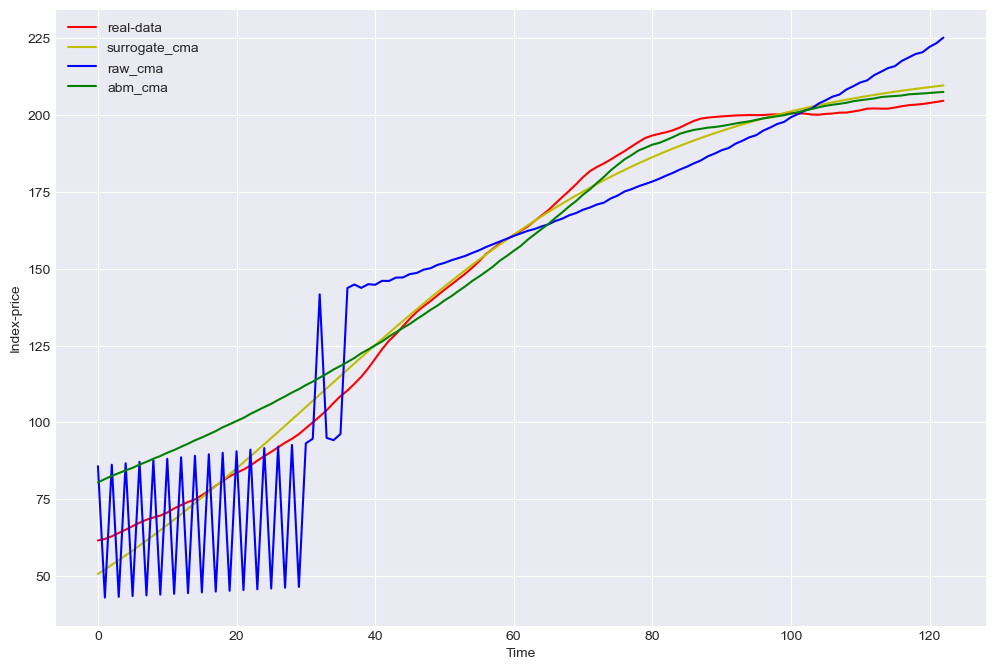

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=460325, Wed Apr 17 01:41:22 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=462301, Wed Apr 17 01:41:22 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.219366522708453e+01 1.0e+00 1.84e-02  2e-02  2e-02 0:00.0
    2     16 2.177691325897471e+01 1.1e+00 1.79e-02  2e-02  2e-02 0:00.0
    3     24 1.605798679512850e+01 1.3e+00 1.54e-02  1e-02  2e-02 0:00.0
  100    800 4.668282792361985e+00 1.7e+03 3.55e-03  3e-05  4e-03 0:02.2
  155   1240 4.668268327548369e+00 1.4e+04 8.56e-06  5e-09  4e-06 0:06.2
  200   1600 4.668268327535625e+00 1.4e+04 7.34e-06  2e-09  1e-06 0:08.0
  300   2400 4.668268327534030e+00 3.3e+04 7.14e-06  3e-10  3e-07 0:12.0
  400   3200 4.668268327533865e+00 8.1e+04 9.27e-06  1e-10  1e-07 0:16.0
  500   4000 4.668268327533903e+00 8.6e+04 6.62e-06  7e-11  9e-09 0:19.8
  600   4800 4.668268327533895e+00 5.6e+05 4.60e-05  2e-10  4e-08 0:23.7


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=620)
  warnings.warn(msg + ' (' +


  640   5120 4.668268327544581e+00 2.3e+00 1.26e-05  5e-06  1e-05 0:25.3
termination on tolstagnation=198 (Wed Apr 17 01:41:51 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 5121/4098 evaluations
incumbent solution: [-1.4329712717145906, 0.03748920545275092, 0.036564203013666585, 0.14018392476175734]
std deviation: [8.529161550129449e-06, 8.379873827909619e-06, 1.0039230920707579e-05, 5.317421744661246e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=433729, Wed Apr 17 01:41:51 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=465450, Wed Apr 17 01:41:51 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.843595874726648e+01 1.0e+00 2.04e-02  2e-02  2e-02 0:01.6
    2     18 2.650439579039143e+01 1.4e+00 2.17e-02  2e-02  3e-02 0:03.6
    3     27 9.751938323855606e+00 1.6e+00 2.52e-02  2e-02  3e-02 0:05.2
    5     45 1.308279887239915e+01 1.8e+00 2.25e-02  2e-02  3e-02 0:08.7
    8     72 1.05119011667488

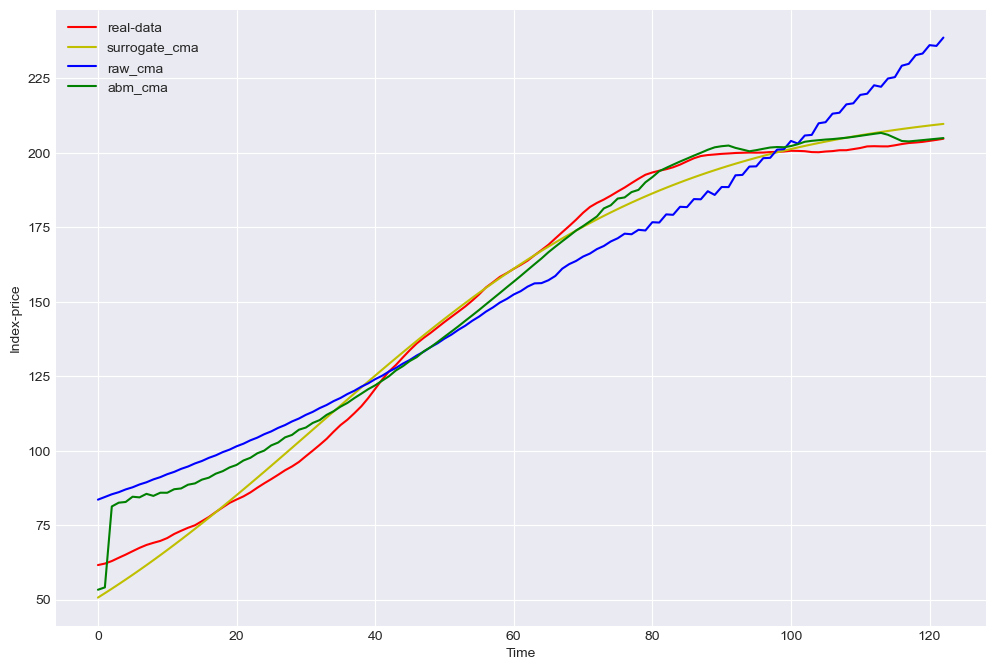

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=450210, Wed Apr 17 03:49:12 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=465279, Wed Apr 17 03:49:12 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.105052605704072e+01 1.0e+00 1.83e-02  2e-02  2e-02 0:00.0
    2     16 3.140730378442178e+01 1.2e+00 1.85e-02  2e-02  2e-02 0:00.0
    3     24 2.043156999605939e+01 1.5e+00 1.80e-02  1e-02  2e-02 0:00.0
  100    800 4.669011462459571e+00 3.6e+03 1.10e-02  1e-04  3e-02 0:00.9
  200   1600 4.668268327539599e+00 6.8e+04 3.69e-05  8e-09  6e-05 0:02.2
  300   2400 4.668268327534450e+00 3.2e+05 5.99e-06  1e-09  3e-06 0:03.0


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=360)
  warnings.warn(msg + ' (' +


  400   3200 4.668268327545102e+00 4.2e+00 2.08e-06  1e-06  2e-06 0:03.8
  500   4000 4.668268327545095e+00 4.9e+01 9.70e-07  3e-07  4e-07 0:04.6
  600   4800 4.668268327523700e+00 8.1e+02 1.21e-07  6e-09  4e-08 0:05.5
  680   5440 4.668268327545121e+00 3.0e+03 3.64e-08  5e-10  8e-09 0:07.1
termination on tolstagnation=198 (Wed Apr 17 03:49:20 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 5441/3871 evaluations
incumbent solution: [-1.4329709111590607, 0.03748920407846047, 0.04226495769206401, 3.43616787235866]
std deviation: [4.903113616813229e-10, 6.837981217742061e-09, 7.095679899846526e-09, 7.504853949162808e-09]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=473738, Wed Apr 17 03:49:20 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=504536, Wed Apr 17 03:49:20 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.377354384302208e+01 1.0e+00 2.00e-02  2e-02  2e-02 0:01.7
    2     18 1.607397004822732e+01

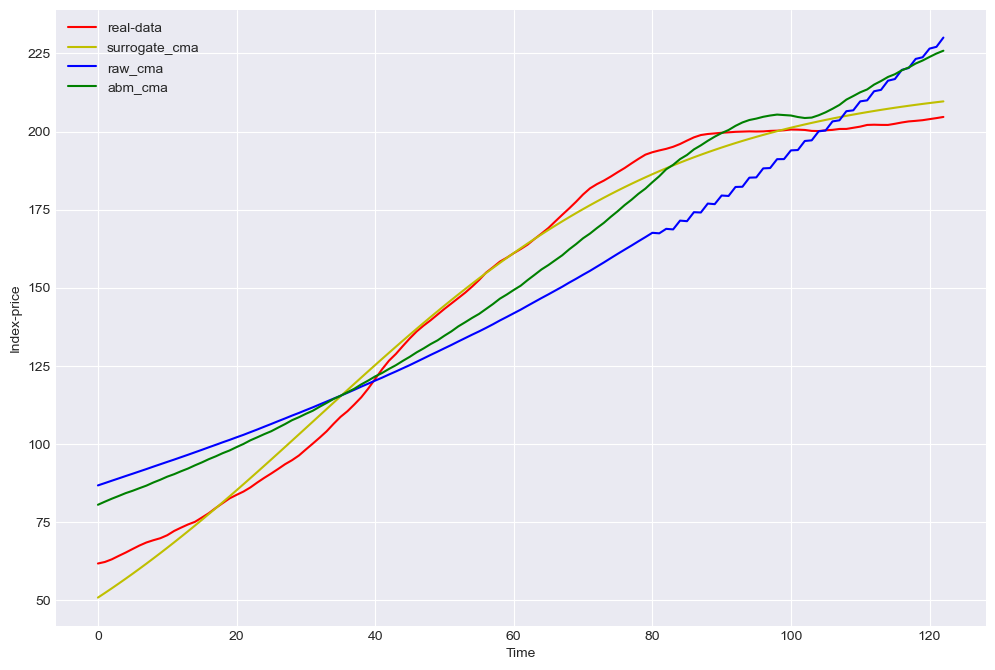

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=506800, Wed Apr 17 04:20:02 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=508906, Wed Apr 17 04:20:02 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.135186625306790e+01 1.0e+00 2.31e-02  2e-02  3e-02 0:00.0
    2     16 6.340960857474275e+01 1.7e+00 2.35e-02  2e-02  2e-02 0:00.0
    3     24 4.104751955131145e+01 1.5e+00 2.18e-02  2e-02  2e-02 0:00.1
  100    800 4.668284175346037e+00 2.0e+03 2.73e-03  2e-05  3e-03 0:01.7
  200   1600 4.668268327536015e+00 4.7e+04 8.98e-06  2e-09  8e-06 0:03.5
  300   2400 4.668268327544573e+00 4.5e+04 4.20e-06  2e-10  1e-06 0:05.4
  400   3200 4.668268327544600e+00 1.7e+05 2.96e-06  5e-11  3e-07 0:07.2


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=462)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327544568e+00 5.0e+00 4.78e-06  3e-06  4e-06 0:09.0
  579   4632 4.668268327544562e+00 4.2e+01 7.66e-06  3e-06  7e-06 0:10.6
termination on tolstagnation=198 (Wed Apr 17 04:20:15 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4633/3834 evaluations
incumbent solution: [-1.4329712327249522, 0.03748920542989347, 0.03578681037659116, -0.30927816094740734]
std deviation: [2.6340088742458165e-06, 4.1694130728069025e-06, 6.968659892581048e-06, 3.4102748515189908e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=403177, Wed Apr 17 04:20:15 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=419518, Wed Apr 17 04:20:15 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.030603341400424e+01 1.0e+00 2.08e-02  2e-02  2e-02 0:00.7
    2     18 2.359549898621744e+01 1.4e+00 2.43e-02  2e-02  3e-02 0:01.4
    3     27 1.172827188364962e+01 1.5e+00 2.28e-02  2e-02  3e-02 0:02.0
    9     81 1.447739712967

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=878)
  warnings.warn(msg + ' (' +


  898   8082 9.516491493479505e+00 3.4e+00 4.61e-03  3e-03  6e-03 31:35.3
  900   8100 9.598819539211808e+00 3.5e+00 4.01e-03  3e-03  4e-03 31:37.7
  902   8118 9.711569824873051e+00 3.4e+00 4.68e-03  3e-03  5e-03 31:40.3
termination on tolstagnation=256 (Wed Apr 17 04:51:59 2024)
final/bestever f-value = 9.755710e+00 9.473575e+00 after 8119/6962 evaluations
incumbent solution: [51.269057946397425, 0.01636030091654561, -0.015050875046380696, 207.54232818296123, 0.4403224144316482, 3.544096349874451]
std deviation: [0.004055255474637102, 0.003183005998733774, 0.00450256520251611, 0.005221824704569372, 0.003922802122138701, 0.0052562288427099885]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=457103, Wed Apr 17 04:51:59 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=437711, Wed Apr 17 04:51:59 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.082805099176768e+02 1.0e+00 2.00e-02  2e-02  2e-02 0:01.5
    2     18 3.7626082

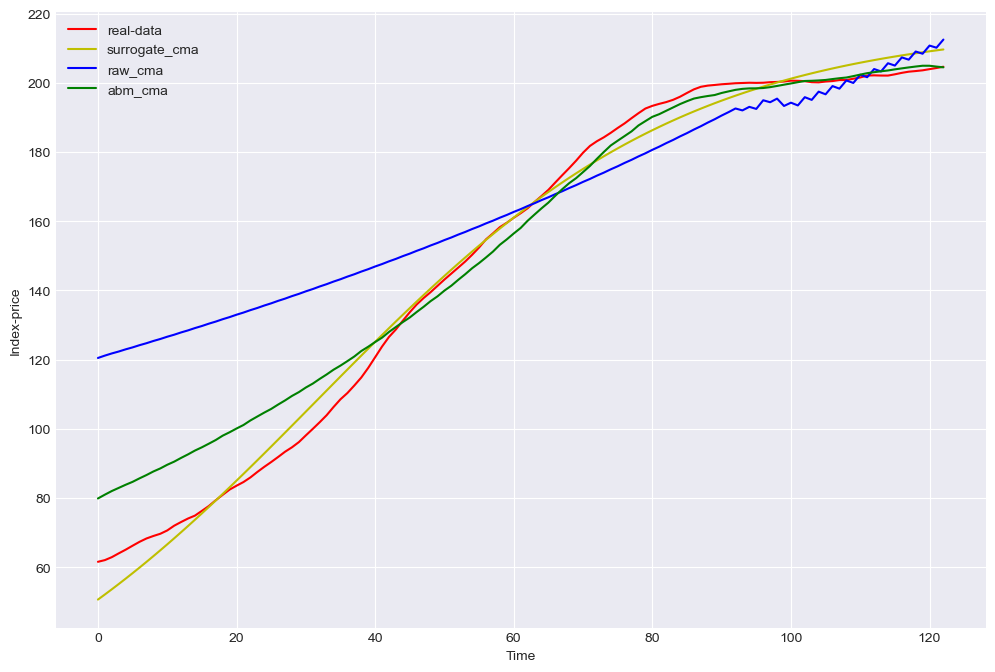

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=470209, Wed Apr 17 06:31:54 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=413768, Wed Apr 17 06:31:54 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.556012868972012e+01 1.0e+00 1.81e-02  2e-02  2e-02 0:00.0
    2     16 1.397181950798053e+01 1.2e+00 1.54e-02  1e-02  1e-02 0:00.0
    3     24 1.036645318563439e+01 1.3e+00 1.76e-02  1e-02  2e-02 0:00.0
  100    800 4.668294497038438e+00 1.1e+03 2.95e-03  3e-05  4e-03 0:00.8
  200   1600 4.668268327546016e+00 6.8e+03 1.14e-05  2e-09  2e-06 0:01.6
  300   2400 4.668268327544720e+00 2.0e+04 9.96e-06  3e-10  5e-07 0:02.3
  400   3200 4.668268327533938e+00 1.1e+05 2.63e-06  3e-11  5e-08 0:03.2


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=483)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327533906e+00 2.5e+00 6.56e-06  4e-06  8e-06 0:04.5
  600   4800 4.668268327533879e+00 1.1e+01 1.64e-05  3e-06  9e-06 0:08.7
  690   5520 4.668268327533973e+00 4.0e+01 4.02e-05  2e-06  1e-05 0:13.0
termination on tolstagnation=198 (Wed Apr 17 06:32:09 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 5521/4072 evaluations
incumbent solution: [-1.4329713537425262, 0.03748920687330016, 0.035238376910082456, -0.6263649701493688]
std deviation: [3.3031943840376412e-06, 9.867216385618234e-06, 3.556040593093151e-06, 2.4763854214090984e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=476701, Wed Apr 17 06:32:09 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=463422, Wed Apr 17 06:32:09 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.515233014531391e+01 1.0e+00 2.03e-02  2e-02  2e-02 0:01.3
    2     18 1.175743520059983e+01 1.3e+00 2.04e-02  2e-02  2e-02 0:02.8
    3     27 1.5744204405761

  795   7155 1.806595606621083e+01 5.0e+03 8.54e-03  9e-07  2e-04 67:51.9
termination on tolstagnation=256 (Wed Apr 17 08:18:14 2024)
final/bestever f-value = 1.819498e+01 1.777986e+01 after 7156/4890 evaluations
incumbent solution: [0.266592573043756, -0.005256690769793721, 0.18518505953914818, 0.5813468454417003, 0.3220647655764104, 8.19910059630313]
std deviation: [0.00012032869140615466, 8.63907095587041e-07, 7.840991797716325e-05, 4.584159081221527e-05, 3.212221453327615e-05, 0.00018213182605436305]
Raw: 17.779857752131008 | MAS: 9.831193513835128


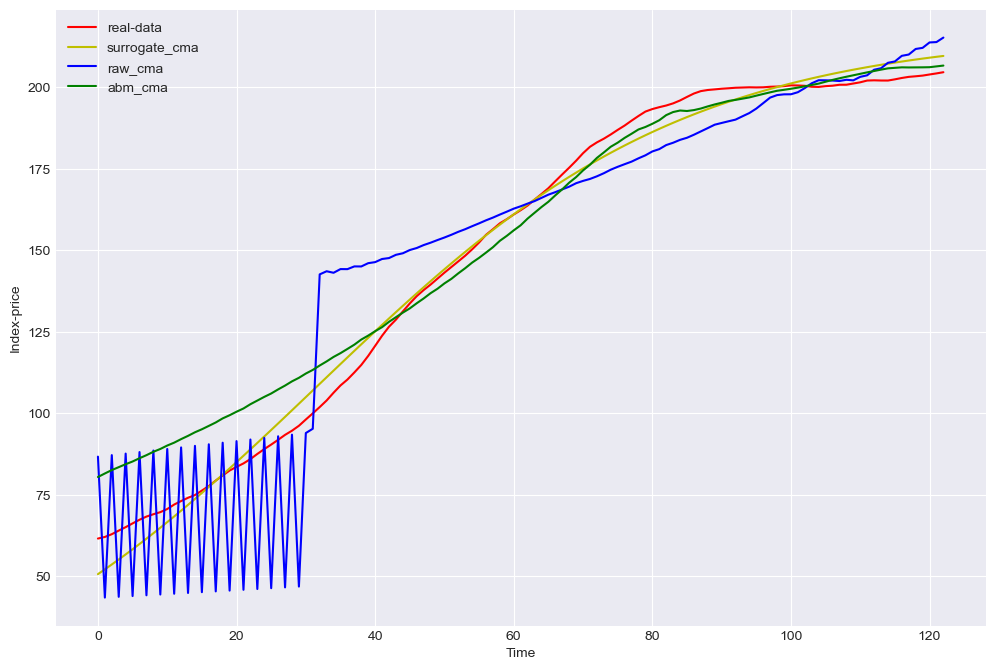

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=393727, Wed Apr 17 08:18:15 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=417952, Wed Apr 17 08:18:15 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 8.803271175434048e+01 1.0e+00 2.04e-02  2e-02  2e-02 0:00.0
    2     16 2.682772563313411e+01 1.4e+00 1.81e-02  2e-02  2e-02 0:00.1
    3     24 1.924446509031439e+01 1.6e+00 1.52e-02  1e-02  2e-02 0:00.1
   87    696 4.668872036389161e+00 1.8e+03 7.75e-03  1e-04  1e-02 0:03.1
  100    800 4.668270612197218e+00 2.3e+03 2.57e-03  2e-05  3e-03 0:03.6
  200   1600 4.668268327534525e+00 7.9e+04 7.02e-06  2e-09  4e-06 0:07.5
  300   2400 4.668268327544933e+00 2.2e+05 1.24e-05  7e-10  3e-06 0:11.4


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=370)
  warnings.warn(msg + ' (' +


  400   3200 4.668268327544696e+00 6.4e+00 3.88e-06  2e-06  5e-06 0:15.3
  500   4000 4.668268327533981e+00 1.6e+01 2.05e-06  3e-07  8e-07 0:19.4
  600   4800 4.668268327533981e+00 2.9e+01 1.11e-06  4e-08  8e-08 0:23.3
  700   5600 4.668268327533985e+00 7.9e+01 6.33e-08  3e-10  1e-09 0:27.3
  800   6400 4.668268327533969e+00 6.8e+01 1.10e-07  8e-11  3e-10 0:31.2
  900   7200 4.668268327533987e+00 7.2e+01 4.21e-07  1e-10  6e-10 0:35.1
  987   7896 4.668268327533982e+00 2.5e+02 1.30e-06  2e-10  1e-09 2:51.0
 1000   8000 4.668268327523271e+00 3.2e+02 3.83e-06  7e-10  4e-09 2:51.4
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100   8800 4.668268327533982e+00 9.6e+02 8.39e-06  4e-10  3e-09 2:52.3
 1200   9600 4.668268327533984e+00 5.1e+03 9.59e-05  2e-09  1e-08 2:53.1
 1210   9680 4.668268327533992e+00 3.7e+03 5.06e-05  6e-10  4e-09 2:53.2
termination on tolstagnation=198 (Wed Apr 17 08:21:15 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 9681/610

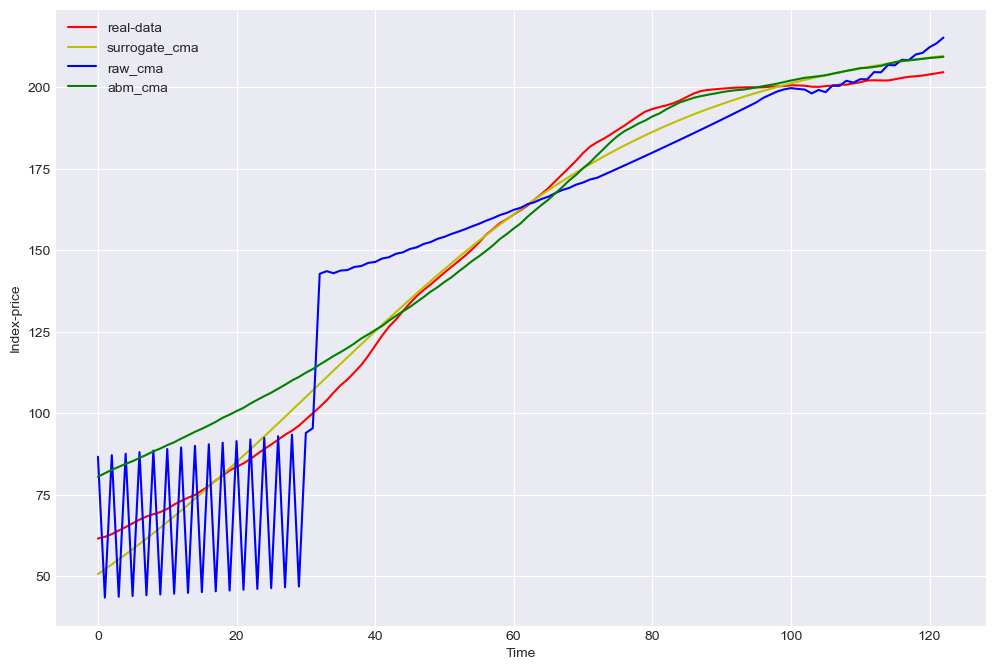

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=384834, Wed Apr 17 09:00:04 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=396954, Wed Apr 17 09:00:04 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.474232349918668e+01 1.0e+00 1.97e-02  2e-02  2e-02 0:00.0
    2     16 2.329453836605088e+01 1.3e+00 2.02e-02  2e-02  2e-02 0:00.0
    3     24 2.993188251329451e+01 1.5e+00 1.94e-02  2e-02  2e-02 0:00.0
  100    800 4.668270317068008e+00 3.1e+03 9.43e-04  7e-06  2e-03 0:00.8
NOTE (module=cma, iteration=147):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 5.8e+09 to 3.2e+04
  200   1600 4.668268327538438e+00 6.5e+02 4.93e-06  6e-10  1e-05 0:01.7
  300   2400 4.668268327535487e+00 2.4e+03 3.05e-05  7e-10  3e-05 0:02.5
  400   3200 4.668268327534920e+00 9.9e+02 1.01e-04  6e-10  2e-05 0:03.3
  500   4000 4.668268327545122e+00 4.3e+04 2.75e-05  1e-10  3e-06 0:04.1
  600   4800 4.

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=744)
  warnings.warn(msg + ' (' +


termination on tolstagnation=198 (Wed Apr 17 09:00:11 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 6001/5077 evaluations
incumbent solution: [-1.4329716023303263, 0.0374892071495907, 0.03749497304761462, 0.6783227126579732]
std deviation: [0.00020740023232636168, 0.0003634289567616416, 0.0002879315220998522, 0.00023861302044469847]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=482131, Wed Apr 17 09:00:11 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=421126, Wed Apr 17 09:00:11 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.146802792884754e+01 1.0e+00 1.90e-02  2e-02  2e-02 0:00.4
    2     18 1.054222785228911e+01 1.2e+00 1.90e-02  2e-02  2e-02 0:00.7
    3     27 1.045835845249273e+01 1.3e+00 1.79e-02  2e-02  2e-02 0:01.0
   12    108 1.172785092246992e+01 1.8e+00 1.08e-02  8e-03  1e-02 0:04.4
   21    189 9.549245337514936e+00 3.3e+00 1.03e-02  4e-03  1e-02 0:08.9
   32    288 8.817544670135511e

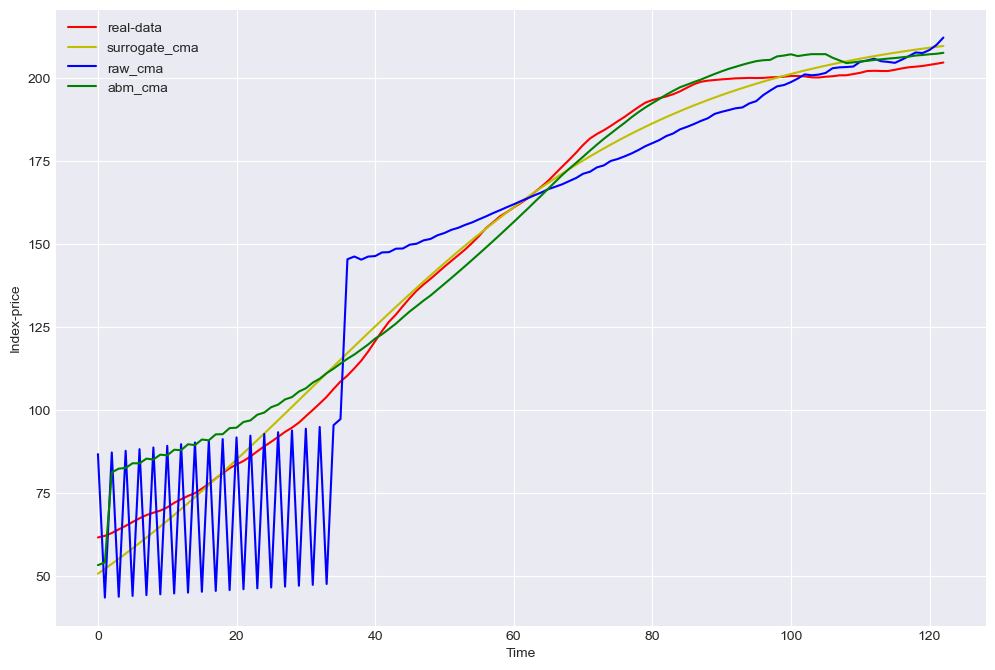

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=409812, Wed Apr 17 09:14:29 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=455384, Wed Apr 17 09:14:29 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.154216228698065e+01 1.0e+00 1.85e-02  2e-02  2e-02 0:00.0
    2     16 1.248934030684133e+01 1.1e+00 1.77e-02  2e-02  2e-02 0:00.0
    3     24 2.438227725445522e+01 1.4e+00 1.73e-02  1e-02  2e-02 0:00.0
  100    800 4.668303419511601e+00 2.5e+03 5.42e-03  5e-05  1e-02 0:00.9
NOTE (module=cma, iteration=192):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 4.7e+10 to 1.5e+05
  200   1600 4.668268327546492e+00 5.6e+02 1.30e-05  2e-09  3e-05 0:01.9
  300   2400 4.668268327533951e+00 7.7e+02 2.49e-05  1e-09  2e-05 0:02.9
  400   3200 4.668268327544678e+00 2.6e+03 3.35e-05  6e-10  9e-06 0:03.9
  500   4000 4.668268327555294e+00 1.0e+04 3.48e-05  2e-10  3e-06 0:05.0
  540   4320 4.

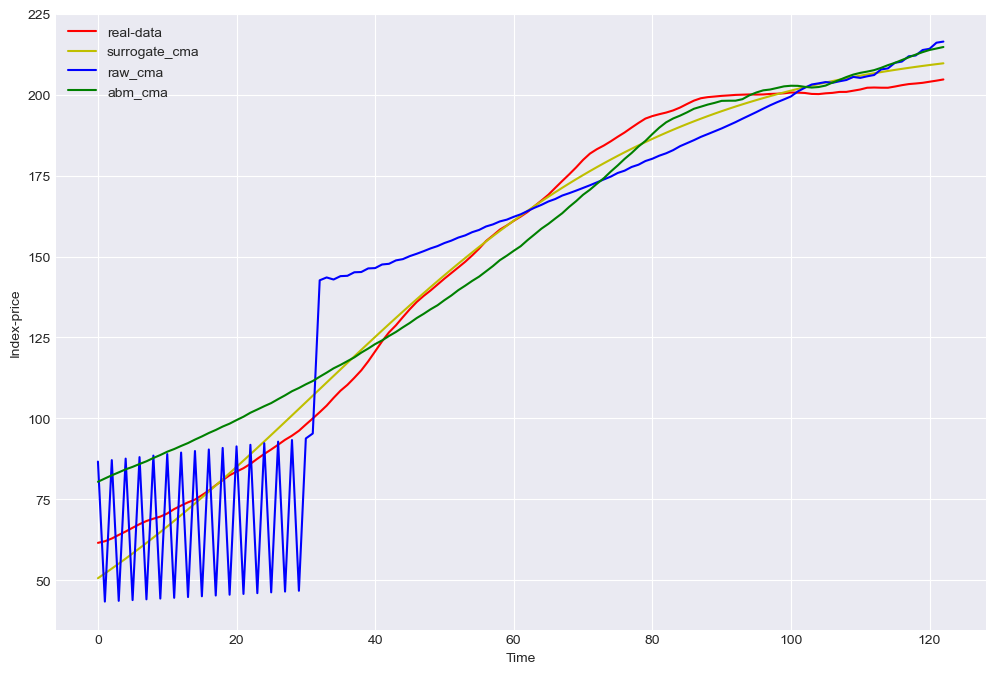

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=424351, Wed Apr 17 09:24:10 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=485944, Wed Apr 17 09:24:10 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.619491624639474e+01 1.0e+00 1.98e-02  2e-02  2e-02 0:00.0
    2     16 2.722929807309106e+01 1.2e+00 2.23e-02  2e-02  3e-02 0:00.0
    3     24 2.633258587160001e+01 1.7e+00 2.25e-02  2e-02  3e-02 0:00.0
  100    800 4.669032807034501e+00 5.1e+03 2.76e-02  2e-04  9e-02 0:00.8
NOTE (module=cma, iteration=160):  
condition in coordinate system exceeded 1.3e+08, rescaled to 1.0e+00, 
condition changed from 8.7e+09 to 4.6e+04
  200   1600 4.668268327535925e+00 1.3e+03 1.61e-05  3e-09  5e-05 0:01.7
  300   2400 4.668268327545019e+00 4.3e+03 7.70e-06  5e-10  9e-06 0:02.6
  400   3200 4.668268327544964e+00 3.8e+03 4.60e-06  7e-11  6e-07 0:03.5
  500   4000 4.668268327544955e+00 1.3e+04 6.76e-06  3e-11  6e-07 0:04.5
  600   4800 4.

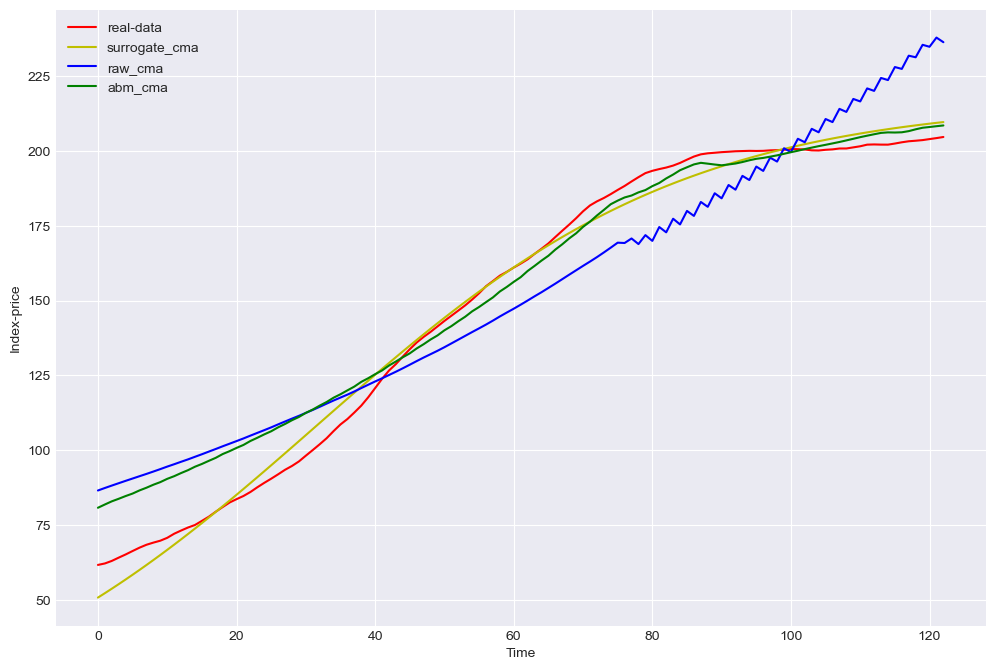

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=476825, Wed Apr 17 09:39:52 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=465249, Wed Apr 17 09:39:52 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.858102339302074e+01 1.0e+00 1.87e-02  2e-02  2e-02 0:00.0
    2     16 3.365281217120507e+01 1.2e+00 1.77e-02  2e-02  2e-02 0:00.1
    3     24 2.298354677811009e+01 1.4e+00 1.58e-02  1e-02  2e-02 0:00.1
   66    528 6.635692078244228e+00 6.5e+02 6.57e-02  3e-03  2e-01 4:45.6
  100    800 4.668340736995011e+00 2.0e+03 4.94e-03  6e-05  7e-03 4:46.3
  200   1600 4.668268327536378e+00 3.9e+04 1.51e-05  3e-09  6e-06 4:47.2
  300   2400 4.668268327533918e+00 1.5e+05 6.11e-06  3e-10  1e-06 4:47.9
  400   3200 4.668268327533862e+00 5.4e+05 2.40e-06  3e-11  2e-07 4:48.7


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=427)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327523174e+00 2.4e+01 8.76e-07  5e-07  1e-06 4:49.5
  581   4648 4.668268327544569e+00 1.5e+02 2.91e-07  8e-08  3e-07 4:50.2
termination on tolstagnation=198 (Wed Apr 17 09:44:44 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4649/3853 evaluations
incumbent solution: [-1.4329712511480865, 0.037489205419625735, 0.03840755333909231, 1.2059466805811638]
std deviation: [1.42465430127229e-07, 3.426279073197299e-07, 7.768389053041242e-08, 1.0608195068742998e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=483066, Wed Apr 17 09:44:44 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=439500, Wed Apr 17 09:44:44 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.467471704997340e+01 1.0e+00 2.31e-02  2e-02  3e-02 0:00.3
    2     18 1.304056688988594e+01 1.2e+00 2.42e-02  2e-02  3e-02 0:00.6
    3     27 2.593700564945418e+01 1.4e+00 2.19e-02  2e-02  2e-02 0:00.9
   12    108 1.029409242973790e

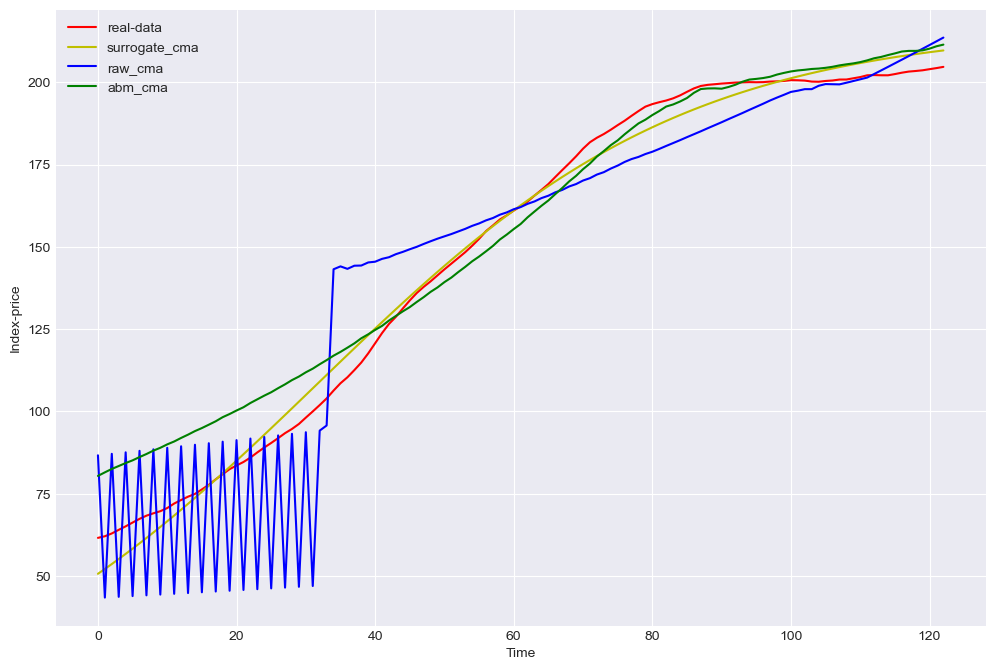

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=435003, Wed Apr 17 10:37:15 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=521289, Wed Apr 17 10:37:15 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.089755547800394e+01 1.0e+00 2.02e-02  2e-02  2e-02 0:00.0
    2     16 2.956981428603563e+01 1.5e+00 1.86e-02  1e-02  2e-02 0:00.0
    3     24 2.383584093664460e+01 1.5e+00 1.89e-02  1e-02  2e-02 0:00.0
  100    800 4.675084100093841e+00 1.4e+03 2.67e-02  3e-04  4e-02 0:00.8
  200   1600 4.668268327547121e+00 1.1e+05 4.28e-05  6e-09  6e-05 0:01.6
NOTE (module=cma, iteration=210):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.6e+10 to 1.4e+05
  300   2400 4.668268327545085e+00 9.7e+02 1.47e-05  3e-10  7e-06 0:02.5
  400   3200 4.668268327555637e+00 4.1e+03 4.60e-05  5e-10  1e-05 0:03.3
  500   4000 4.668268327555633e+00 8.8e+03 7.91e-06  2e-11  4e-07 0:04.2
  525   4200 4.

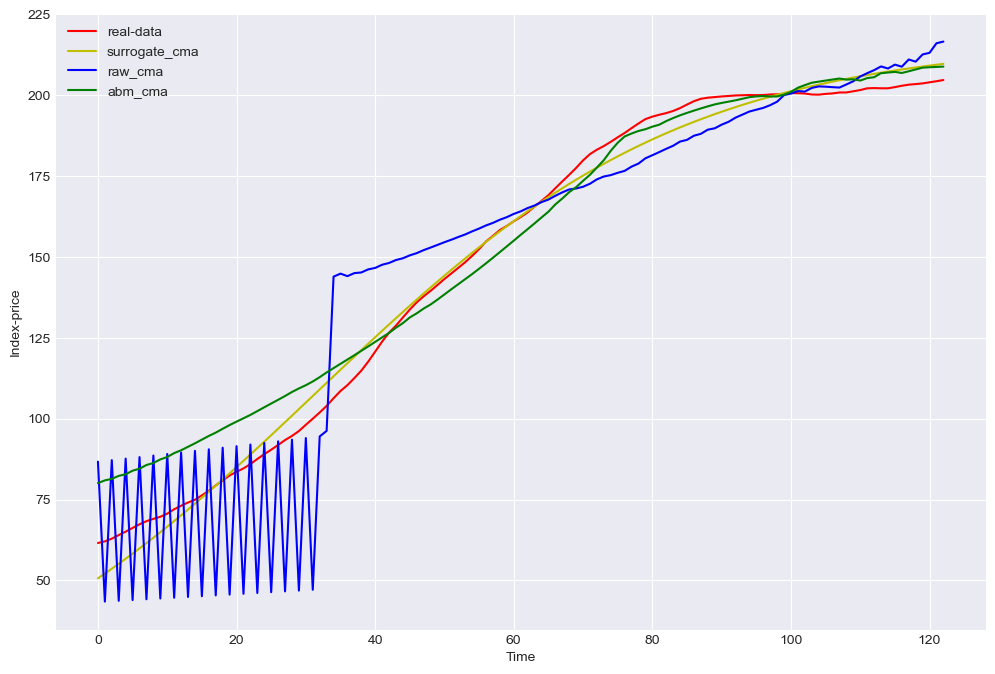

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=490379, Wed Apr 17 10:45:05 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=487590, Wed Apr 17 10:45:05 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.881536818092668e+01 1.0e+00 1.97e-02  2e-02  2e-02 0:00.0
    2     16 2.186427155875624e+01 1.2e+00 2.11e-02  2e-02  2e-02 0:00.0
    3     24 4.975888591575156e+01 1.4e+00 2.66e-02  2e-02  3e-02 0:00.0
  100    800 4.669047505506518e+00 2.0e+03 1.49e-02  2e-04  3e-02 0:00.8
  200   1600 4.668268327555341e+00 5.0e+04 8.69e-06  2e-09  1e-05 0:01.9
  300   2400 4.668268327544812e+00 5.6e+04 4.57e-06  3e-10  6e-07 0:02.7
  400   3200 4.668268327533978e+00 2.2e+05 9.76e-05  3e-09  7e-06 0:03.4
  500   4000 4.668268327533928e+00 2.4e+05 1.12e-05  3e-11  1e-07 0:04.2


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.4e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=552)
  warnings.warn(msg + ' (' +


  590   4720 4.668268327555344e+00 4.2e+00 6.01e-06  2e-06  5e-06 0:04.9
termination on tolstagnation=198 (Wed Apr 17 10:45:11 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4721/3533 evaluations
incumbent solution: [-1.4329710928117263, -0.03748920489323832, -0.03764202875548856, 0.7633466032857195]
std deviation: [4.650046225216404e-06, 3.4859410693057088e-06, 2.4648616134618234e-06, 3.0444009276079343e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=518433, Wed Apr 17 10:45:11 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=520727, Wed Apr 17 10:45:11 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.235220194606204e+01 1.0e+00 1.88e-02  2e-02  2e-02 0:00.3
    2     18 1.071413951177962e+01 1.3e+00 1.95e-02  2e-02  2e-02 0:00.7
    3     27 1.582931402757171e+01 1.5e+00 2.19e-02  2e-02  2e-02 0:01.1
   14    126 1.262889058647850e+01 2.2e+00 1.78e-02  1e-02  2e-02 0:04.2
   31    279 1.032274903751

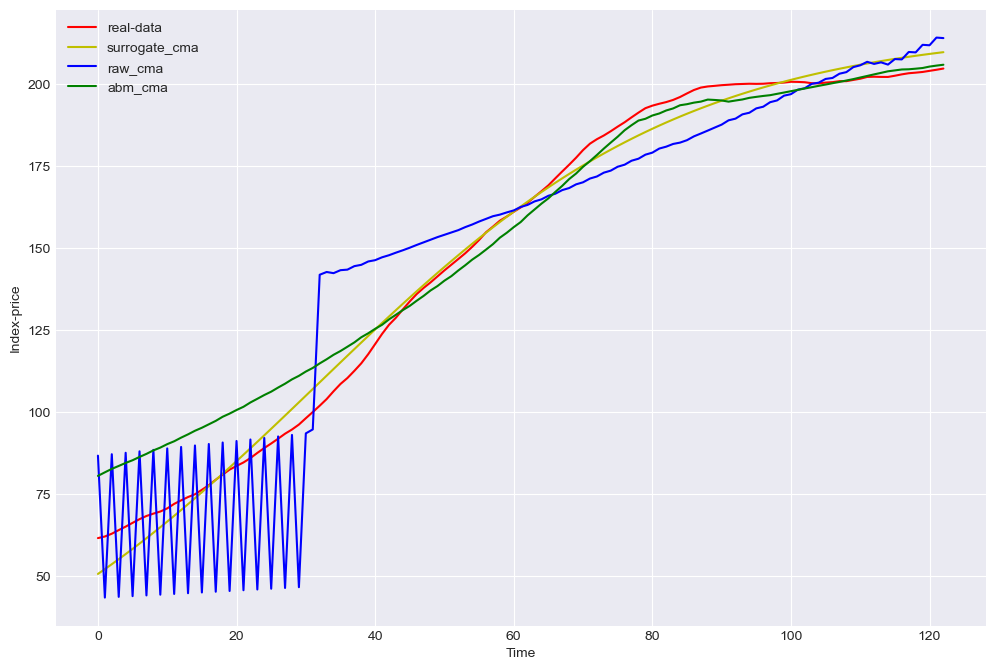

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=446430, Wed Apr 17 10:54:41 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=486976, Wed Apr 17 10:54:41 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.222885404684427e+01 1.0e+00 1.87e-02  2e-02  2e-02 0:00.0
    2     16 1.143239757886760e+01 1.3e+00 1.79e-02  1e-02  2e-02 0:00.0
    3     24 1.188679089256352e+01 1.6e+00 1.55e-02  1e-02  2e-02 0:00.1
  100    800 4.668467474968875e+00 2.7e+03 1.98e-02  2e-04  4e-02 0:01.4
NOTE (module=cma, iteration=155):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 6.8e+09 to 4.9e+04
  200   1600 4.668268327534515e+00 4.2e+02 7.74e-06  1e-09  1e-05 0:02.9
  300   2400 4.668268327534213e+00 4.7e+03 6.23e-06  2e-10  6e-06 0:04.2
  400   3200 4.668268327544697e+00 7.4e+03 3.26e-05  8e-10  9e-06 0:05.4
  500   4000 4.668268327544662e+00 3.2e+04 8.94e-05  2e-10  1e-05 0:06.6
  505   4040 4.

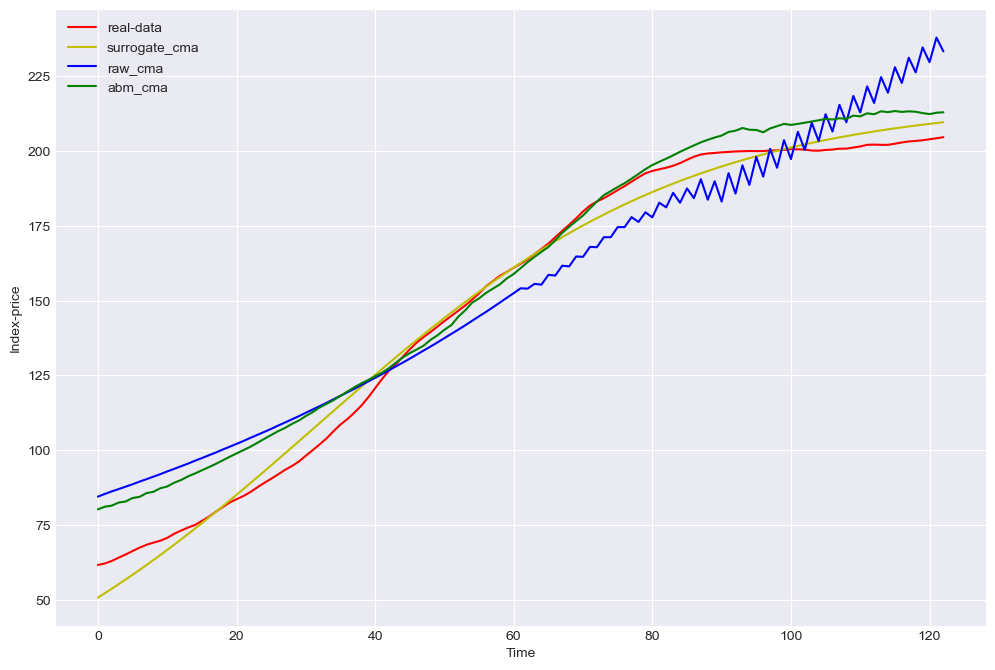

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=479471, Wed Apr 17 11:00:33 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=477308, Wed Apr 17 11:00:33 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.918273091583281e+01 1.0e+00 1.84e-02  2e-02  2e-02 0:00.0
    2     16 1.354909972683637e+01 1.1e+00 1.87e-02  2e-02  2e-02 0:00.0
    3     24 1.866678420324206e+01 1.5e+00 1.63e-02  1e-02  2e-02 0:00.0
  100    800 4.668291335572641e+00 2.6e+03 3.92e-03  2e-05  5e-03 0:01.3
NOTE (module=cma, iteration=198):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 8.2e+09 to 4.6e+04
  200   1600 4.668268327545393e+00 2.2e+02 4.30e-06  3e-10  3e-06 0:02.5
  300   2400 4.668268327544646e+00 1.5e+03 1.40e-06  7e-11  3e-07 0:03.7
  400   3200 4.668268327533937e+00 1.1e+04 2.07e-05  2e-09  9e-06 0:04.8
  500   4000 4.668268327533938e+00 5.8e+03 8.38e-05  8e-10  3e-06 0:06.0
  510   4080 4.

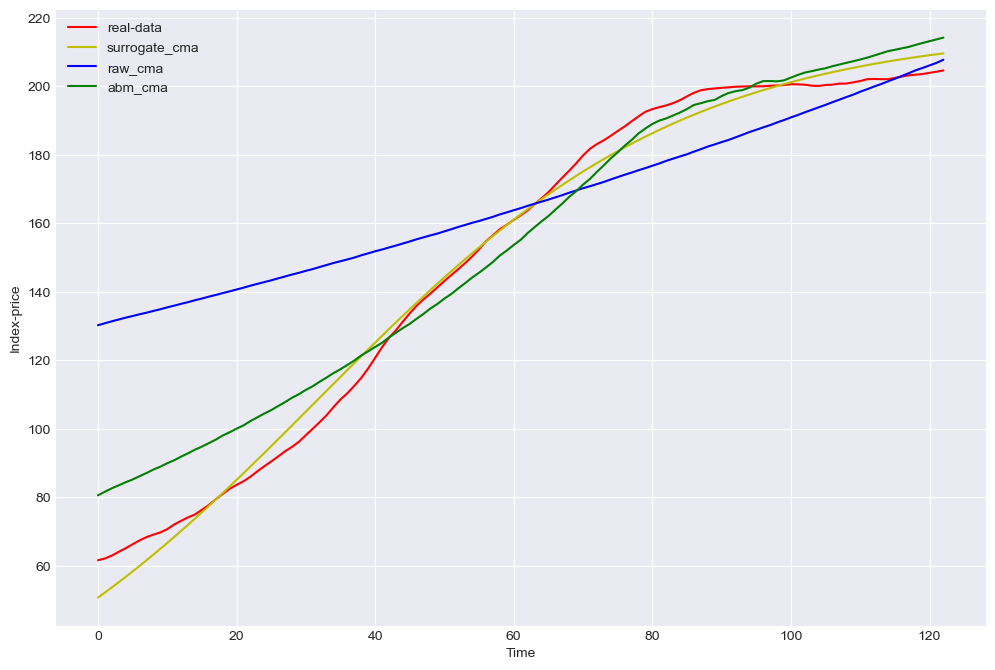

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=537742, Wed Apr 17 11:04:35 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=517065, Wed Apr 17 11:04:35 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.146864271418959e+01 1.0e+00 1.92e-02  2e-02  2e-02 0:00.0
    2     16 3.150876779417243e+01 1.4e+00 1.93e-02  2e-02  2e-02 0:00.0
    3     24 2.482420835399884e+01 1.4e+00 1.74e-02  1e-02  2e-02 0:00.0
  100    800 4.668327434552641e+00 2.4e+03 5.60e-03  4e-05  7e-03 0:01.2
NOTE (module=cma, iteration=183):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 2.2e+10 to 1.8e+05
  200   1600 4.668268327534265e+00 6.2e+02 1.65e-05  3e-09  2e-05 0:02.4
  300   2400 4.668268327535637e+00 9.6e+03 1.03e-05  4e-10  2e-05 0:03.6
  400   3200 4.668268327534234e+00 6.5e+04 1.34e-05  2e-10  1e-05 0:04.7
  500   4000 4.668268327555928e+00 3.1e+04 2.34e-04  7e-10  2e-05 0:05.9
  505   4040 4.

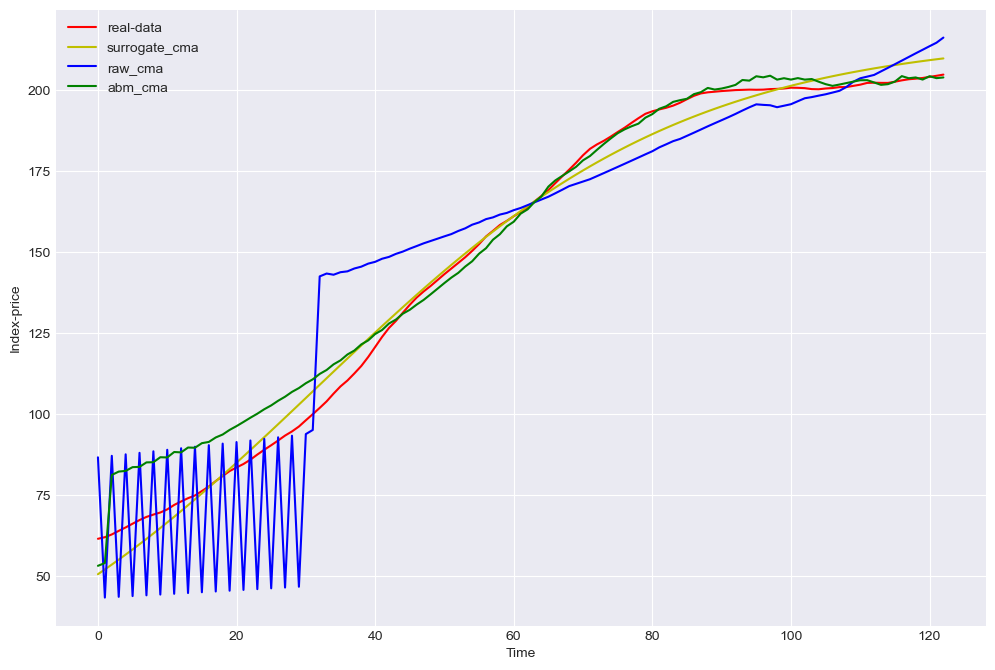

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=455250, Wed Apr 17 11:27:30 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=429704, Wed Apr 17 11:27:30 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 8.630708720523880e+01 1.0e+00 1.71e-02  1e-02  2e-02 0:00.0
    2     16 1.510389583527791e+01 1.2e+00 1.59e-02  1e-02  2e-02 0:00.0
    3     24 1.205912504858491e+01 1.5e+00 1.65e-02  1e-02  2e-02 0:00.0
  100    800 4.668270118951896e+00 1.1e+04 1.29e-03  5e-06  6e-03 0:00.9
NOTE (module=cma, iteration=134):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 3.3e+10 to 2.2e+05
  200   1600 4.668268327534157e+00 4.0e+03 1.31e-06  1e-10  5e-06 0:01.7
  300   2400 4.668268327523271e+00 3.7e+04 2.70e-06  3e-10  8e-06 0:02.5
  400   3200 4.668268327533900e+00 6.7e+05 8.85e-06  7e-10  2e-05 0:03.3


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=441)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327544614e+00 6.6e+00 6.45e-06  2e-06  5e-06 0:04.1
  562   4496 4.668268327523212e+00 2.9e+01 4.31e-06  8e-07  2e-06 0:04.6
termination on tolstagnation=198 (Wed Apr 17 11:27:35 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4497/3703 evaluations
incumbent solution: [-1.4329712015996847, 0.037489205712716966, 0.03410940766661952, -1.2790957973338664]
std deviation: [1.8470453667904381e-06, 2.1252097532135663e-06, 1.5647899317083201e-06, 7.518661846864902e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=532817, Wed Apr 17 11:27:35 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=497567, Wed Apr 17 11:27:35 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.361130453545643e+01 1.0e+00 1.86e-02  2e-02  2e-02 0:00.3
    2     18 1.328170683164814e+01 1.2e+00 1.88e-02  2e-02  2e-02 0:00.7
    3     27 1.216915128315578e+01 1.3e+00 2.01e-02  2e-02  2e-02 0:01.0
   16    144 1.380732037340

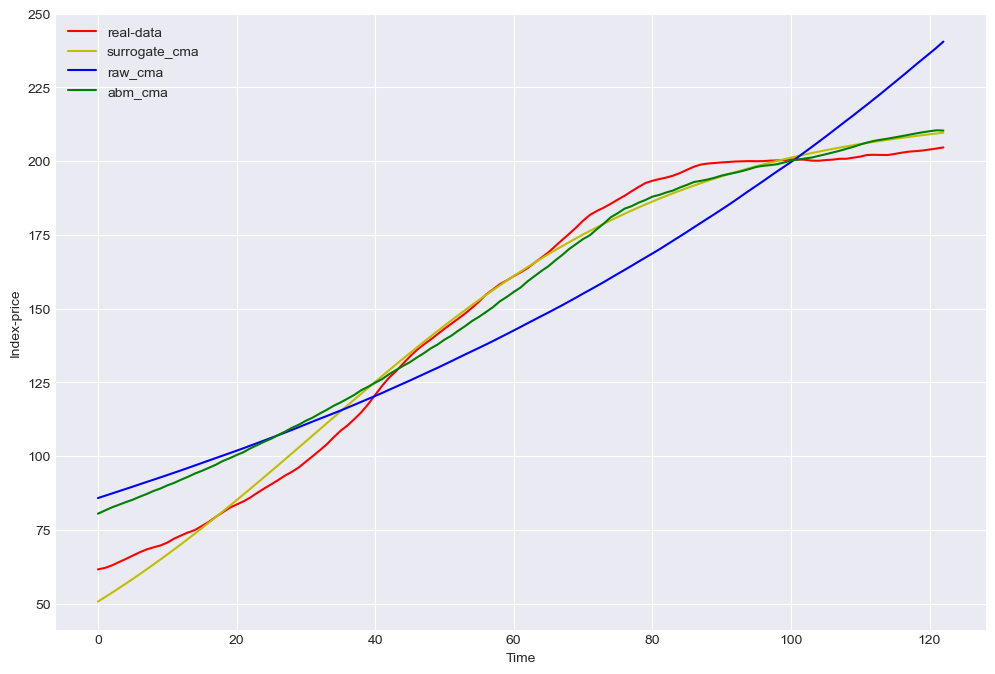

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=504150, Wed Apr 17 11:31:30 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=453714, Wed Apr 17 11:31:30 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.475540123321728e+01 1.0e+00 1.98e-02  2e-02  2e-02 0:00.0
    2     16 2.796234611158214e+01 1.3e+00 1.79e-02  2e-02  2e-02 0:00.0
    3     24 1.932466409200159e+01 1.3e+00 1.72e-02  2e-02  2e-02 0:00.0
  100    800 4.668589739953244e+00 2.5e+03 1.86e-02  2e-04  5e-02 0:00.8
NOTE (module=cma, iteration=162):  
condition in coordinate system exceeded 1.5e+08, rescaled to 1.0e+00, 
condition changed from 2.5e+10 to 1.2e+05
  200   1600 4.668268327552943e+00 4.5e+02 1.90e-05  4e-09  3e-05 0:01.8
  300   2400 4.668268327546239e+00 6.7e+02 5.09e-05  2e-09  3e-05 0:02.6
  400   3200 4.668268327544673e+00 4.4e+03 2.27e-05  5e-10  5e-06 0:03.5
  500   4000 4.668268327544610e+00 5.7e+03 4.56e-05  8e-11  7e-06 0:04.3
  600   4800 4.

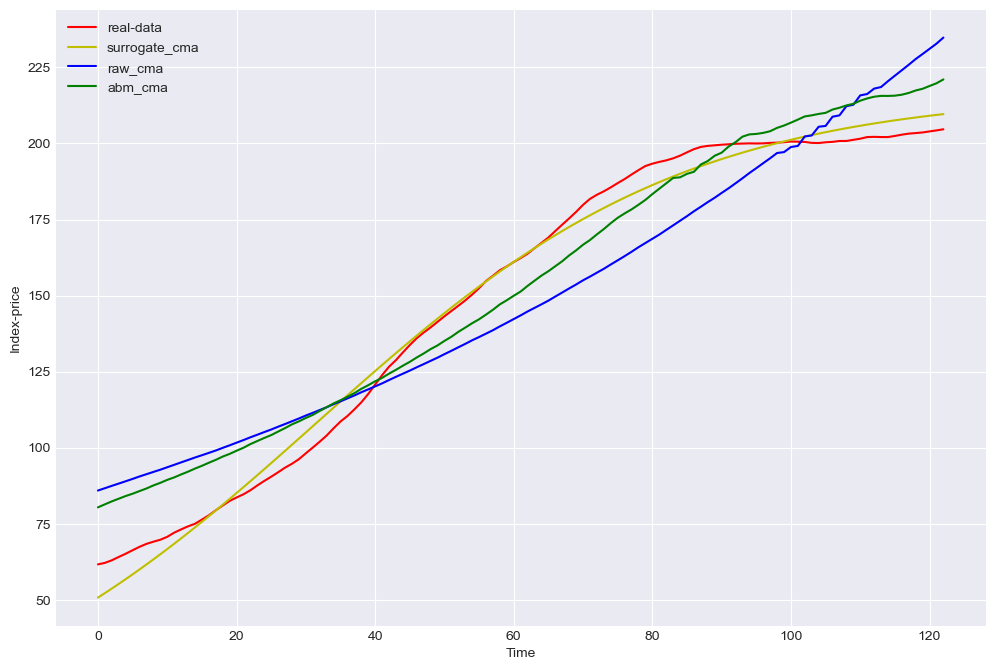

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=516612, Wed Apr 17 11:34:41 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=459800, Wed Apr 17 11:34:41 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.311616414818608e+01 1.0e+00 2.04e-02  2e-02  2e-02 0:00.0
    2     16 2.387378499206696e+01 1.4e+00 2.10e-02  2e-02  2e-02 0:00.0
    3     24 2.843903965761323e+01 1.5e+00 1.91e-02  2e-02  2e-02 0:00.0
  100    800 4.668283081218890e+00 1.9e+03 2.64e-03  2e-05  3e-03 0:00.9
  200   1600 4.668268327534503e+00 1.9e+04 2.83e-06  7e-10  1e-06 0:01.8
  300   2400 4.668268327533966e+00 1.6e+05 5.65e-06  7e-10  2e-06 0:02.7
  400   3200 4.668268327555370e+00 1.5e+00 3.54e-07  3e-07  3e-07 0:03.7


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=394)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327555380e+00 4.9e+01 2.31e-07  3e-08  3e-07 0:04.6
  525   4200 4.668268327555392e+00 9.4e+01 4.90e-07  4e-08  7e-07 0:04.9
termination on tolstagnation=198 (Wed Apr 17 11:34:47 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4201/2237 evaluations
incumbent solution: [-1.4329714931542883, 0.03748920706425815, 0.03878039007429654, 1.4215071284237477]
std deviation: [4.0599662453036454e-07, 4.3879238726962263e-08, 2.678960449429963e-07, 7.098109635831776e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=420035, Wed Apr 17 11:34:47 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=418207, Wed Apr 17 11:34:47 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.249585280197796e+01 1.0e+00 2.06e-02  2e-02  2e-02 0:00.3
    2     18 1.221701037695372e+01 1.3e+00 1.96e-02  2e-02  2e-02 0:00.6
    3     27 1.460118773564402e+01 1.4e+00 2.05e-02  2e-02  2e-02 0:00.8
   13    117 1.576165063584388

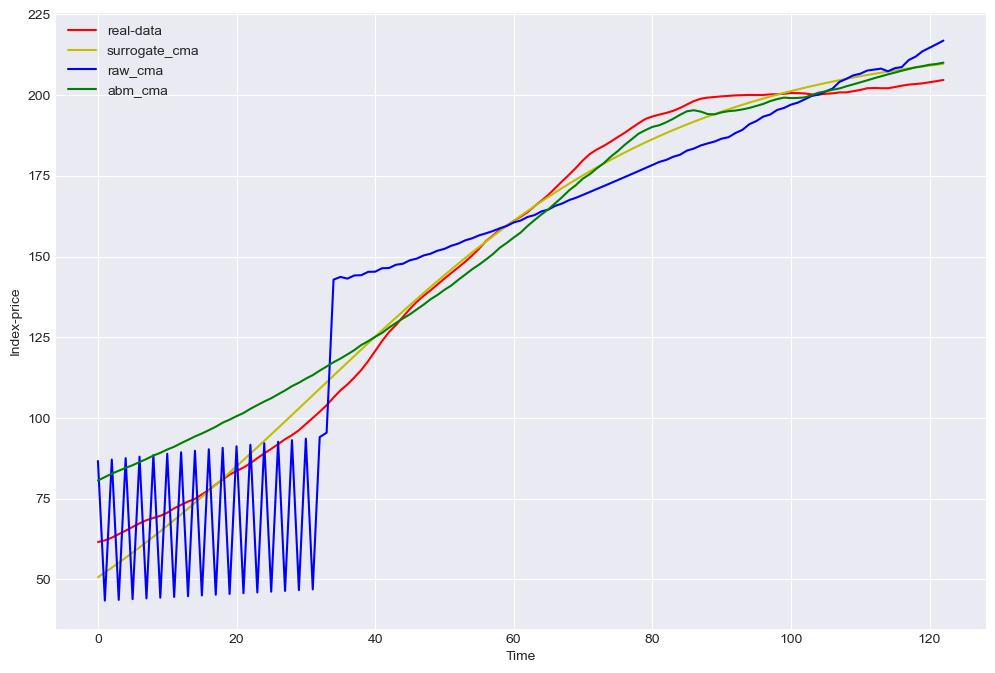

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=403483, Wed Apr 17 11:45:00 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=463233, Wed Apr 17 11:45:00 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.094180620606318e+02 1.0e+00 1.87e-02  2e-02  2e-02 0:00.0
    2     16 1.512985761520906e+01 1.3e+00 2.00e-02  2e-02  2e-02 0:00.0
    3     24 2.012336459152355e+01 1.5e+00 1.71e-02  1e-02  2e-02 0:00.0
  100    800 4.668273803381356e+00 1.6e+03 1.63e-03  1e-05  2e-03 0:01.0
  200   1600 4.668268327545103e+00 6.4e+04 5.32e-06  1e-09  4e-06 0:02.1
NOTE (module=cma, iteration=280):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.5e+11 to 2.6e+06
  300   2400 4.668268327533934e+00 1.4e+03 5.49e-06  3e-10  3e-06 0:03.3
  400   3200 4.668268327544592e+00 5.1e+03 1.01e-05  2e-10  2e-06 0:04.4
  500   4000 4.668268327533910e+00 2.4e+04 1.04e-05  1e-10  5e-07 0:05.6
  600   4800 4.

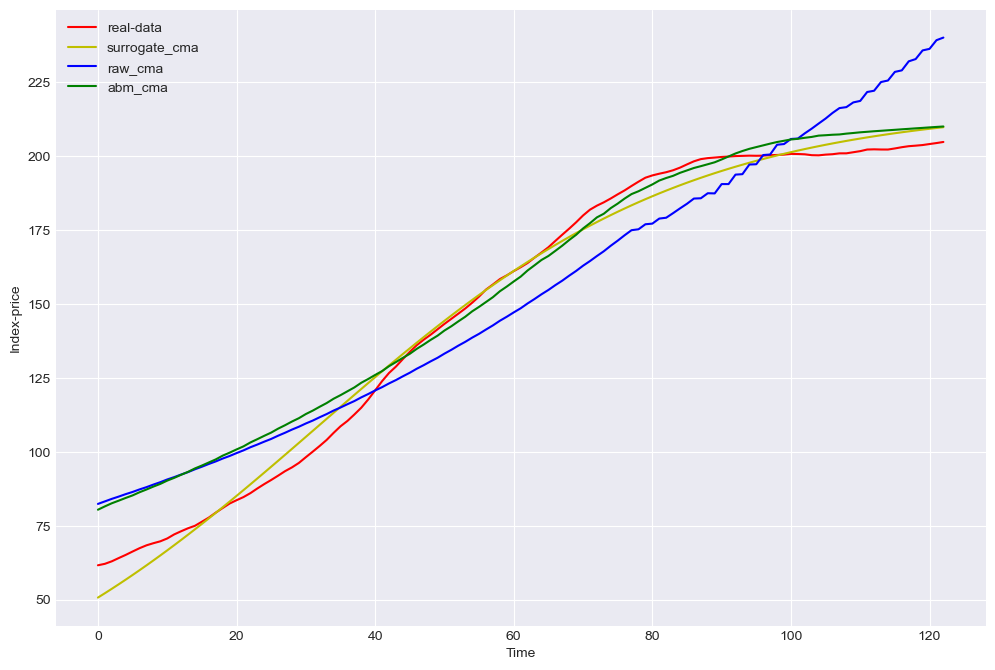

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=443143, Wed Apr 17 11:53:22 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=456114, Wed Apr 17 11:53:22 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.378579845263915e+01 1.0e+00 1.78e-02  2e-02  2e-02 0:00.0
    2     16 1.495941423896074e+01 1.3e+00 1.84e-02  2e-02  2e-02 0:00.0
    3     24 2.907602991210804e+01 1.3e+00 1.47e-02  1e-02  2e-02 0:00.0
  100    800 4.668306790371291e+00 1.6e+03 6.97e-03  7e-05  9e-03 0:01.0
  200   1600 4.668268327534970e+00 5.8e+04 4.35e-06  1e-09  5e-06 0:02.2
  300   2400 4.668268327544606e+00 9.1e+04 1.15e-05  5e-10  3e-06 0:03.3


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=381)
  warnings.warn(msg + ' (' +


  400   3200 4.668268327544586e+00 3.6e+00 6.82e-06  4e-06  1e-05 0:04.4
  500   4000 4.668268327533879e+00 2.6e+01 1.08e-06  2e-07  8e-07 0:05.6
  535   4280 4.668268327555289e+00 5.0e+01 5.36e-07  1e-07  2e-07 0:06.0
termination on tolstagnation=198 (Wed Apr 17 11:53:29 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4281/2933 evaluations
incumbent solution: [-1.4329712394307519, 0.037489205822761315, 0.039004829252969164, 1.5512710632588007]
std deviation: [9.783572075540663e-08, 1.1386850219227074e-07, 1.0579516506846434e-07, 2.0560958475743332e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=454877, Wed Apr 17 11:53:29 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=445662, Wed Apr 17 11:53:29 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.220354899207528e+01 1.0e+00 1.90e-02  2e-02  2e-02 0:00.5
    2     18 1.241488829155415e+01 1.3e+00 1.84e-02  2e-02  2e-02 0:00.9
    3     27 1.280248684378

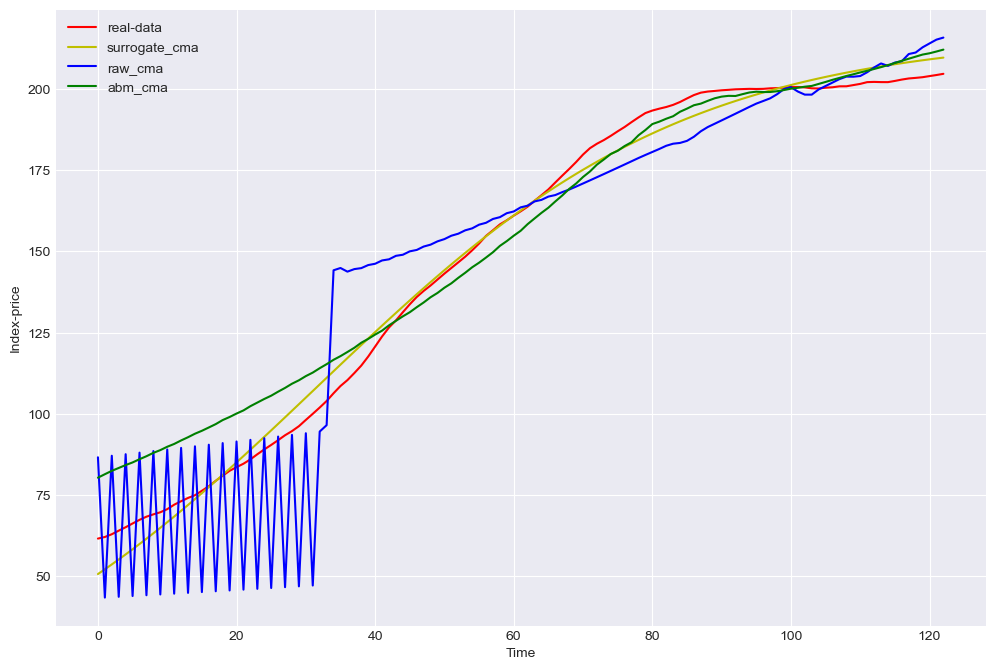

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=411493, Wed Apr 17 12:03:59 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=408109, Wed Apr 17 12:03:59 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 9.678312308570480e+01 1.0e+00 1.67e-02  2e-02  2e-02 0:00.0
    2     16 2.182335454515039e+01 1.2e+00 1.67e-02  1e-02  2e-02 0:00.0
    3     24 1.065507238763038e+01 1.5e+00 2.02e-02  2e-02  2e-02 0:00.0
  100    800 4.668287324680510e+00 2.1e+03 4.13e-03  3e-05  5e-03 0:01.1
NOTE (module=cma, iteration=194):  
condition in coordinate system exceeded 1.3e+08, rescaled to 1.0e+00, 
condition changed from 1.0e+10 to 9.4e+04
  200   1600 4.668268327545158e+00 2.0e+02 1.29e-05  2e-09  1e-05 0:02.2
  300   2400 4.668268327544864e+00 1.3e+03 7.14e-06  2e-10  7e-06 0:03.4
  400   3200 4.668268327533932e+00 5.5e+03 2.24e-05  2e-10  1e-05 0:04.8
  500   4000 4.668268327533912e+00 5.9e+03 7.87e-06  2e-11  4e-07 0:06.1
  520   4160 4.

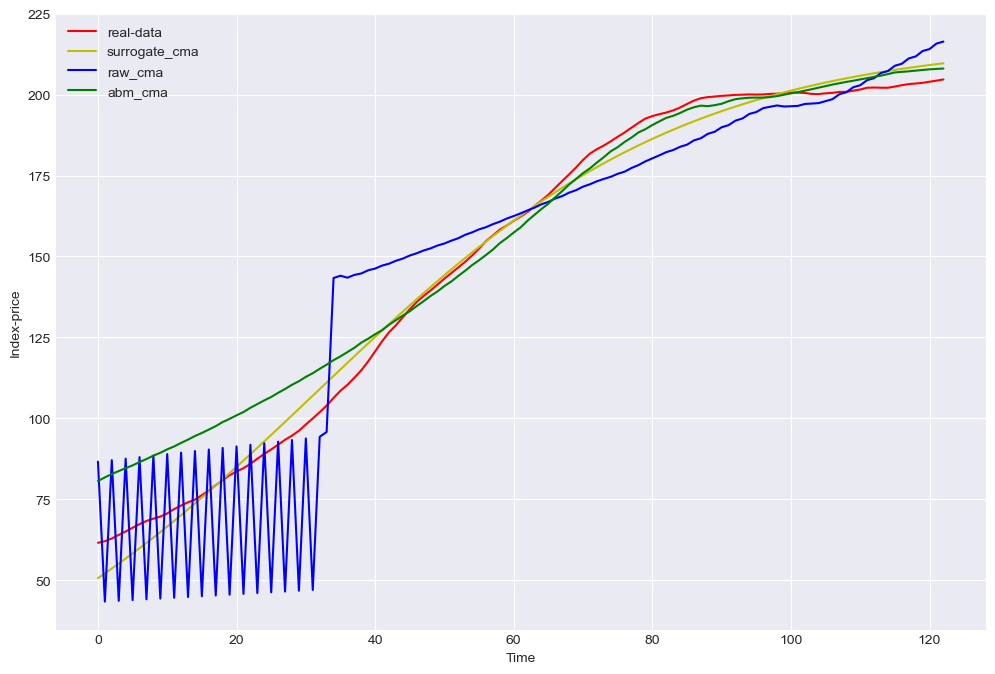

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=435243, Wed Apr 17 12:16:26 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=485168, Wed Apr 17 12:16:26 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.708478992263662e+01 1.0e+00 1.96e-02  2e-02  2e-02 0:00.0
    2     16 1.398690607453598e+01 1.3e+00 1.85e-02  2e-02  2e-02 0:00.0
    3     24 1.285919280352106e+01 1.5e+00 2.03e-02  2e-02  2e-02 0:00.0
  100    800 4.668412302271797e+00 2.6e+03 4.45e-03  4e-05  9e-03 0:01.0
  200   1600 4.668268327534387e+00 4.0e+04 8.59e-06  2e-09  7e-06 0:02.3
  300   2400 4.668268327534058e+00 2.4e+04 1.19e-05  1e-09  1e-06 0:03.3
  400   3200 4.668268327544576e+00 3.2e+05 6.60e-06  3e-10  5e-07 0:04.3
  500   4000 4.668268327544600e+00 3.0e+05 1.13e-05  1e-10  2e-07 0:05.3
  600   4800 4.668268327544568e+00 3.8e+05 4.33e-05  9e-11  2e-07 0:06.3
  610   4880 4.668268327544581e+00 2.7e+05 4.96e-05  8e-11  2e-07 0:06.4
termination on tol

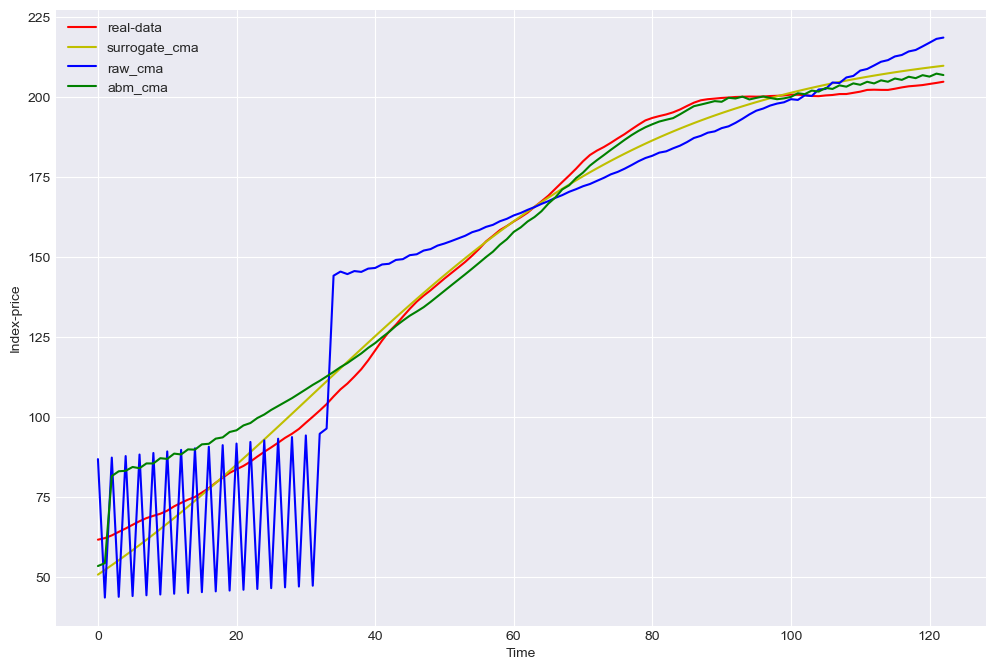

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=428756, Wed Apr 17 12:29:44 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=404681, Wed Apr 17 12:29:44 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.662377135403362e+01 1.0e+00 1.89e-02  2e-02  2e-02 0:00.0
    2     16 1.962434783687263e+01 1.2e+00 1.76e-02  2e-02  2e-02 0:00.0
    3     24 2.764157604229430e+01 1.3e+00 2.04e-02  2e-02  2e-02 0:00.0
  100    800 4.668338424120217e+00 1.3e+03 8.45e-03  7e-05  8e-03 0:00.9
NOTE (module=cma, iteration=181):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 3.3e+09 to 2.1e+04
  200   1600 4.668268327534317e+00 1.7e+02 3.93e-06  3e-10  3e-06 0:02.0
  300   2400 4.668268327523286e+00 3.5e+02 1.64e-05  4e-10  4e-06 0:03.0
  400   3200 4.668268327544559e+00 1.5e+02 1.02e-06  4e-12  5e-08 0:04.1
  500   4000 4.668268327544570e+00 1.4e+03 4.24e-07  9e-13  9e-09 0:05.3
  537   4296 4.

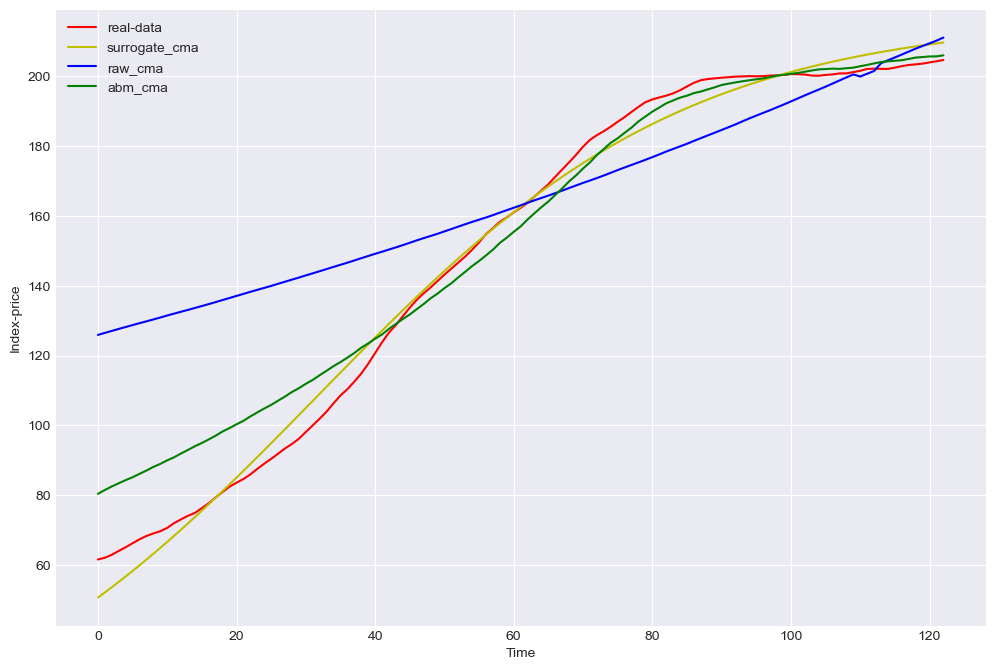

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=544602, Wed Apr 17 12:39:07 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=544508, Wed Apr 17 12:39:07 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.015890023324598e+01 1.0e+00 2.02e-02  2e-02  2e-02 0:00.0
    2     16 2.033687391985312e+01 1.5e+00 1.79e-02  1e-02  2e-02 0:00.0
    3     24 2.227296895811649e+01 1.6e+00 1.84e-02  1e-02  2e-02 0:00.0
  100    800 4.668400873358003e+00 9.5e+03 8.92e-03  7e-05  4e-02 0:01.1
  200   1600 4.668268327544741e+00 1.8e+05 4.21e-06  9e-10  5e-06 0:02.2
  300   2400 4.668268327533892e+00 7.7e+05 8.31e-06  1e-09  4e-06 0:03.3


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=378)
  warnings.warn(msg + ' (' +


  400   3200 4.668268327544808e+00 2.3e+00 1.13e-05  7e-06  1e-05 0:04.5
  500   4000 4.668268327544724e+00 1.0e+01 1.77e-06  1e-07  7e-07 0:05.6
  600   4800 4.668268327534001e+00 8.4e+00 3.27e-07  8e-09  1e-08 0:06.8
  625   5000 4.668268327544725e+00 5.1e+01 4.40e-07  1e-08  3e-08 0:07.1
termination on tolstagnation=198 (Wed Apr 17 12:39:16 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 5001/3443 evaluations
incumbent solution: [-1.4329714539398348, 0.0374892072395039, 0.04164990635382956, 3.08056378962997]
std deviation: [3.439693221245365e-08, 1.9789692330370634e-08, 1.8157952393346557e-08, 1.3466036717987368e-08]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=460090, Wed Apr 17 12:39:16 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=392061, Wed Apr 17 12:39:16 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.127947533850583e+01 1.0e+00 1.82e-02  2e-02  2e-02 0:00.5
    2     18 2.346520307725043e+

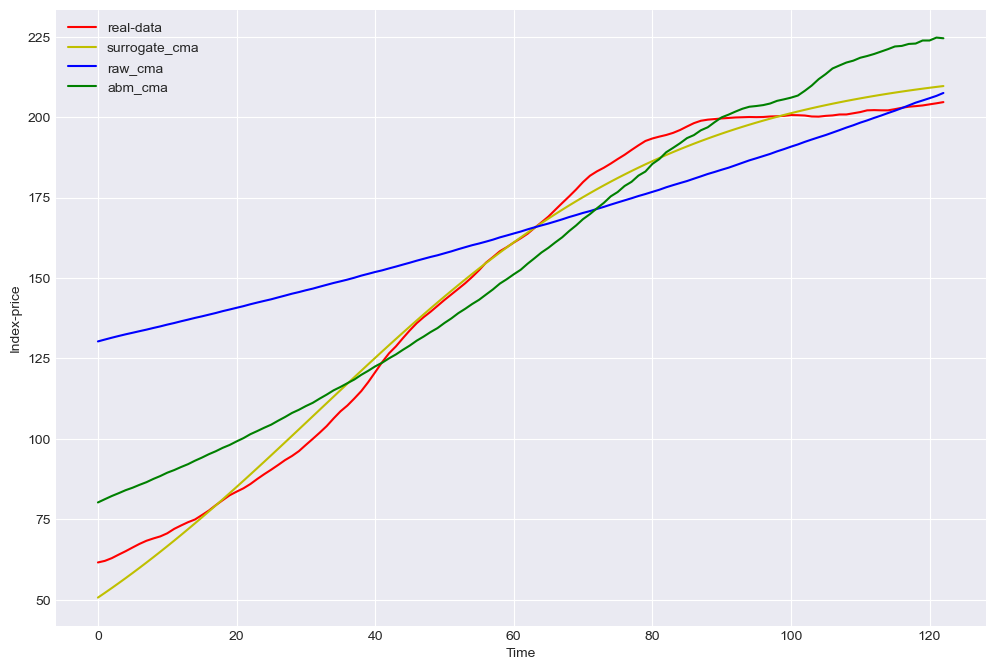

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=407478, Wed Apr 17 12:43:13 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=402808, Wed Apr 17 12:43:13 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 9.647479624443498e+00 1.0e+00 2.02e-02  2e-02  2e-02 0:00.0
    2     16 1.464891611445632e+01 1.5e+00 1.95e-02  2e-02  2e-02 0:00.0
    3     24 1.156866334376408e+01 1.5e+00 1.65e-02  1e-02  2e-02 0:00.1
  100    800 4.668781953722847e+00 7.1e+03 2.29e-02  2e-04  1e-01 0:01.4
NOTE (module=cma, iteration=135):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 1.8e+10 to 1.1e+05
  200   1600 4.668268327555620e+00 1.1e+04 3.60e-05  3e-09  7e-04 0:02.9
  300   2400 4.668268327544593e+00 1.7e+04 8.30e-06  2e-10  2e-05 0:04.3
  400   3200 4.668268327544610e+00 7.2e+04 9.44e-06  8e-11  8e-06 0:05.9
  500   4000 4.668268327544595e+00 1.0e+06 2.85e-06  1e-11  1e-06 0:07.6
  505   4040 4.

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=501)
  warnings.warn(msg + ' (' +


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.210465603193306e+01 1.0e+00 1.87e-02  2e-02  2e-02 0:00.6
    2     18 3.929169990877236e+01 1.3e+00 1.83e-02  2e-02  2e-02 0:01.0
    3     27 1.191976333197031e+01 1.4e+00 1.69e-02  1e-02  2e-02 0:01.3
   11     99 1.866816324573555e+01 2.2e+00 1.99e-02  2e-02  2e-02 0:04.4
   19    171 1.259323685493712e+01 2.6e+00 1.81e-02  1e-02  2e-02 0:08.7
   29    261 1.255715744615167e+01 5.5e+00 1.68e-02  6e-03  2e-02 0:13.8
   45    405 1.041611609416869e+01 8.2e+00 1.12e-02  2e-03  2e-02 0:19.8
   63    567 1.019806777220040e+01 2.2e+01 4.92e-03  5e-04  8e-03 0:26.9
   84    756 1.025353538890863e+01 4.0e+01 4.02e-03  3e-04  7e-03 0:35.0
  100    900 1.006389157356737e+01 3.8e+01 2.47e-03  2e-04  4e-03 0:40.9
  130   1170 1.038704318522911e+01 6.2e+01 1.34e-03  8e-05  2e-03 0:51.0
  165   1485 1.039334019618251e+01 1.0e+02 6.03e-04  2e-05  7e-04 1:02.3
  200   1800 1.062611230539721e+01 1.2e+02 3.81e-04 

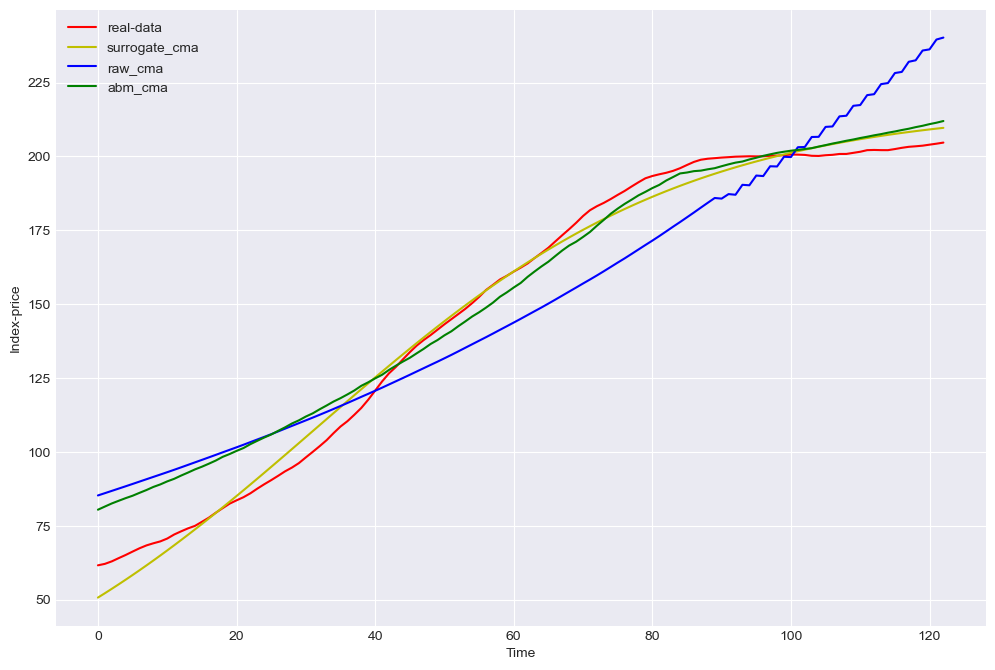

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=471552, Wed Apr 17 12:47:52 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=434130, Wed Apr 17 12:47:52 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.036203925905056e+01 1.0e+00 2.09e-02  2e-02  2e-02 0:00.0
    2     16 2.571991861969920e+01 1.2e+00 2.05e-02  2e-02  2e-02 0:00.0
    3     24 2.548718814780460e+01 1.5e+00 1.98e-02  2e-02  2e-02 0:00.0
  100    800 4.668286376457142e+00 2.7e+03 2.81e-03  2e-05  4e-03 0:01.1
  200   1600 4.668268327535568e+00 1.3e+05 7.33e-06  2e-09  1e-05 0:02.3
NOTE (module=cma, iteration=263):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 5.9e+10 to 4.7e+05
  300   2400 4.668268327533903e+00 8.0e+02 2.54e-06  8e-11  6e-07 0:03.5
  400   3200 4.668268327544648e+00 1.2e+03 1.14e-05  2e-10  1e-06 0:04.9
  500   4000 4.668268327544581e+00 8.5e+03 4.28e-06  3e-11  2e-07 0:06.4
  591   4728 4.

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=699)
  warnings.warn(msg + ' (' +


  700   6300 1.114845946764262e+01 1.0e+00 2.40e-05  2e-05  2e-05 3:19.5
  750   6750 1.156239083643230e+01 3.4e+00 2.82e-05  2e-05  3e-05 3:32.5
termination on tolstagnation=256 (Wed Apr 17 12:51:35 2024)
final/bestever f-value = 1.173798e+01 1.026032e+01 after 6751/668 evaluations
incumbent solution: [50.67008571937913, -0.021093864532303996, -0.013969516833874707, 233.50419337349012, 0.2416409628931433, 3.8693369432585314]
std deviation: [1.6959728113684205e-05, 2.247838896878169e-05, 2.0497461829461118e-05, 2.2412655478661337e-05, 1.8615907474123963e-05, 2.6476677924656914e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=439723, Wed Apr 17 12:51:35 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=449297, Wed Apr 17 12:51:35 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.287244509690865e+02 1.0e+00 2.07e-02  2e-02  2e-02 0:00.4
    2     18 2.100334784745690e+02 1.4e+00 2.37e-02  2e-02  3e-02 0:00.7
    3     27 

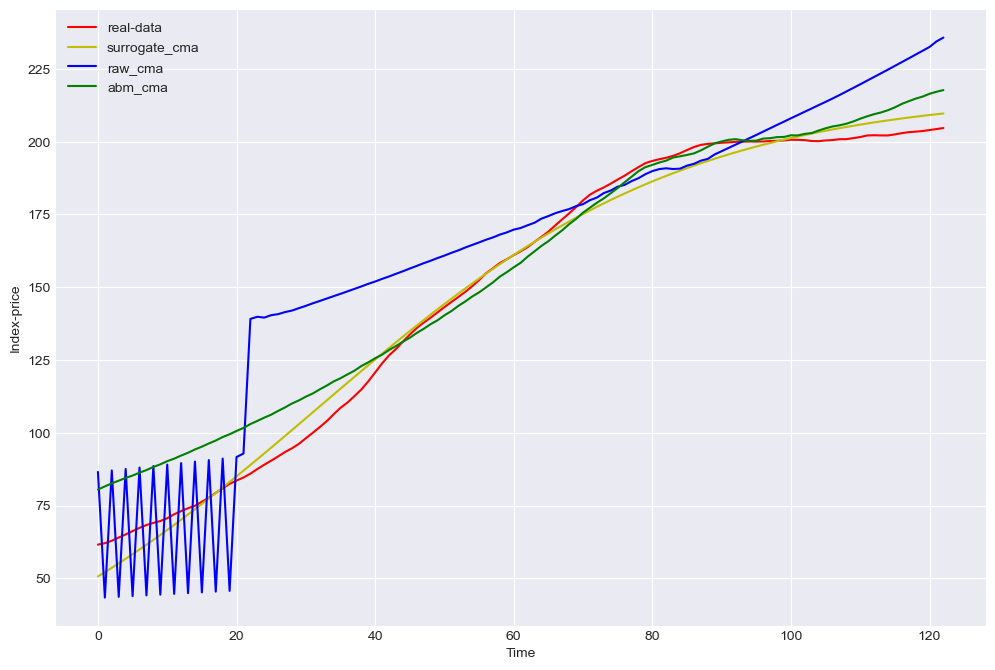

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=457564, Wed Apr 17 12:52:17 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=479847, Wed Apr 17 12:52:17 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.558908740190876e+01 1.0e+00 2.16e-02  2e-02  3e-02 0:00.0
    2     16 1.428522791305253e+01 1.4e+00 2.42e-02  2e-02  3e-02 0:00.0
    3     24 2.615479438909494e+01 1.7e+00 2.32e-02  2e-02  3e-02 0:00.0
  100    800 4.669092758649808e+00 2.5e+03 2.09e-02  2e-04  6e-02 0:01.1
NOTE (module=cma, iteration=174):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 8.0e+09 to 2.5e+04
  200   1600 4.668268327526126e+00 5.3e+02 5.14e-05  1e-08  2e-04 0:02.4
  300   2400 4.668268327524820e+00 5.2e+03 7.38e-05  4e-09  1e-04 0:03.7
  400   3200 4.668268327534030e+00 2.5e+04 2.13e-05  3e-10  2e-05 0:04.9
  500   4000 4.668268327555391e+00 7.0e+04 4.50e-06  1e-11  1e-06 0:06.0
  555   4440 4.

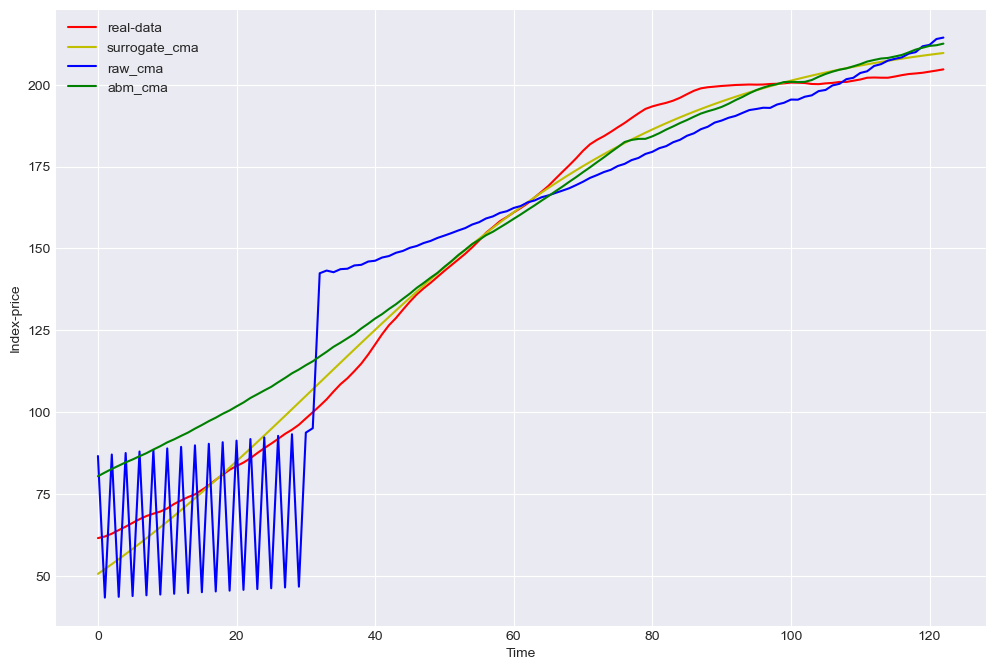

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=439275, Wed Apr 17 13:01:15 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=419960, Wed Apr 17 13:01:15 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.230592193057072e+01 1.0e+00 2.21e-02  2e-02  2e-02 0:00.0
    2     16 2.384300371864215e+01 1.4e+00 2.27e-02  2e-02  3e-02 0:00.0
    3     24 2.989931456583191e+01 1.8e+00 2.41e-02  2e-02  3e-02 0:00.0
  100    800 4.668325885499241e+00 2.4e+03 3.39e-03  4e-05  5e-03 0:00.9
  200   1600 4.668268327545001e+00 1.9e+04 7.08e-06  9e-10  3e-06 0:01.9
  300   2400 4.668268327533909e+00 1.3e+04 1.77e-06  6e-11  9e-08 0:02.9
  400   3200 4.668268327533886e+00 4.6e+04 3.09e-06  9e-11  4e-08 0:03.9
  500   4000 4.668268327533924e+00 1.1e+05 2.16e-07  8e-13  4e-10 0:05.0
  505   4040 4.668268327533891e+00 1.2e+05 2.47e-07  8e-13  6e-10 0:05.1
termination on tolstagnation=198 (Wed Apr 17 13:01:21 2024)
final/bestever f-value = 4.6682

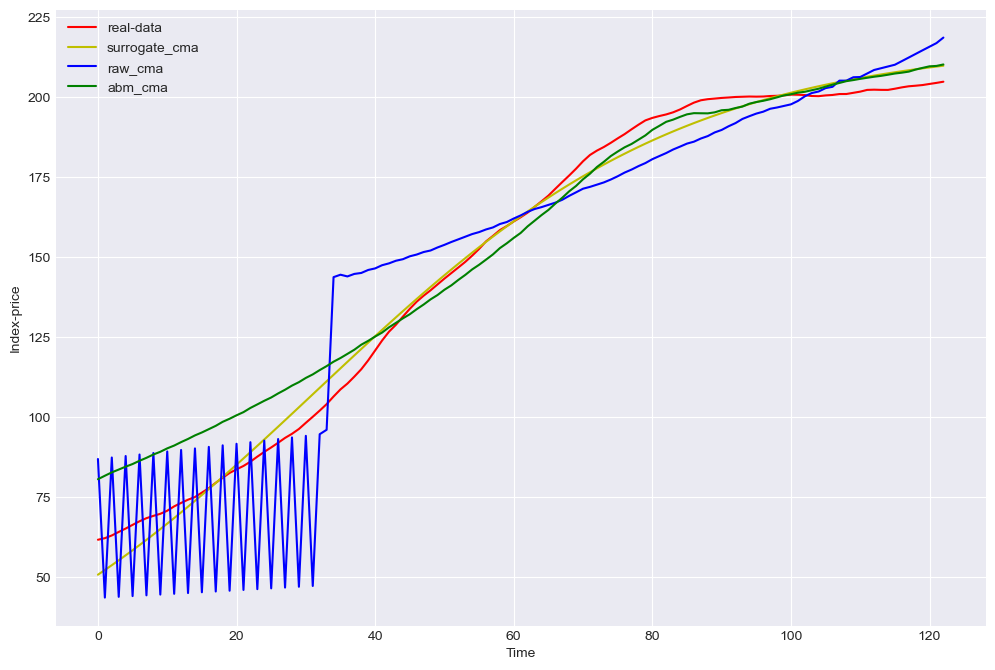

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=419390, Wed Apr 17 13:35:58 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=446812, Wed Apr 17 13:35:58 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.572936453828827e+01 1.0e+00 1.85e-02  2e-02  2e-02 0:00.0
    2     16 2.595523120605896e+01 1.4e+00 1.94e-02  2e-02  2e-02 0:00.0
    3     24 1.318179092328916e+01 1.5e+00 1.58e-02  1e-02  2e-02 0:00.0
  100    800 4.668268541668012e+00 2.6e+03 9.94e-04  5e-06  1e-03 0:01.0
  200   1600 4.668268327544841e+00 4.4e+04 7.49e-06  2e-09  5e-06 0:02.0
  300   2400 4.668268327544624e+00 5.2e+05 3.00e-06  3e-10  6e-07 0:02.9


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=317)
  warnings.warn(msg + ' (' +


  400   3200 4.668268327533871e+00 1.1e+01 7.19e-06  1e-06  4e-06 0:03.9
  500   4000 4.668268327533875e+00 6.7e+01 4.16e-06  3e-07  1e-06 0:04.8
  600   4800 4.668268327544578e+00 3.1e+02 4.83e-07  4e-09  5e-08 0:05.6
  700   5600 4.668268327533880e+00 7.8e+02 9.31e-08  2e-10  2e-09 0:06.5
  790   6320 4.668268327544557e+00 7.8e+02 3.76e-07  4e-10  2e-09 0:07.3
termination on tolstagnation=198 (Wed Apr 17 13:36:06 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 6321/4172 evaluations
incumbent solution: [-1.4329712935861096, 0.03748920591657948, 0.035549458763816266, -0.44650713226177174]
std deviation: [1.1034509470017658e-09, 4.0764905425454024e-10, 1.3845994710752602e-09, 1.7641781434119312e-09]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=527934, Wed Apr 17 13:36:06 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=503735, Wed Apr 17 13:36:06 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.0175784833

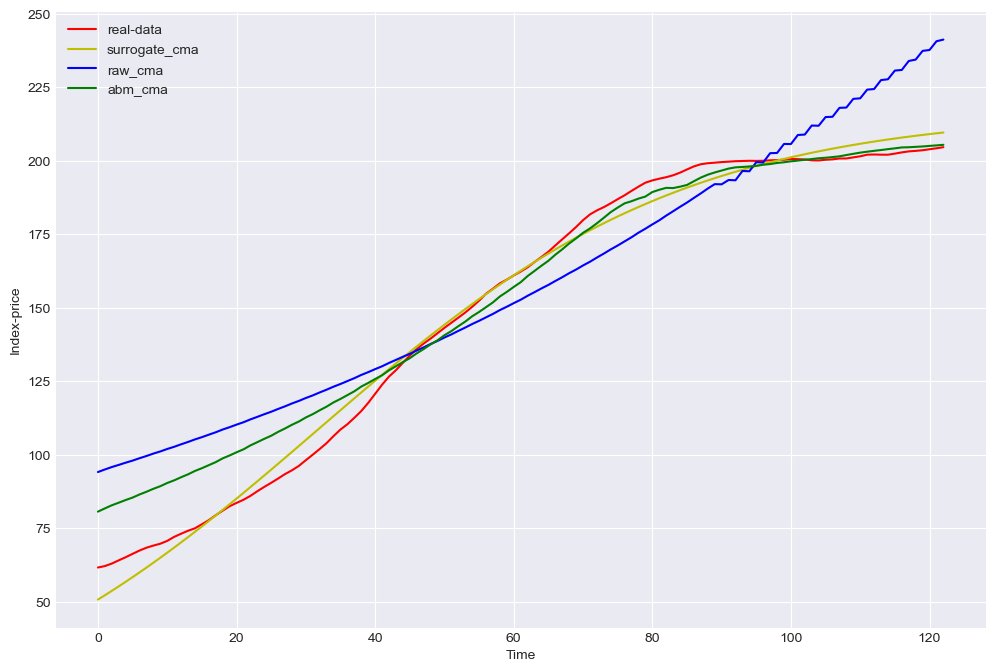

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=414266, Wed Apr 17 13:39:25 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=476088, Wed Apr 17 13:39:25 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.007839058405413e+01 1.0e+00 1.86e-02  2e-02  2e-02 0:00.0
    2     16 2.076172761069939e+01 1.2e+00 1.50e-02  1e-02  2e-02 0:00.0
    3     24 2.242294414296508e+01 1.3e+00 1.31e-02  1e-02  1e-02 0:00.0
  100    800 4.668456290475151e+00 1.9e+03 1.04e-02  8e-05  1e-02 0:00.8
NOTE (module=cma, iteration=177):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 1.7e+10 to 7.6e+04
  200   1600 4.668268327546897e+00 3.5e+02 3.12e-05  3e-09  5e-05 0:01.6
  300   2400 4.668268327533899e+00 8.0e+02 4.03e-06  5e-11  1e-06 0:02.4
  400   3200 4.668268327555334e+00 7.7e+03 2.56e-05  2e-10  4e-06 0:03.3
  500   4000 4.668268327544685e+00 8.8e+04 3.62e-05  5e-10  4e-06 0:04.1
  525   4200 4.

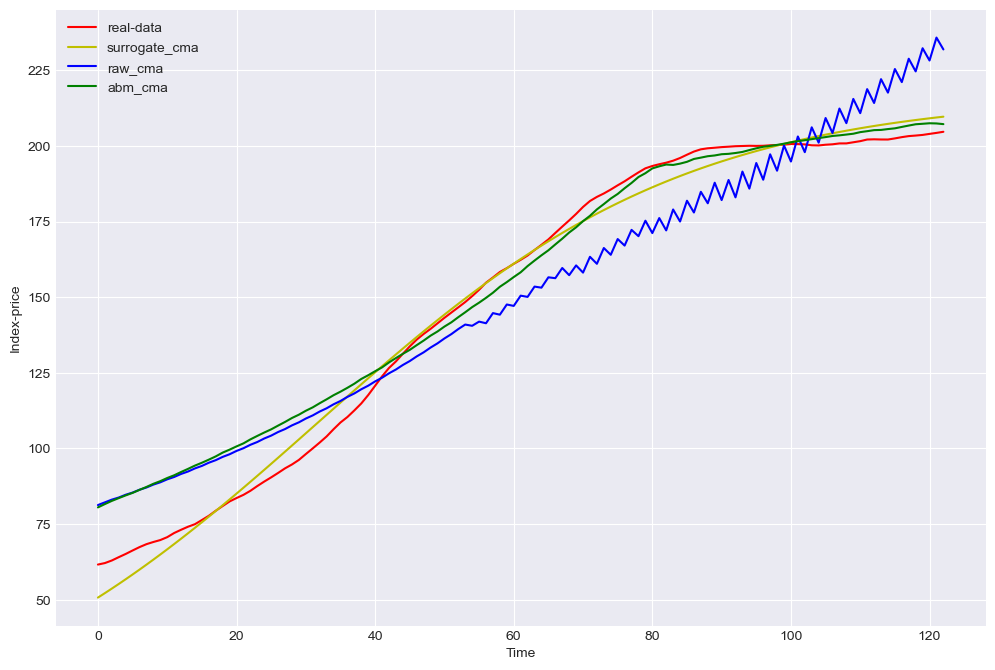

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=458591, Wed Apr 17 13:44:37 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=550219, Wed Apr 17 13:44:37 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.456935185391953e+01 1.0e+00 2.23e-02  2e-02  3e-02 0:00.0
    2     16 2.483050079240390e+01 1.3e+00 2.01e-02  2e-02  2e-02 0:00.0
    3     24 1.082511368143566e+01 1.4e+00 1.85e-02  2e-02  2e-02 0:00.0
  100    800 4.668286268908713e+00 2.4e+03 5.01e-03  4e-05  9e-03 0:00.9
NOTE (module=cma, iteration=160):  
condition in coordinate system exceeded 1.4e+08, rescaled to 1.0e+00, 
condition changed from 1.4e+10 to 7.2e+04
  200   1600 4.668268327534468e+00 4.4e+02 1.90e-05  4e-09  4e-05 0:01.7
  300   2400 4.668268327555943e+00 6.6e+02 7.33e-06  3e-10  3e-06 0:02.8
  400   3200 4.668268327513037e+00 2.6e+03 9.86e-07  6e-12  1e-07 0:03.9
  500   4000 4.668268327534448e+00 9.8e+03 2.46e-05  1e-10  3e-06 0:04.7
  505   4040 4.

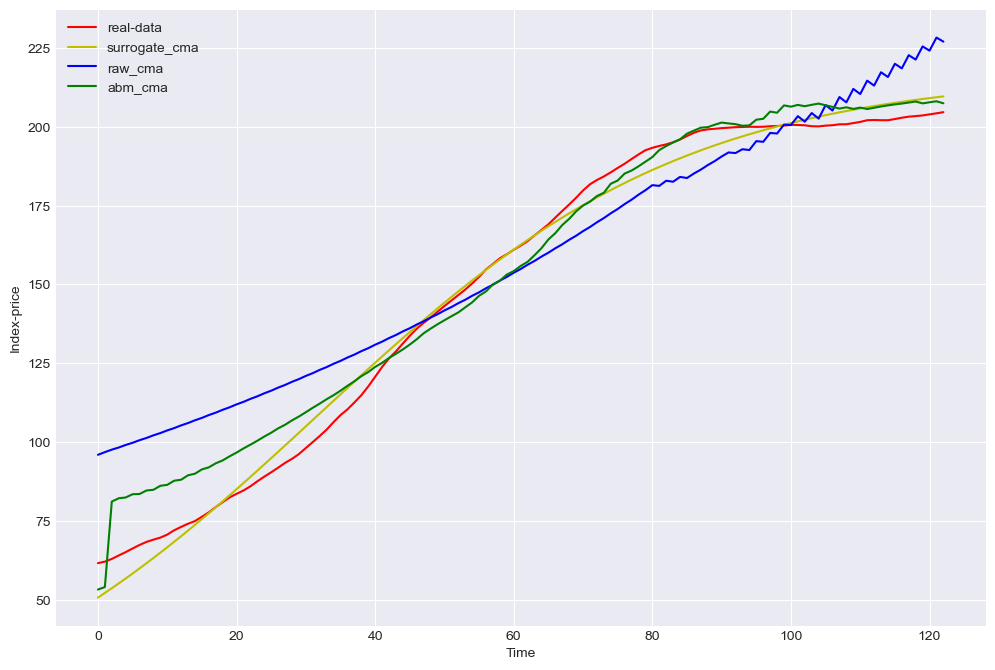

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=529410, Wed Apr 17 13:53:35 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=508331, Wed Apr 17 13:53:35 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.975113358084171e+01 1.0e+00 1.77e-02  2e-02  2e-02 0:00.0
    2     16 1.536353588751295e+01 1.2e+00 1.83e-02  1e-02  2e-02 0:00.0
    3     24 1.944976953624702e+01 1.6e+00 1.96e-02  1e-02  2e-02 0:00.0
  100    800 4.668332647087364e+00 2.4e+03 6.09e-03  5e-05  1e-02 0:01.4
  200   1600 4.668268327545058e+00 7.9e+04 3.05e-05  4e-09  4e-05 0:03.5
NOTE (module=cma, iteration=205):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 7.9e+09 to 5.5e+04
  300   2400 4.668268327545991e+00 7.1e+02 2.50e-06  1e-10  2e-07 0:04.8
  400   3200 4.668268327535261e+00 1.8e+03 1.24e-05  3e-10  1e-06 0:06.1
  500   4000 4.668268327545931e+00 1.3e+04 1.76e-06  5e-12  8e-08 0:07.6
  600   4800 4.

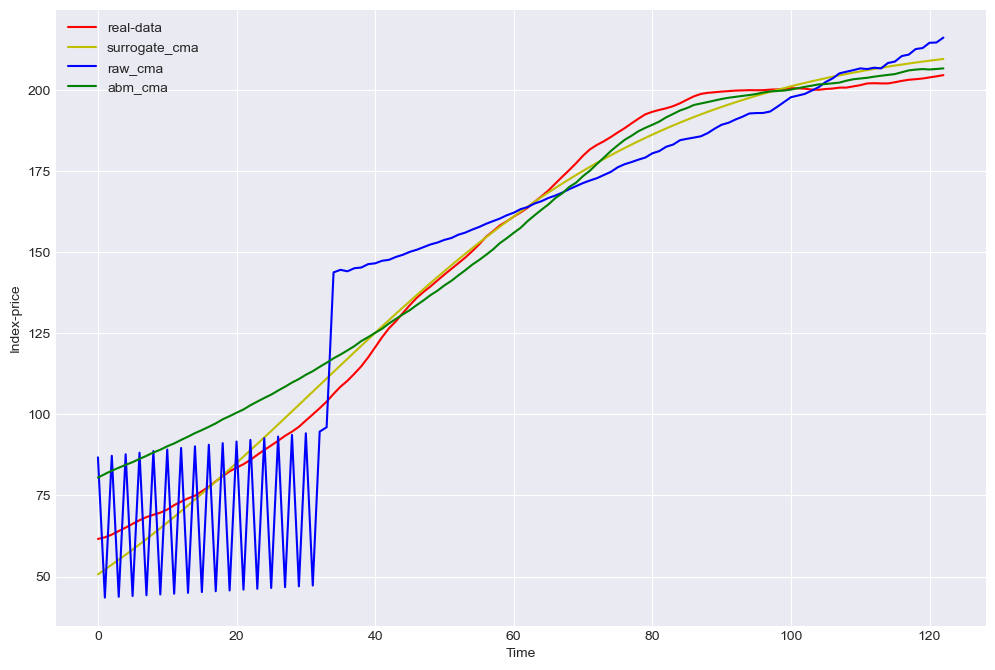

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=541490, Wed Apr 17 14:03:53 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=488854, Wed Apr 17 14:03:53 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.280154244243866e+01 1.0e+00 1.96e-02  2e-02  2e-02 0:00.0
    2     16 1.783931295253073e+01 1.3e+00 1.74e-02  1e-02  2e-02 0:00.0
    3     24 2.485408310099789e+01 1.5e+00 1.99e-02  2e-02  2e-02 0:00.0
  100    800 4.668306646235640e+00 1.8e+03 2.49e-03  2e-05  5e-03 0:00.9
  200   1600 4.668268327542843e+00 9.7e+04 2.27e-05  7e-09  7e-05 0:01.8
NOTE (module=cma, iteration=208):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.3e+10 to 1.1e+05
  300   2400 4.668268327544698e+00 2.0e+03 6.23e-06  2e-10  9e-06 0:02.8
  400   3200 4.668268327533872e+00 2.2e+03 8.27e-05  6e-10  4e-05 0:03.7
  500   4000 4.668268327544612e+00 4.4e+03 1.41e-04  5e-10  1e-05 0:04.7
  505   4040 4.

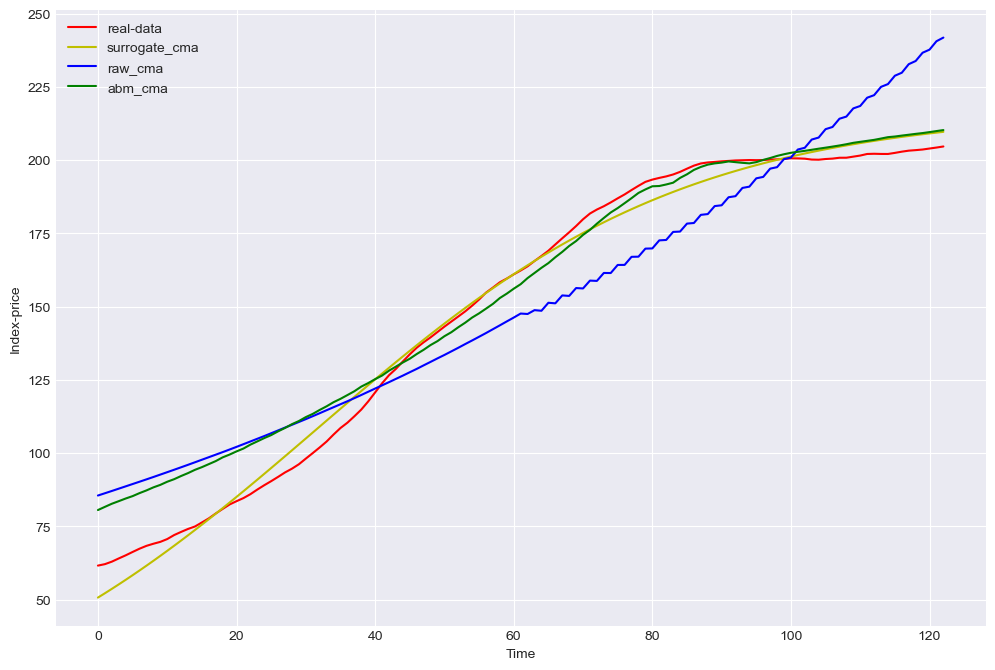

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=437016, Wed Apr 17 14:09:07 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=486788, Wed Apr 17 14:09:07 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.666780940031203e+01 1.0e+00 1.87e-02  2e-02  2e-02 0:00.0
    2     16 1.832584093798652e+01 1.2e+00 1.69e-02  2e-02  2e-02 0:00.0
    3     24 1.742354347383779e+01 1.2e+00 1.51e-02  1e-02  2e-02 0:00.0
  100    800 4.668268677870031e+00 1.8e+03 9.68e-04  5e-06  8e-04 0:00.8
  200   1600 4.668268327535523e+00 3.2e+05 5.21e-06  7e-10  5e-06 0:01.6
NOTE (module=cma, iteration=217):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 1.5e+11 to 1.4e+06
  300   2400 4.668268327524409e+00 9.3e+03 4.63e-05  4e-09  4e-05 0:03.1
  400   3200 4.668268327534267e+00 8.5e+04 1.49e-05  4e-10  8e-06 0:05.0
  500   4000 4.668268327534140e+00 2.6e+05 9.37e-06  1e-10  2e-06 0:07.2


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=594)
  warnings.warn(msg + ' (' +


  600   4800 4.668268327534169e+00 1.8e+00 7.08e-06  6e-06  8e-06 0:11.6
  615   4920 4.668268327544856e+00 3.1e+00 1.71e-06  9e-07  1e-06 0:12.2
termination on tolstagnation=198 (Wed Apr 17 14:09:21 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4921/3938 evaluations
incumbent solution: [-1.4329711691425473, 0.037489206550333165, 0.03798676177029847, 0.9626582814380527]
std deviation: [9.19088849559452e-07, 1.3592082604333668e-06, 1.1975877120553495e-06, 1.0317349180639089e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=476729, Wed Apr 17 14:09:21 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=512982, Wed Apr 17 14:09:21 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.225319803601937e+01 1.0e+00 1.95e-02  2e-02  2e-02 0:01.6
    2     18 1.150205896496986e+01 1.3e+00 2.02e-02  2e-02  2e-02 0:03.2
    3     27 1.252951655374218e+01 1.4e+00 1.79e-02  2e-02  2e-02 15:29.4
   13    117 1.0886961951877

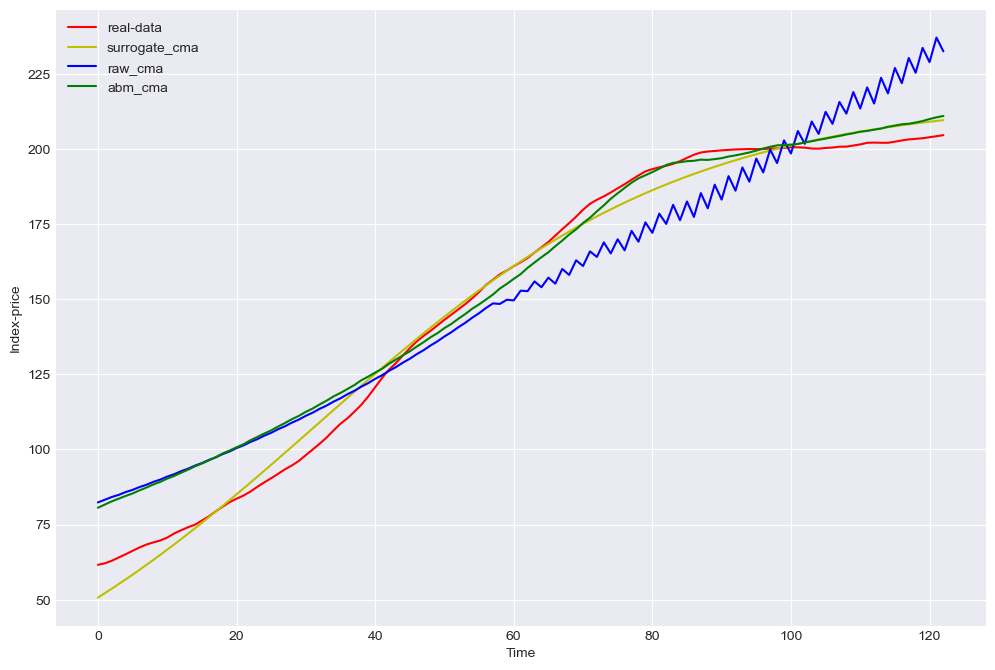

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=391343, Wed Apr 17 14:49:17 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=456203, Wed Apr 17 14:49:17 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.777633803047966e+01 1.0e+00 2.02e-02  2e-02  2e-02 0:00.0
    2     16 2.456100695157989e+01 1.3e+00 1.72e-02  1e-02  2e-02 0:00.0
    3     24 1.885546283380128e+01 1.4e+00 1.42e-02  1e-02  1e-02 0:00.0
  100    800 4.668289726993767e+00 1.5e+03 3.04e-03  2e-05  3e-03 0:00.8
  200   1600 4.668268327534321e+00 1.1e+05 1.24e-05  2e-09  1e-05 0:01.7
  300   2400 4.668268327544593e+00 6.8e+05 1.13e-06  7e-11  3e-07 0:02.6


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=313)
  warnings.warn(msg + ' (' +


  400   3200 4.668268327533896e+00 9.8e+00 1.53e-06  4e-07  8e-07 0:03.4
  500   4000 4.668268327533903e+00 1.2e+02 3.25e-06  7e-07  9e-07 0:04.3
  505   4040 4.668268327533881e+00 1.5e+02 2.76e-06  6e-07  8e-07 0:04.3
termination on tolstagnation=198 (Wed Apr 17 14:49:22 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4041/1944 evaluations
incumbent solution: [-1.4329712145888958, 0.03748920542072458, 0.03598362964586718, -0.19548402035999057]
std deviation: [7.856534686065195e-07, 7.383793367137714e-07, 6.33692902193743e-07, 5.881706438602649e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=481192, Wed Apr 17 14:49:22 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=426900, Wed Apr 17 14:49:22 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.788819281082932e+01 1.0e+00 1.84e-02  2e-02  2e-02 0:00.3
    2     18 1.472162124057495e+01 1.2e+00 1.83e-02  2e-02  2e-02 0:00.7
    3     27 3.600659086150943e

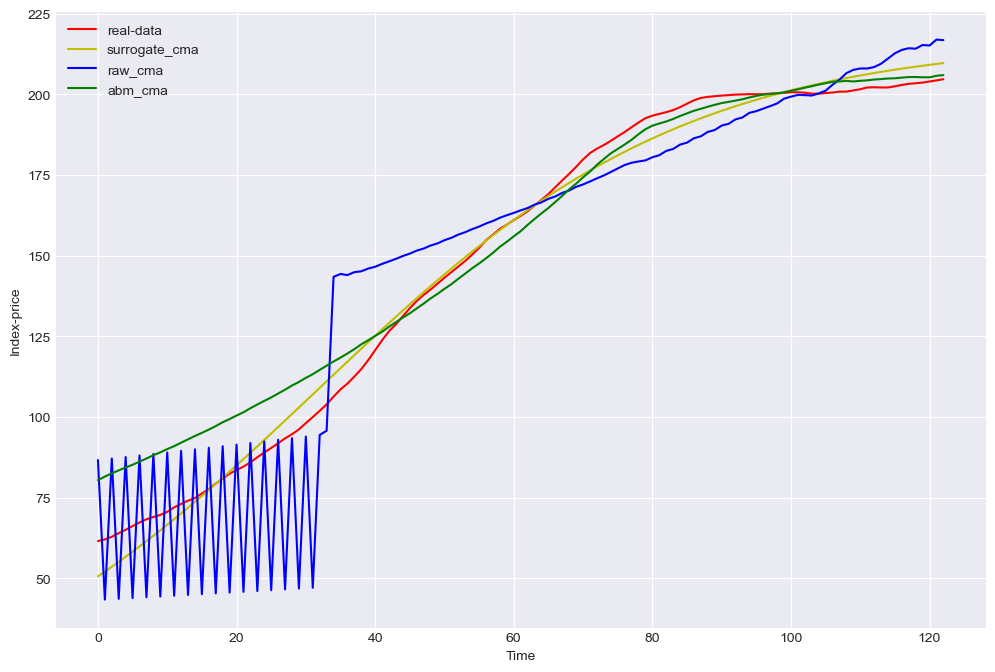

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=494260, Wed Apr 17 14:56:54 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=499073, Wed Apr 17 14:56:54 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.070301269983686e+01 1.0e+00 2.11e-02  2e-02  2e-02 0:00.0
    2     16 1.581667972353504e+01 1.2e+00 1.91e-02  2e-02  2e-02 0:00.0
    3     24 1.433976899929265e+01 1.3e+00 1.50e-02  1e-02  2e-02 0:00.0
  100    800 4.668304796294152e+00 2.0e+03 3.79e-03  3e-05  5e-03 0:00.8
NOTE (module=cma, iteration=199):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 7.4e+09 to 4.0e+04
  200   1600 4.668268327545630e+00 2.0e+02 2.49e-05  3e-09  3e-05 0:01.6
  300   2400 4.668268327533901e+00 4.4e+02 4.78e-06  1e-10  1e-06 0:02.4
  400   3200 4.668268327544573e+00 8.3e+03 4.91e-06  4e-11  9e-07 0:03.2
  500   4000 4.668268327533883e+00 1.4e+04 5.76e-06  2e-11  4e-07 0:04.0
  600   4800 4.

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=910)
  warnings.warn(msg + ' (' +


  920   8280 8.008232214387185e+00 1.8e+00 5.33e-03  5e-03  5e-03 8:57.4
termination on tolstagnation=256 (Wed Apr 17 15:06:01 2024)
final/bestever f-value = 8.390954e+00 7.491941e+00 after 8281/5301 evaluations
incumbent solution: [50.79290984898398, -0.012834259163810202, -0.11553006198664661, 204.12671521235825, 0.4183774893208465, 3.7644562693021726]
std deviation: [0.0046321338331259815, 0.0047639509176909175, 0.005414532212872562, 0.00489033546294354, 0.004668858071489579, 0.005334004058509916]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=488793, Wed Apr 17 15:06:01 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=426495, Wed Apr 17 15:06:01 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.532061264524329e+01 1.0e+00 1.83e-02  2e-02  2e-02 0:00.5
    2     18 2.629980043637516e+01 1.2e+00 1.64e-02  1e-02  2e-02 0:01.1
    3     27 3.225442430824135e+01 1.4e+00 1.75e-02  1e-02  2e-02 0:01.6
    9     81 2.70464630

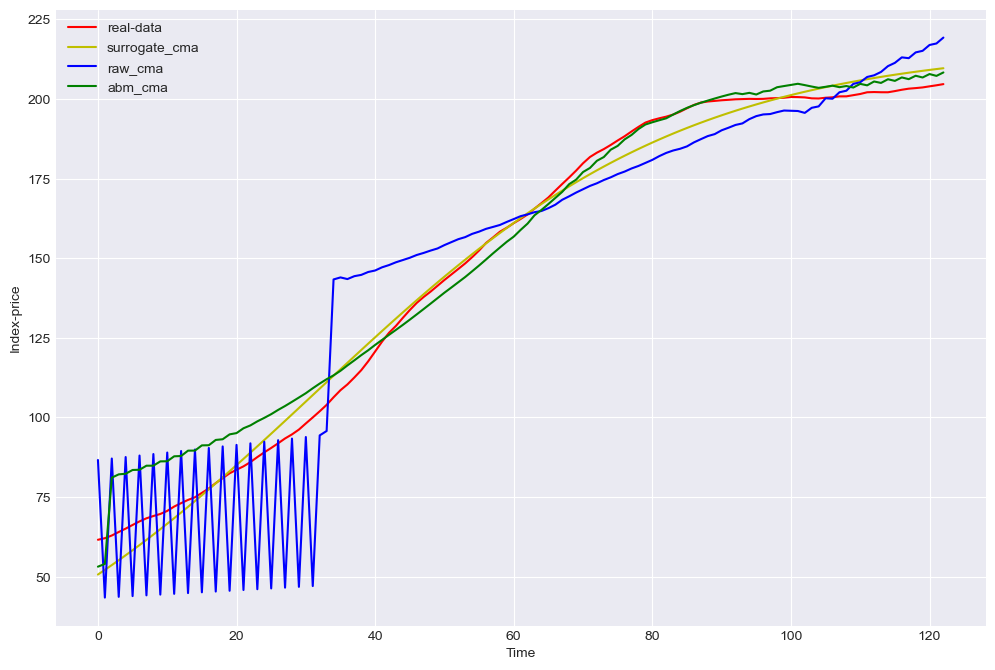

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=515442, Wed Apr 17 15:13:45 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=468566, Wed Apr 17 15:13:45 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.483241286160412e+01 1.0e+00 2.07e-02  2e-02  2e-02 0:00.0
    2     16 1.126405782732917e+01 1.3e+00 2.62e-02  2e-02  3e-02 0:00.0
    3     24 5.112172333879689e+01 1.3e+00 2.70e-02  2e-02  3e-02 0:00.0
  100    800 4.668269958345295e+00 3.8e+03 1.28e-03  8e-06  4e-03 0:01.0
  200   1600 4.668268327548294e+00 7.9e+04 3.12e-06  2e-09  5e-06 0:02.1
  300   2400 4.668268327546228e+00 5.2e+05 1.39e-05  2e-09  8e-06 0:03.2


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=313)
  warnings.warn(msg + ' (' +


  400   3200 4.668268327523240e+00 6.9e+00 1.38e-05  3e-06  9e-06 0:04.3
  500   4000 4.668268327533994e+00 6.7e+01 1.17e-05  8e-07  4e-06 0:05.6
  600   4800 4.668268327544640e+00 3.2e+02 1.02e-05  3e-07  2e-06 0:06.8
termination on tolstagnation=198 (Wed Apr 17 15:13:53 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4801/2507 evaluations
incumbent solution: [-1.4329712095303342, 0.037489205788417926, 0.03719463462630601, 0.5046779164650008]
std deviation: [2.984623913848004e-07, 1.6142810800996987e-06, 7.655024984588681e-07, 4.92846209037758e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=461297, Wed Apr 17 15:13:53 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=485233, Wed Apr 17 15:13:53 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.973551709328692e+01 1.0e+00 1.90e-02  2e-02  2e-02 0:00.4
    2     18 1.215393121487775e+01 1.2e+00 1.85e-02  2e-02  2e-02 0:00.8
    3     27 1.121404330317643e

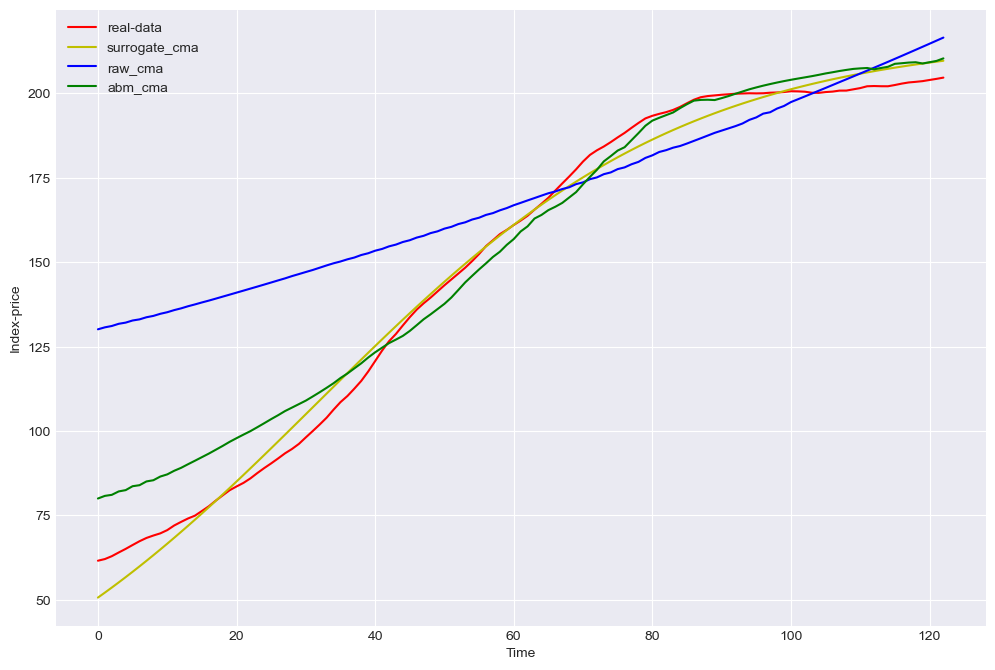

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=461165, Wed Apr 17 15:18:13 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=479099, Wed Apr 17 15:18:13 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.166440909107064e+01 1.0e+00 2.15e-02  2e-02  2e-02 0:00.0
    2     16 2.175559156001239e+01 1.4e+00 2.06e-02  2e-02  2e-02 0:00.0
    3     24 1.820156645752107e+01 1.5e+00 1.71e-02  2e-02  2e-02 0:00.0
  100    800 4.668360011544793e+00 1.4e+03 4.64e-03  6e-05  7e-03 0:01.0
  200   1600 4.668268327545425e+00 2.9e+04 7.07e-06  2e-09  4e-06 0:02.0
  300   2400 4.668268327544581e+00 2.6e+05 1.57e-06  2e-10  4e-07 0:03.0
  400   3200 4.668268327544567e+00 2.5e+00 9.16e-07  6e-07  1e-06 0:04.1


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=385)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327544576e+00 2.5e+01 9.86e-07  1e-07  7e-07 0:05.2
  600   4800 4.668268327523183e+00 1.8e+01 1.34e-06  6e-08  2e-07 0:06.4
  690   5520 4.668268327533867e+00 3.3e+01 6.63e-07  1e-08  3e-08 0:07.4
termination on tolstagnation=198 (Wed Apr 17 15:18:21 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 5521/3811 evaluations
incumbent solution: [-1.4329713083160036, 0.03748920617409622, 0.039303643695965465, 1.7240351637931504]
std deviation: [3.092416176581885e-08, 2.5761332838682603e-08, 1.3327314374566228e-08, 1.0347436277252416e-08]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=544022, Wed Apr 17 15:18:21 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=534772, Wed Apr 17 15:18:21 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.827575653804885e+01 1.0e+00 1.80e-02  2e-02  2e-02 0:00.5
    2     18 1.545457279042174e+01 1.2e+00 1.77e-02  2e-02  2e-02 0:00.9
    3     27 1.6931453368997

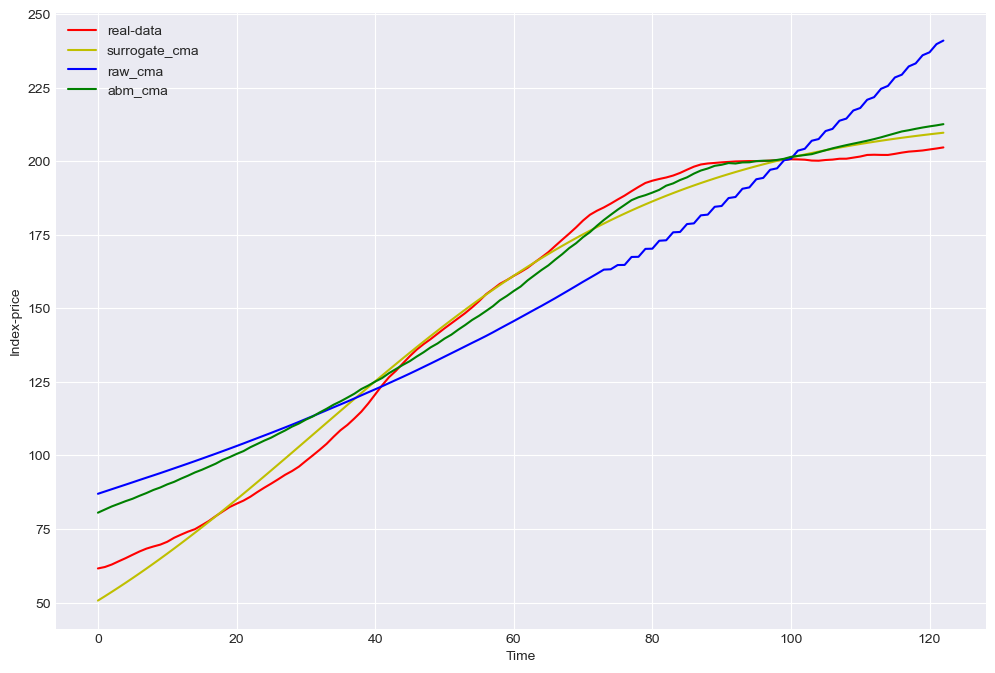

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=422764, Wed Apr 17 15:22:01 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=434347, Wed Apr 17 15:22:01 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.035007921218711e+01 1.0e+00 1.85e-02  2e-02  2e-02 0:00.0
    2     16 1.659258155569644e+01 1.3e+00 1.69e-02  1e-02  2e-02 0:00.0
    3     24 1.780850627880970e+01 1.5e+00 1.55e-02  1e-02  2e-02 0:00.0
  100    800 4.668281250057909e+00 2.5e+03 2.97e-03  2e-05  5e-03 0:01.1
NOTE (module=cma, iteration=151):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 9.3e+09 to 5.5e+04
  200   1600 4.668268327560210e+00 1.2e+03 3.15e-05  5e-09  2e-04 0:02.2
  300   2400 4.668268327546508e+00 6.0e+03 2.52e-05  1e-09  4e-05 0:03.3
  400   3200 4.668268327546778e+00 5.0e+04 5.41e-06  9e-11  4e-06 0:04.3
  500   4000 4.668268327557328e+00 1.6e+05 7.49e-06  1e-11  2e-06 0:05.4
  600   4800 4.

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=617)
  warnings.warn(msg + ' (' +


  700   5600 4.668268327546600e+00 8.6e+00 2.36e-06  3e-07  1e-06 0:07.6
  710   5680 4.668268327557302e+00 1.0e+01 3.04e-06  4e-07  1e-06 0:07.7
termination on tolstagnation=198 (Wed Apr 17 15:22:10 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 5681/2652 evaluations
incumbent solution: [-1.4329713767619978, 0.03748920806868661, 0.036095779980769294, -0.13064504927024245]
std deviation: [1.466350416278034e-06, 1.235838351266052e-06, 7.322551995998419e-07, 4.2264129923984784e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=461786, Wed Apr 17 15:22:10 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=515545, Wed Apr 17 15:22:10 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.086443330551120e+01 1.0e+00 2.15e-02  2e-02  2e-02 0:00.4
    2     18 1.028617116337615e+01 1.4e+00 2.13e-02  2e-02  2e-02 0:00.8
    3     27 1.143834214496052e+01 1.5e+00 2.08e-02  2e-02  2e-02 0:01.1
   14    126 1.4286252947885

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=658)
  warnings.warn(msg + ' (' +


  695   6255 1.832848387594402e+01 3.3e+00 1.66e-03  1e-03  2e-03 7:05.9
  700   6300 1.796895229450818e+01 4.0e+00 1.53e-03  8e-04  2e-03 7:09.1
  752   6768 1.816464741087952e+01 9.7e+00 7.50e-04  3e-04  7e-04 7:42.3
  800   7200 1.787919632705543e+01 1.3e+01 6.21e-04  1e-04  3e-04 8:12.9
  805   7245 1.801467857824435e+01 1.6e+01 7.75e-04  2e-04  4e-04 8:16.2
termination on tolstagnation=256 (Wed Apr 17 15:34:06 2024)
final/bestever f-value = 1.945289e+01 1.759139e+01 after 7246/4476 evaluations
incumbent solution: [1.3280000275226485, 0.0055454434790791485, -0.2256411135498979, -0.4814026578906123, 0.7225156654742477, 3.6423170634670896]
std deviation: [0.0004367718341121791, 0.00017260151422574622, 0.0002818994444503241, 0.00025903341017984754, 0.0004299856511353534, 0.00021003668297361083]
Raw: 17.591385104741825 | MAS: 9.756159113409424


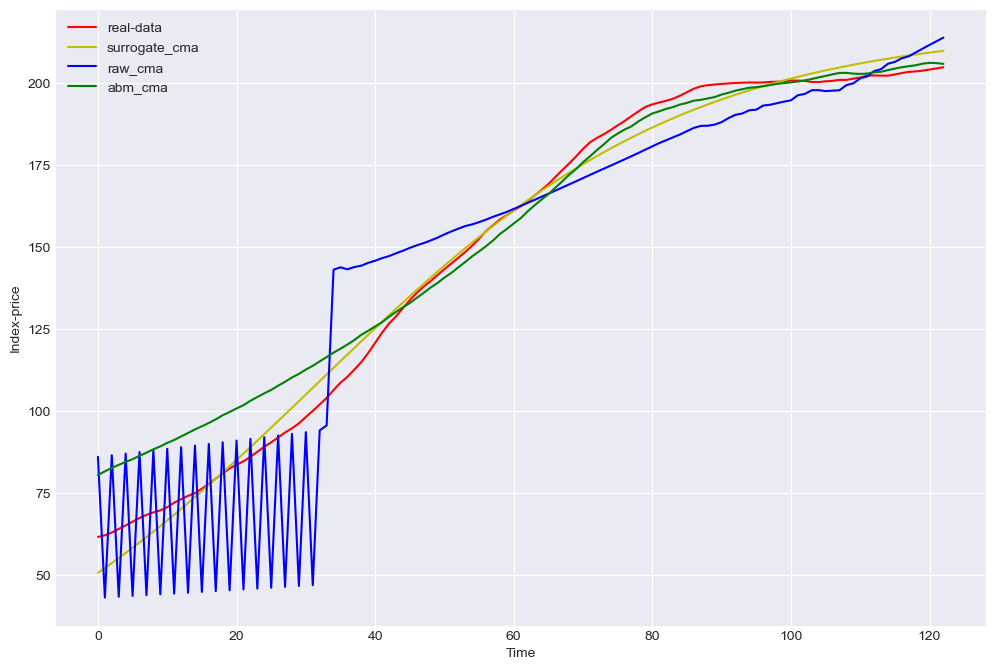

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=527901, Wed Apr 17 15:34:06 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=482642, Wed Apr 17 15:34:06 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.162679113000551e+01 1.0e+00 1.83e-02  2e-02  2e-02 0:00.0
    2     16 2.269950305796318e+01 1.4e+00 1.80e-02  2e-02  2e-02 0:00.0
    3     24 2.402216048974055e+01 1.4e+00 1.92e-02  2e-02  2e-02 0:00.0
  100    800 4.668278184344399e+00 1.6e+03 3.61e-03  2e-05  4e-03 0:01.0
  200   1600 4.668268327544678e+00 5.3e+04 2.77e-06  5e-10  1e-06 0:01.9
  300   2400 4.668268327534106e+00 1.4e+05 2.05e-06  7e-11  3e-07 0:02.8
  400   3200 4.668268327523392e+00 2.3e+00 1.18e-06  9e-07  1e-06 0:03.9


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=382)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327544820e+00 1.7e+01 2.08e-05  5e-06  2e-05 0:04.8
  505   4040 4.668268327544809e+00 2.0e+01 2.14e-05  4e-06  1e-05 0:04.9
termination on tolstagnation=198 (Wed Apr 17 15:34:12 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4041/2836 evaluations
incumbent solution: [-1.4329714629644306, 0.037489206646540596, 0.033895537771615025, -1.4027488617151693]
std deviation: [1.4261753621876085e-05, 1.4255793937485887e-05, 4.393415183545344e-06, 7.685120216524506e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=460234, Wed Apr 17 15:34:12 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=453848, Wed Apr 17 15:34:12 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.498415499972575e+01 1.0e+00 2.09e-02  2e-02  2e-02 0:00.3
    2     18 1.371139625802115e+01 1.4e+00 2.02e-02  2e-02  2e-02 0:00.6
    3     27 1.515862722156687e+01 1.5e+00 1.96e-02  2e-02  2e-02 0:00.9
   17    153 1.227403819603

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=733)
  warnings.warn(msg + ' (' +


  800   7200 3.388947410433662e+01 1.6e+01 1.73e-04  1e-04  4e-04 1:45.9
  806   7254 3.388474226961183e+01 1.7e+01 1.41e-04  1e-04  3e-04 1:46.6
termination on tolstagnation=256 (Wed Apr 17 15:38:18 2024)
final/bestever f-value = 3.389326e+01 3.387283e+01 after 7255/6095 evaluations
incumbent solution: [0.6026312551664432, 0.1890166325550524, 0.0052220990163078795, 0.46045146388996727, 0.22386924087550142, 3.000379834969408]
std deviation: [0.0002840668334657123, 0.00019336459185991355, 0.00024230201920054758, 0.00011573910136143289, 0.00017668198002690578, 0.0001399449525510181]
Raw: 33.872833200238134 | MAS: 9.974218925400196


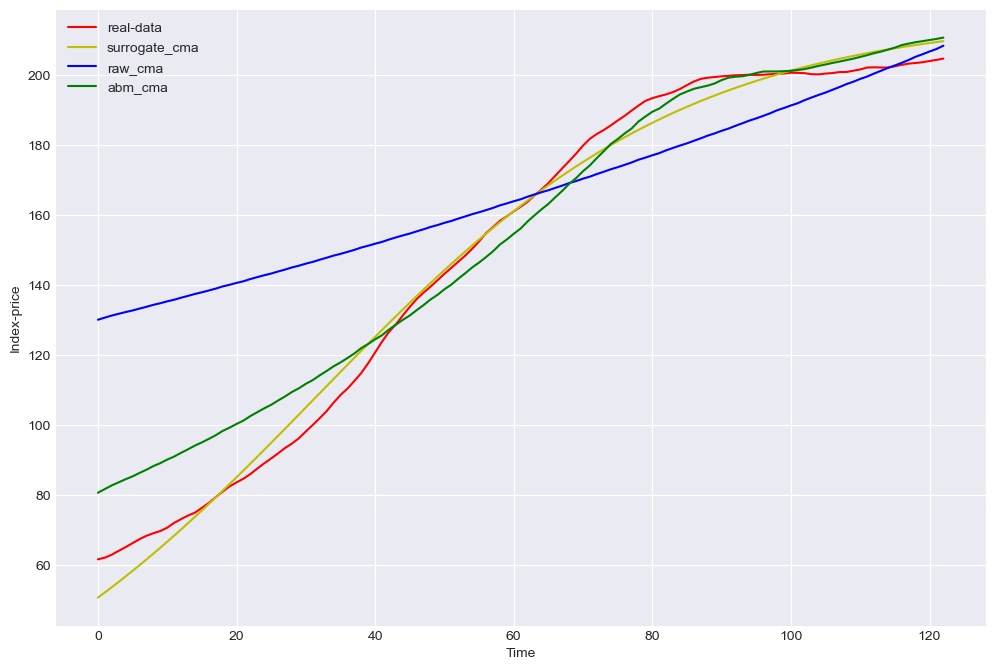

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=482488, Wed Apr 17 15:38:18 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=475477, Wed Apr 17 15:38:18 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.117891059362008e+01 1.0e+00 1.85e-02  2e-02  2e-02 0:00.0
    2     16 2.886429341653411e+01 1.2e+00 1.63e-02  1e-02  2e-02 0:00.0
    3     24 9.786337883572759e+00 1.3e+00 1.44e-02  1e-02  2e-02 0:00.0
  100    800 4.668269706730703e+00 1.5e+03 9.68e-04  6e-06  1e-03 0:00.9
  200   1600 4.668268327534736e+00 8.6e+04 5.22e-06  8e-10  4e-06 0:01.8


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=263)
  warnings.warn(msg + ' (' +


  300   2400 4.668268327534108e+00 4.0e+00 1.42e-05  6e-06  2e-05 0:02.8
  400   3200 4.668268327533935e+00 1.6e+01 6.13e-05  3e-06  2e-05 0:03.7
  500   4000 4.668268327523170e+00 1.2e+02 2.42e-05  1e-06  6e-06 0:04.7
  600   4800 4.668268327533920e+00 5.8e+01 1.99e-05  1e-07  8e-07 0:05.7
  665   5320 4.668268327533902e+00 1.2e+02 1.74e-05  4e-08  4e-07 0:06.3
termination on tolstagnation=198 (Wed Apr 17 15:38:25 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 5321/4511 evaluations
incumbent solution: [-1.4329713019006318, 0.03748920664740435, 0.03698592144040197, 0.3840063202698918]
std deviation: [4.4872046212867176e-08, 4.0798261771549444e-07, 2.8604219160603184e-07, 8.290092850003992e-08]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=501652, Wed Apr 17 15:38:25 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=538890, Wed Apr 17 15:38:25 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.14870267832412

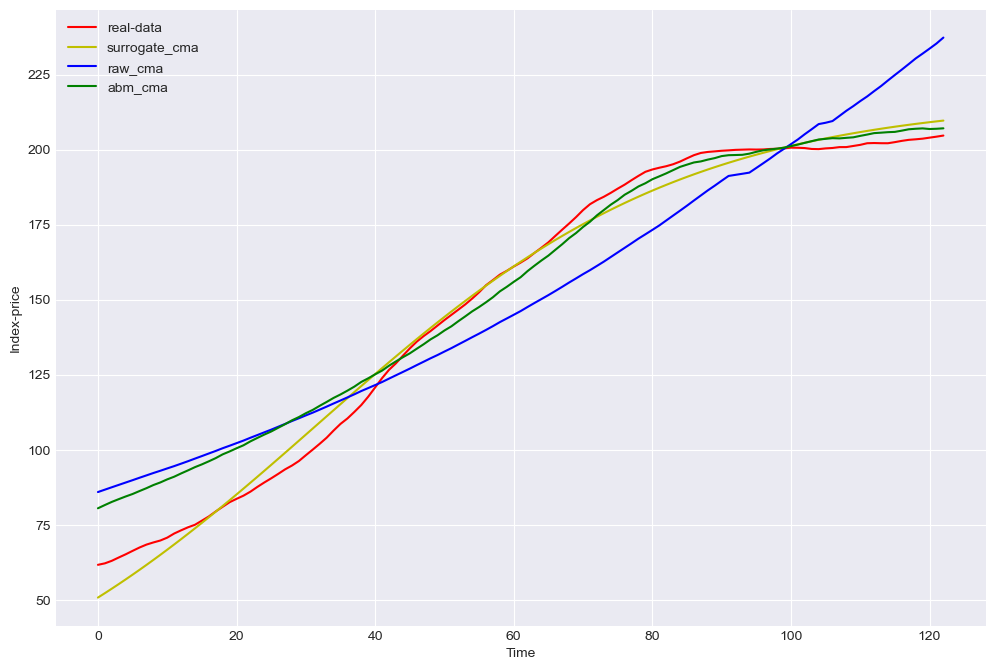

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=477324, Wed Apr 17 15:46:33 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=473121, Wed Apr 17 15:46:33 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 5.994140284883553e+01 1.0e+00 1.61e-02  2e-02  2e-02 0:00.0
    2     16 2.479941865399411e+01 1.2e+00 1.75e-02  2e-02  2e-02 0:00.0
    3     24 2.433916076289055e+01 1.4e+00 1.77e-02  1e-02  2e-02 0:00.0
  100    800 4.668676487116364e+00 2.8e+03 1.97e-02  2e-04  3e-02 0:01.2
  200   1600 4.668268327535754e+00 3.6e+04 1.48e-05  2e-09  8e-06 0:02.7
  300   2400 4.668268327545586e+00 9.5e+04 7.56e-06  4e-10  2e-06 0:03.8
  400   3200 4.668268327545652e+00 2.4e+05 5.71e-05  1e-09  6e-06 0:04.9
  500   4000 4.668268327545040e+00 3.2e+05 1.01e-05  2e-11  1e-07 0:06.0
  505   4040 4.668268327523639e+00 3.0e+05 5.90e-06  1e-11  7e-08 0:06.1
termination on tolstagnation=198 (Wed Apr 17 15:46:40 2024)
final/bestever f-value = 4.6682

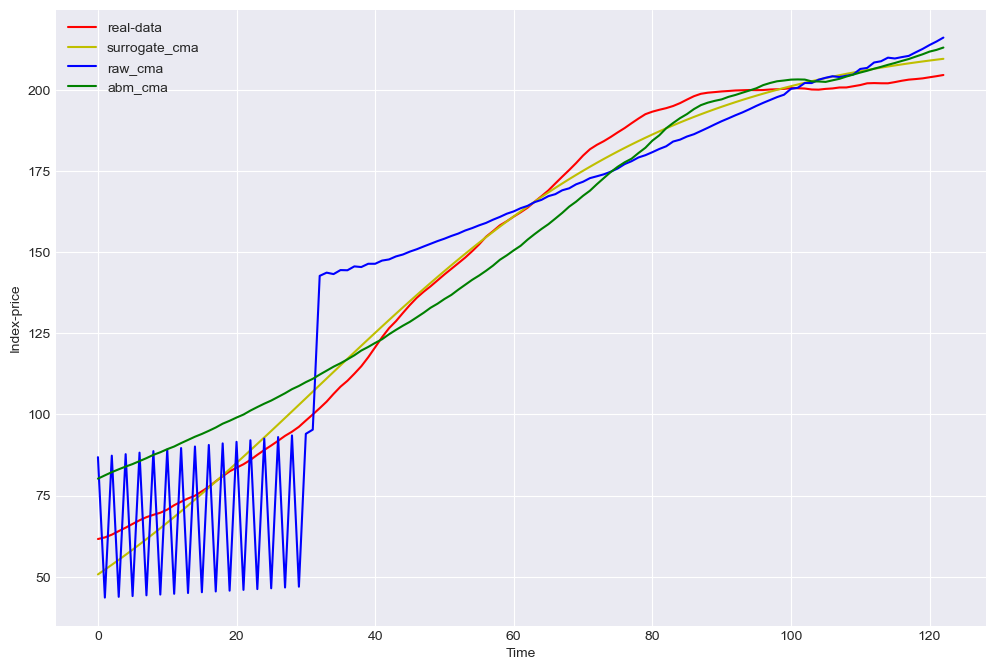

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=546672, Wed Apr 17 16:04:33 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=541538, Wed Apr 17 16:04:33 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 9.143234983301941e+00 1.0e+00 2.57e-02  2e-02  3e-02 0:00.0
    2     16 2.293080751903553e+01 1.4e+00 2.30e-02  2e-02  3e-02 0:00.0
    3     24 1.217468293858675e+01 1.6e+00 2.21e-02  2e-02  3e-02 0:00.0
  100    800 4.668364636741088e+00 2.8e+03 1.38e-02  1e-04  5e-02 0:01.3
NOTE (module=cma, iteration=159):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 8.8e+09 to 5.4e+04
  200   1600 4.668268327544570e+00 7.7e+02 4.40e-06  4e-10  3e-05 0:02.7
  300   2400 4.668268327523200e+00 1.7e+03 1.08e-06  2e-11  2e-06 0:04.2
  400   3200 4.668268327523199e+00 2.4e+04 7.37e-07  9e-12  7e-07 0:05.6
  500   4000 4.668268327533893e+00 3.1e+05 1.36e-06  1e-11  8e-07 0:06.9
  575   4600 4.

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=566)
  warnings.warn(msg + ' (' +


termination on tolstagnation=198 (Wed Apr 17 16:04:43 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 4601/3472 evaluations
incumbent solution: [-1.4329711942241374, 0.03748920531250377, 0.03734603758130106, 0.5922141701448709]
std deviation: [3.2834153499600676e-05, 2.862853478993428e-05, 2.7895159224324653e-05, 3.789008634844501e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=514865, Wed Apr 17 16:04:43 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=509193, Wed Apr 17 16:04:43 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.435797615748995e+01 1.0e+00 1.77e-02  2e-02  2e-02 0:00.5
    2     18 1.184474888843505e+01 1.2e+00 1.68e-02  1e-02  2e-02 0:01.1
    3     27 1.331822329708679e+01 1.3e+00 1.61e-02  2e-02  2e-02 0:01.5
   13    117 1.137876773952744e+01 2.1e+00 1.30e-02  1e-02  1e-02 0:04.8
   24    216 1.430516554413864e+01 2.8e+00 1.96e-02  1e-02  2e-02 0:08.9
   38    342 1.083195163905661

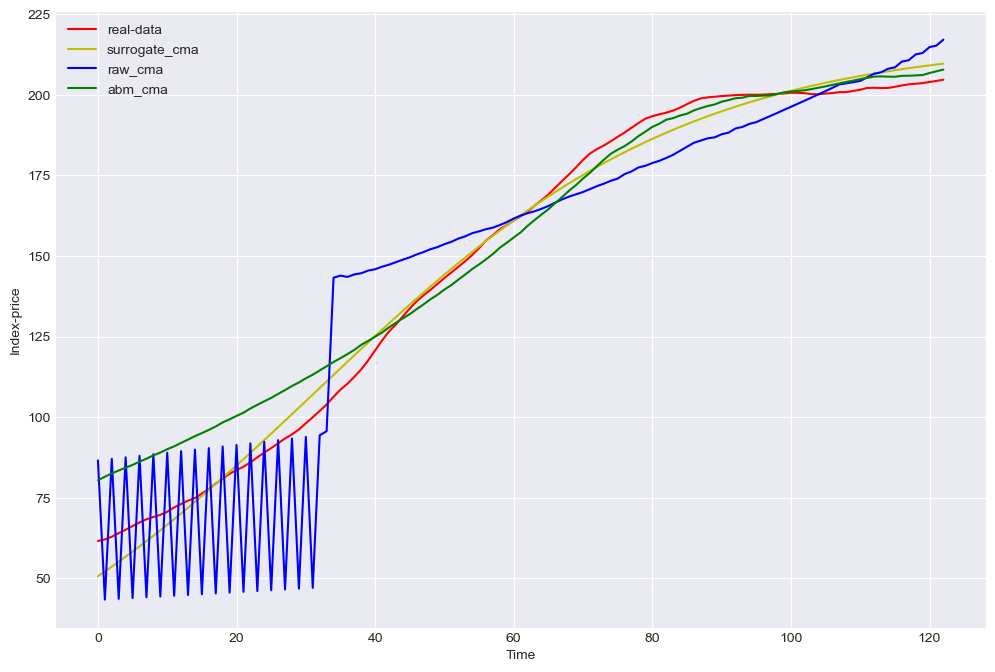

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=504281, Wed Apr 17 16:14:59 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=470348, Wed Apr 17 16:14:59 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.376636829186399e+01 1.0e+00 2.00e-02  2e-02  2e-02 0:00.0
    2     16 1.634695451533336e+01 1.4e+00 1.86e-02  2e-02  2e-02 0:00.0
    3     24 1.673834204397549e+01 1.4e+00 1.89e-02  1e-02  2e-02 0:00.0
  100    800 4.668281264871756e+00 1.0e+03 1.64e-03  1e-05  1e-03 0:00.9
  200   1600 4.668268327544684e+00 5.3e+04 3.95e-06  7e-10  2e-06 0:01.8
NOTE (module=cma, iteration=296):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 3.3e+11 to 2.1e+06
  300   2400 4.668268327544631e+00 2.4e+03 2.71e-06  2e-10  1e-06 0:02.7
  400   3200 4.668268327533933e+00 1.4e+04 1.19e-06  5e-11  4e-07 0:03.7
  500   4000 4.668268327555318e+00 1.9e+04 1.28e-06  1e-11  1e-07 0:04.7
  510   4080 4.

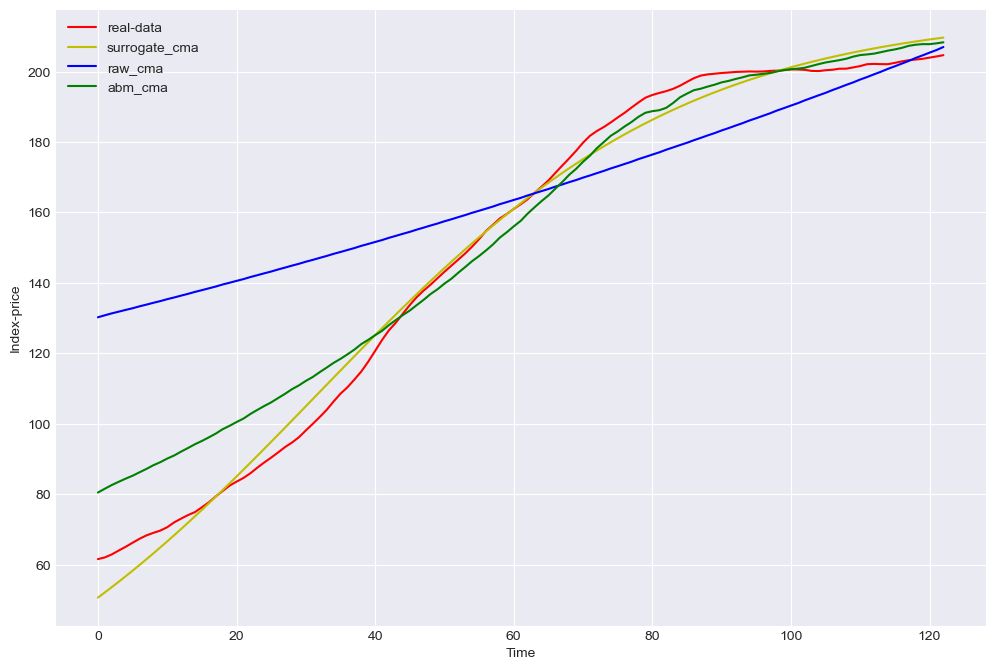

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=455263, Wed Apr 17 16:18:52 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=435628, Wed Apr 17 16:18:52 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.662431498485435e+01 1.0e+00 1.82e-02  2e-02  2e-02 0:00.0
    2     16 3.281328022409907e+01 1.2e+00 1.48e-02  1e-02  1e-02 0:00.0
    3     24 2.030017523254729e+01 1.3e+00 1.50e-02  1e-02  1e-02 0:00.0
  100    800 4.668273010603522e+00 3.3e+03 2.92e-03  2e-05  6e-03 0:01.1
NOTE (module=cma, iteration=147):  
condition in coordinate system exceeded 1.3e+08, rescaled to 1.0e+00, 
condition changed from 7.0e+09 to 2.8e+04
  200   1600 4.668268327547224e+00 7.7e+02 3.36e-05  4e-09  1e-04 0:02.3
  300   2400 4.668268327525325e+00 5.8e+03 7.78e-06  2e-10  1e-05 0:03.4
  400   3200 4.668268327545124e+00 1.6e+04 6.93e-05  9e-10  3e-05 0:04.5
  500   4000 4.668268327544609e+00 4.4e+04 4.20e-05  7e-11  4e-06 0:05.6
  570   4560 4.

/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=815)
  warnings.warn(msg + ' (' +


  849   7641 3.170246764495102e+01 4.3e+00 6.31e-04  4e-04  8e-04 7:21.4
  899   8091 3.161396797786846e+01 1.4e+01 4.51e-04  2e-04  5e-04 7:54.5
  900   8100 3.156195230872794e+01 1.4e+01 4.44e-04  2e-04  5e-04 7:55.0
  910   8190 3.165877879098920e+01 1.1e+01 2.93e-04  1e-04  3e-04 8:01.6
termination on tolstagnation=256 (Wed Apr 17 16:29:32 2024)
final/bestever f-value = 1.333743e+02 3.141947e+01 after 8191/1454 evaluations
incumbent solution: [5.0961117123237045, -0.3988041693584137, -0.004966233269852516, 3.2826390054927685, -3.9091580969631536, 5.673967949209725]
std deviation: [0.00026272456669400903, 0.00021896283416872388, 0.00014149060218536071, 0.00013111750476357614, 0.00010917988870949367, 0.00022259951611314913]
Raw: 31.419465719711834 | MAS: 10.099725697654439


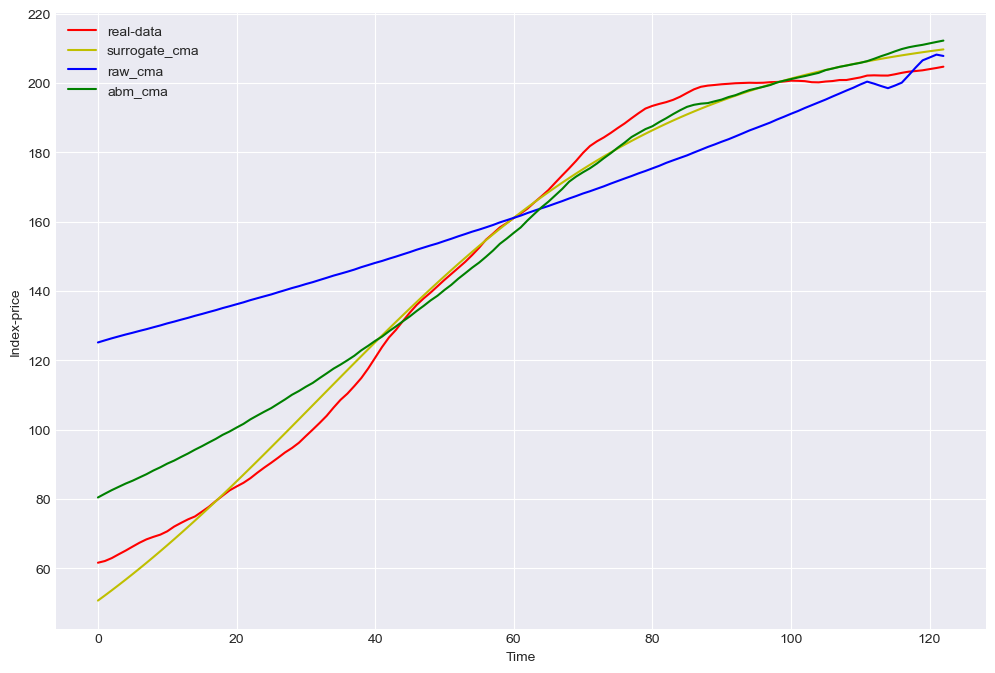

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=459757, Wed Apr 17 16:29:33 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=441379, Wed Apr 17 16:29:33 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 6.534569626440147e+01 1.0e+00 2.04e-02  2e-02  2e-02 0:00.0
    2     16 2.570487213807910e+01 1.4e+00 1.77e-02  2e-02  2e-02 0:00.0
    3     24 2.093070992922748e+01 1.6e+00 1.53e-02  1e-02  2e-02 0:00.0
  100    800 4.668814914582979e+00 2.5e+03 1.47e-02  1e-04  3e-02 0:00.9
NOTE (module=cma, iteration=165):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.3e+10 to 5.6e+04
  200   1600 4.668268327534666e+00 6.8e+02 1.18e-05  2e-09  2e-05 0:01.8
  300   2400 4.668268327544673e+00 1.1e+03 7.64e-06  2e-10  3e-06 0:02.8
  400   3200 4.668268327533904e+00 4.7e+03 3.24e-06  2e-11  5e-07 0:03.7
  500   4000 4.668268327544602e+00 4.1e+04 9.47e-06  4e-11  1e-06 0:04.7
  581   4648 4.

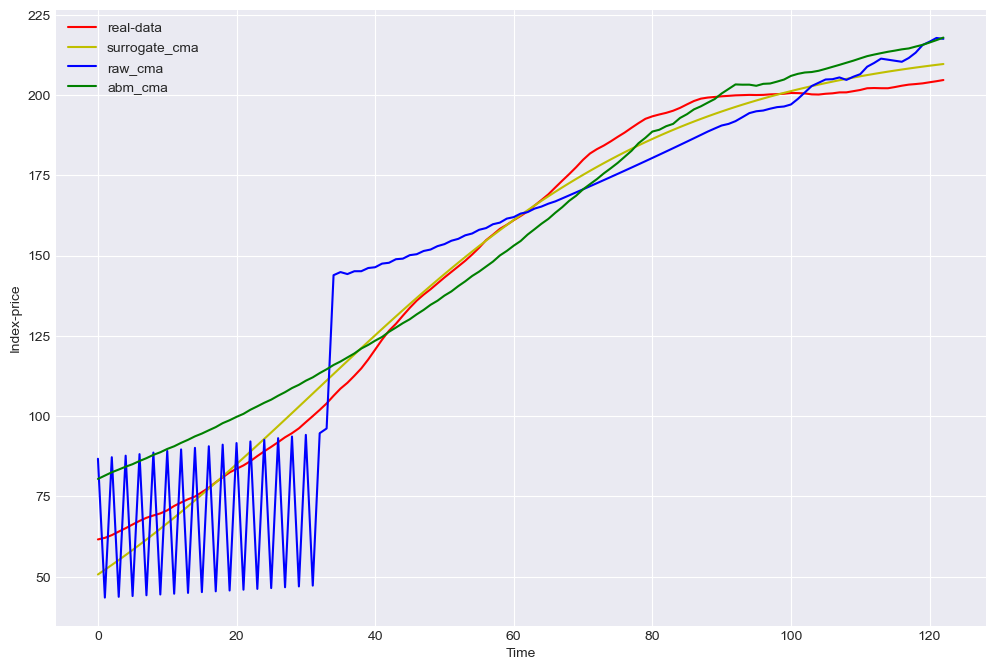

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=401888, Wed Apr 17 16:38:06 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=441799, Wed Apr 17 16:38:06 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.814391606834657e+01 1.0e+00 2.09e-02  2e-02  2e-02 0:00.0
    2     16 2.432294247667693e+01 1.3e+00 1.92e-02  2e-02  2e-02 0:00.0
    3     24 2.162563330877360e+01 1.3e+00 1.78e-02  2e-02  2e-02 0:00.0
  100    800 4.668343383792881e+00 2.2e+03 4.64e-03  4e-05  7e-03 0:00.8
  200   1600 4.668268327535421e+00 1.3e+05 1.30e-05  2e-09  1e-05 0:01.7
  300   2400 4.668268327544597e+00 9.5e+05 8.69e-07  4e-11  2e-07 0:02.7


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=303)
  warnings.warn(msg + ' (' +


  400   3200 4.668268327544579e+00 5.4e+01 4.11e-06  7e-07  4e-06 0:03.6
  500   4000 4.668268327544579e+00 1.0e+03 1.69e-06  9e-08  1e-06 0:04.6
  600   4800 4.668268327544577e+00 3.2e+03 7.82e-07  2e-08  2e-07 0:05.5
  649   5192 4.668268327533880e+00 1.4e+04 6.61e-07  1e-08  2e-07 0:06.0
termination on tolstagnation=198 (Wed Apr 17 16:38:13 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 5193/4399 evaluations
incumbent solution: [-1.4329712735482065, 0.03748920605843534, 0.033348214998199344, -1.7191918450912773]
std deviation: [2.0533751787604865e-07, 1.4475142949780096e-08, 6.131501649717301e-08, 3.98352501572588e-08]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=489067, Wed Apr 17 16:38:13 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=432525, Wed Apr 17 16:38:13 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.892996586323686e+01 1.0e+00 1.82e-02  2e-02  2e-02 0:00.4
    2     18 1.27415634067220

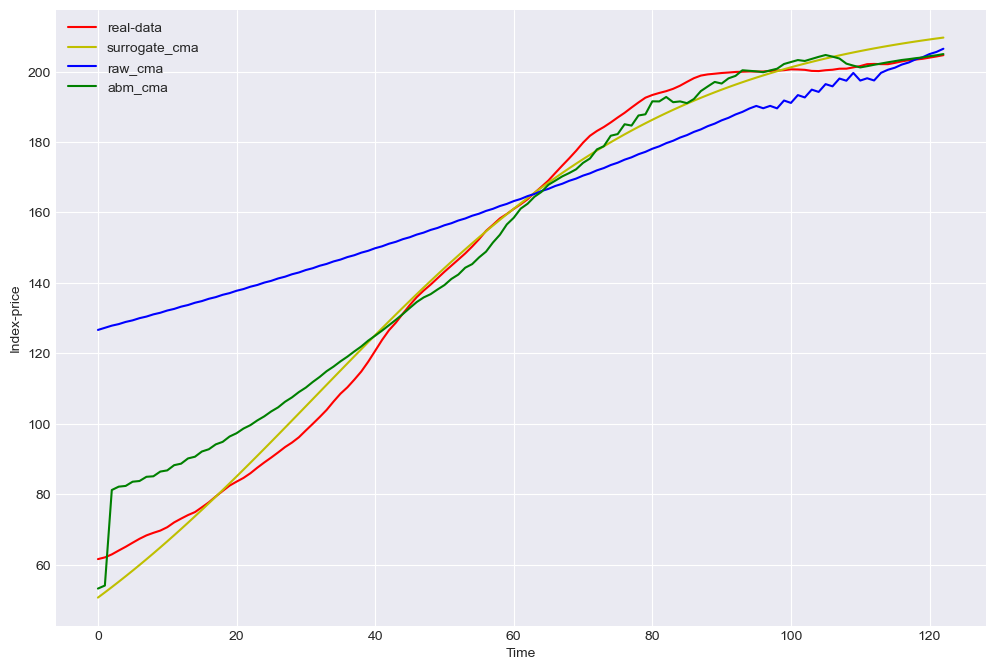

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=466252, Wed Apr 17 17:20:09 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=512515, Wed Apr 17 17:20:09 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.123082842195756e+01 1.0e+00 1.92e-02  2e-02  2e-02 0:00.0
    2     16 1.409147852295154e+01 1.2e+00 1.76e-02  1e-02  2e-02 0:00.0
    3     24 1.625409184214534e+01 1.5e+00 1.61e-02  1e-02  2e-02 0:00.0
  100    800 4.668268366819283e+00 1.7e+03 2.48e-04  2e-06  2e-04 0:00.8
  200   1600 4.668268327534126e+00 4.7e+03 2.91e-06  9e-10  3e-07 0:01.6
  300   2400 4.668268327534002e+00 1.4e+04 6.32e-07  6e-11  3e-08 0:02.4
  400   3200 4.668268327533901e+00 9.1e+03 1.01e-06  2e-11  7e-09 0:03.2
  500   4000 4.668268327555322e+00 4.6e+04 7.98e-06  3e-10  5e-08 0:04.0
  600   4800 4.668268327544605e+00 4.6e+05 5.98e-06  1e-10  2e-08 0:04.9


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=629)
  warnings.warn(msg + ' (' +


  700   5600 4.668268327523216e+00 1.8e+01 2.73e-07  9e-08  2e-07 0:05.7
  800   6400 4.668268327533897e+00 8.6e+01 7.95e-07  1e-07  2e-07 0:06.5
  885   7080 4.668268327544620e+00 2.2e+02 6.34e-06  2e-07  1e-06 0:07.2
termination on tolstagnation=198 (Wed Apr 17 17:20:17 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 7081/5038 evaluations
incumbent solution: [-1.4329713368339014, 0.03748920648548526, 0.03535747122447863, -0.5575081867489455]
std deviation: [2.2748432606439975e-07, 1.1906266649181535e-06, 8.860518131758231e-07, 1.0910276962386133e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=570179, Wed Apr 17 17:20:17 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=543878, Wed Apr 17 17:20:17 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 9.823814945105553e+00 1.0e+00 1.71e-02  2e-02  2e-02 0:00.3
    2     18 1.765594991430968e+01 1.2e+00 1.75e-02  2e-02  2e-02 0:00.7
    3     27 1.1832380393763

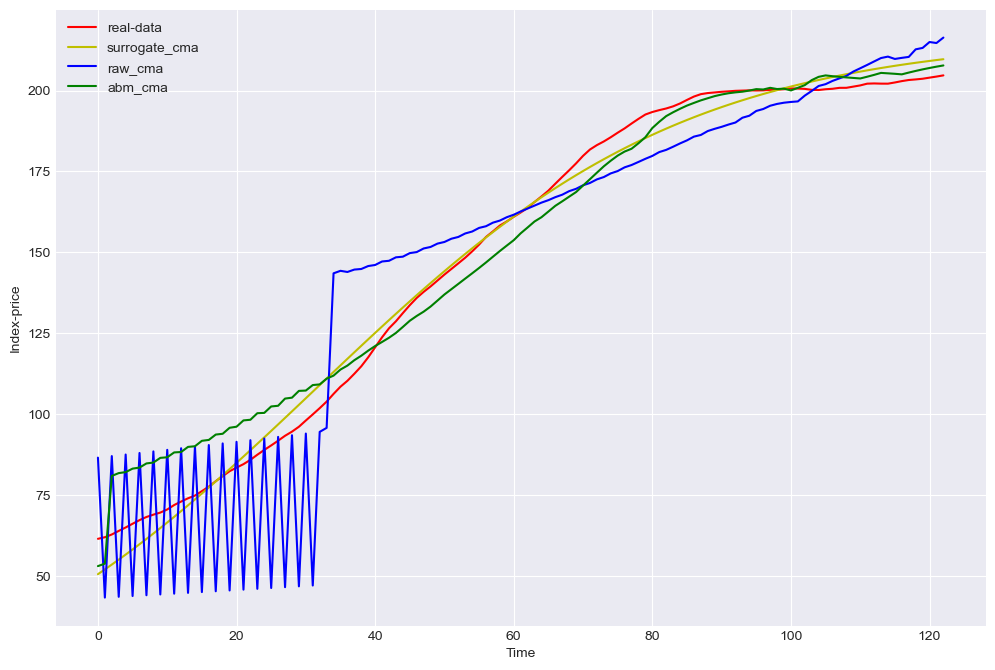

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=445394, Wed Apr 17 17:28:32 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=492025, Wed Apr 17 17:28:32 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.411728580064226e+01 1.0e+00 1.89e-02  2e-02  2e-02 0:00.0
    2     16 3.194734519485130e+01 1.2e+00 1.49e-02  1e-02  1e-02 0:00.0
    3     24 1.102744768351959e+01 1.3e+00 1.37e-02  1e-02  1e-02 0:00.0
  100    800 4.668325455950954e+00 5.3e+03 7.18e-03  4e-05  2e-02 0:00.8
NOTE (module=cma, iteration=154):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 2.0e+10 to 9.0e+04
  200   1600 4.668268327535980e+00 9.3e+02 2.20e-06  4e-10  5e-06 0:01.6
  300   2400 4.668268327556760e+00 4.7e+03 1.12e-05  8e-10  2e-05 0:02.4
  400   3200 4.668268327524212e+00 3.2e+04 1.53e-05  4e-10  1e-05 0:03.2
  500   4000 4.668268327534856e+00 5.3e+05 2.42e-06  4e-11  7e-07 0:04.1


/Users/priscillaavegliano/opt/anaconda3/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=538)
  warnings.warn(msg + ' (' +


  600   4800 4.668268327545560e+00 1.5e+01 4.98e-06  2e-06  7e-06 0:05.0
  700   5600 4.668268327545539e+00 3.5e+02 1.63e-05  6e-06  2e-05 0:05.9
  781   6248 4.668268327545548e+00 5.2e+02 1.12e-05  1e-06  6e-06 0:06.7
termination on tolstagnation=198 (Wed Apr 17 17:28:40 2024)
final/bestever f-value = 4.668268e+00 4.668268e+00 after 6249/5448 evaluations
incumbent solution: [-1.4329712062990438, 0.03748920550061996, 0.03812720113819523, 1.0438558892346919]
std deviation: [1.093507304077322e-06, 1.6205350596443735e-06, 5.617709119806204e-06, 1.7302165012351501e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=455469, Wed Apr 17 17:28:40 2024)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=487846, Wed Apr 17 17:28:40 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.191454308967405e+01 1.0e+00 1.94e-02  2e-02  2e-02 0:00.3
    2     18 1.286106837121118e+01 1.2e+00 2.07e-02  2e-02  2e-02 0:00.6
    3     27 1.427887187350064

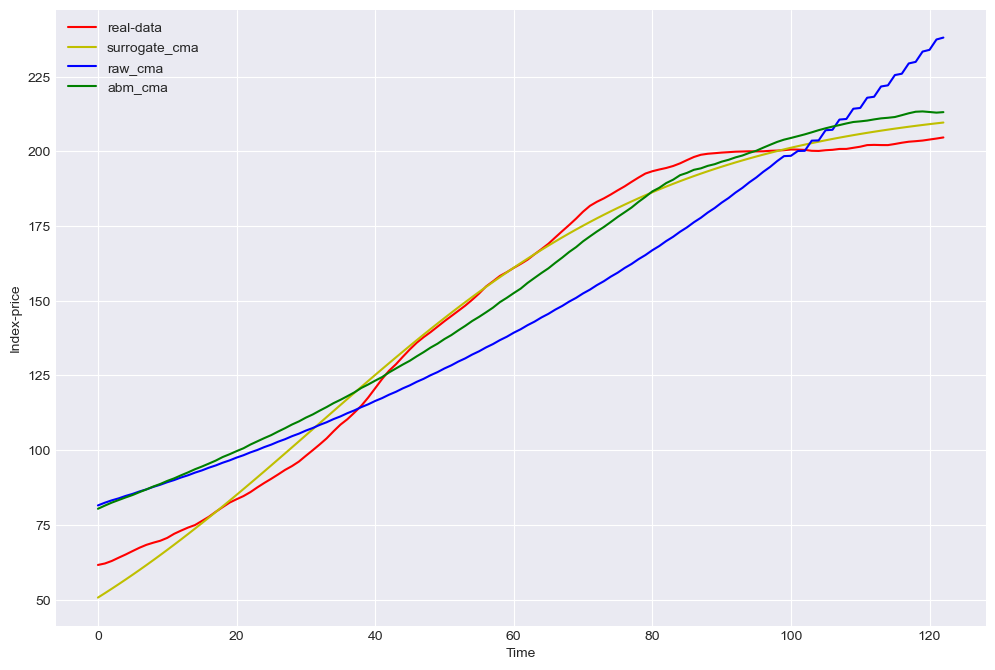

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=502251, Wed Apr 17 17:32:39 2024)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=472099, Wed Apr 17 17:32:39 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 5.466564852237251e+01 1.0e+00 1.84e-02  2e-02  2e-02 0:00.0
    2     16 1.977305860984276e+01 1.2e+00 1.60e-02  1e-02  2e-02 0:00.0
    3     24 2.991021089733650e+01 1.3e+00 1.68e-02  1e-02  2e-02 0:00.0
  100    800 4.668344503750084e+00 1.2e+03 5.35e-03  5e-05  6e-03 0:01.0
NOTE (module=cma, iteration=157):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 9.1e+09 to 4.7e+04
  200   1600 4.668268327534307e+00 4.9e+02 1.04e-05  1e-09  2e-05 0:02.0
  300   2400 4.668268327545839e+00 5.3e+03 2.44e-06  1e-10  3e-06 0:03.1
  400   3200 4.668268327534607e+00 1.3e+04 1.54e-05  1e-10  6e-06 0:04.2
  500   4000 4.668268327534599e+00 3.3e+04 1.02e-04  7e-10  2e-05 0:05.3
  585   4680 4.

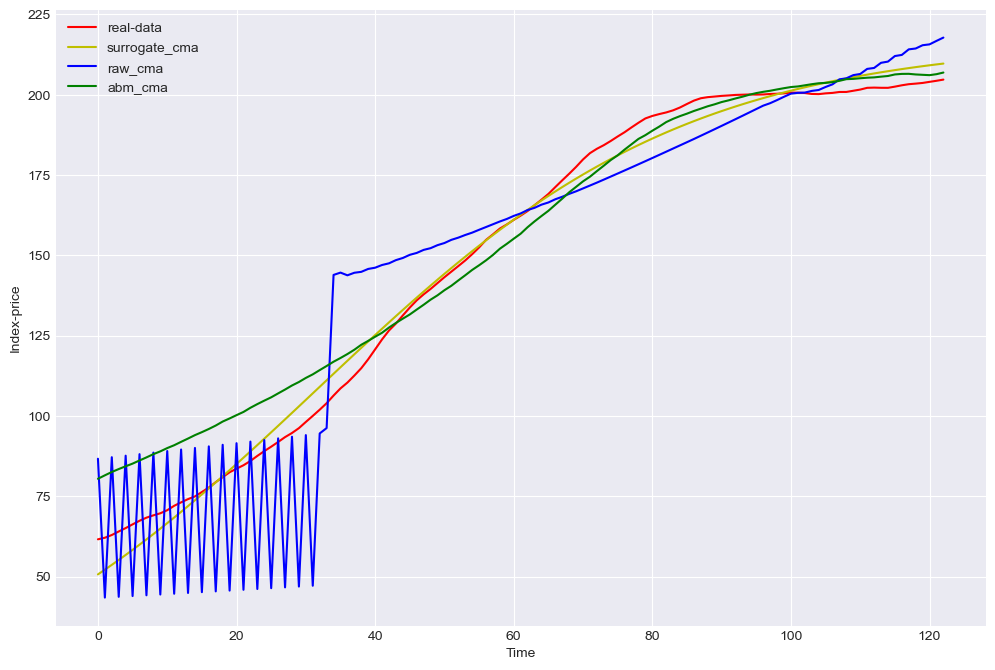

In [177]:
for i in range(50):
    main()